# The Business Challenge

**The TopBank Company**

- A Bank Services Company, with main operations on Europe.
- Offers financial products such as bank account, investments and insurance.
- Business Model: banking services through physical agencies and online.
- Main Product: bank account without costs, valid for 12 months. After this period, the account must be renovated.
- Bank account revenue per client:
    - 15% of client's estimated salary, for clients with estimated income lower than the average;
    - 20% of client's estimated salary, for clients with estimated income greater than the average.

**Problem**

- Clients' cancellation rate increased significantly in the last few months.

**Goal**

- Reduce clients' churn rate, that is, to avoid that the client cancel the contract and don't renovate it for more 12 months.

**Deliverables**

- Model's performance and results report with the following topics:
    - What's the company's current churn rate?
    - How the churn rate varies per month?
    - What's the model's performance to label the clients as churns?
    - What's the company's revenue, if the company avoids the customers to get into churn through the developed model?
- Possible measure: discount coupon or other financial incentive.
    - Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed $ 10,000.00.

# 0.0. Setup

## 0.1. Import the Relevant Libraries

In [1]:
# import the relevant libraries

# data manipulation
import pandas as pd
import numpy as np

# statistics
from scipy import stats

# text edit
import inflection

# graphs
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

# load images
from IPython.display import Image

# directories
import os

# stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

# warning
import warnings
warnings.filterwarnings( 'ignore' )

# save files
import pickle

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# data balancing
from imblearn.combine import SMOTETomek

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# model's cross-validation
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV

# model's metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

## 0.2. Helper Functions

In [2]:
# Save figures function
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Descriptive Statistics function
# valid only for numerical attriubutes
def num_stats(num_attr):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

    # Dispersion - standard deviation (std), min, max, skew, kurtosis
    d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
    d2 = pd.DataFrame( num_attr.apply( min ) ).T
    d3 = pd.DataFrame( num_attr.apply( max ) ).T

    # Dispersion - values' Range
    d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T

    # Dispersion - skew and kurtosis
    d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

    # Concatenate all data frames
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    # display dataframe
    return m

In [4]:
# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));

In [5]:
# Rename columns function (section 1.2.1)
def rename_columns(df1):
    # get current columns
    cols_old = df1.columns
    
    # apply snakecase to columns names
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))

    # rename columns
    df1.columns = cols_new
    
    return df1

In [6]:
# Feature Engineering Function (section 2.4)
def feature_engineering(df2):
    # tenure_year
    df2['tenure_year'] = df2['tenure'] + 1
    
    # age / tenure_year
    df2['age_ten_year'] = df2['age'] / df2['tenure_year']
    
    # credit_score / tenure_year
    df2['cred_ten_year'] = df2['credit_score'] / df2['tenure_year']
    
    # credit score / age
    df2['cred_age'] = df2['credit_score'] / df2['age']
    
    # amount
    df2['amount'] = df2['estimated_salary'] + df2['balance']
    
    # amount / credit_score
    df2['amount_credit'] = df2['amount'] / df2['credit_score']
    
    # amount / tenure_year
    df2['amount_ten_year'] = df2['amount'] / df2['tenure_year']

    # amount / products
    df2['amount_prod'] = df2['amount'] / df2['num_of_products']

    # credit score / products
    df2['cred_prod'] = df2['credit_score'] / df2['num_of_products']
    
    # balance / tenure_year
    df2['bal_ten_year'] = df2['balance'] / df2['tenure_year']

    # products - credit card
    df2['prod_m_cr'] = df2['num_of_products'] - df2['has_cr_card']

    # products * credit card
    df2['prod_t_cr'] = df2['num_of_products'] * df2['has_cr_card']

    
    
    # reorder columns
    df2 = df2[['row_number', 'customer_id', 'surname', 'credit_score','cred_ten_year', 'cred_age',
        'geography','gender', 'age', 'tenure', 'tenure_year','age_ten_year', 'balance', 'bal_ten_year', 
        'num_of_products', 'has_cr_card','is_active_member', 'estimated_salary', 'amount', 'amount_credit', 
        'amount_ten_year', 'cred_prod', 'amount_prod', 'prod_m_cr', 'prod_t_cr',  'exited']]
    
    return df2

In [7]:
# chi2 formula
def cramer_v( x, y ):
    # calculate confusion matrix (cm), contingency table
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    # calculate chi2
    chi2 = stats.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return Cramer V
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [8]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [9]:
# Model's performance on test set function
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, cm_df

In [10]:
# 0-1 knapsack function
# W: weight constraint
# wt: weight of each item
# val: value of each item
def knapsack(W, wt, val):
    n = len(val) # number of items in val
    # set a Table "K" with all values equal zero
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    # loop in rows of Table "K"
    for i in range(n + 1):
        # loop in columns of Table "K"
        for w in range(W + 1):
            if i == 0  or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1] + K[i-1][w-wt[i-1]], K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    max_val = K[n][W]
    
    # select chosen items that maximizes the output value
    # create a list with 'n' False items
    keep = [False] * n
    res = max_val
    w = W
    # decrescent loop
    for i in range(n, 0, -1):
        if res <= 0: break # break statement terminates the loop
        # continue statement skips the rest of the code inside a loop for the current iteration only.
        # Loop does not terminate but continues on with the next iteration.
        if res == K[i - 1][w]: continue
        else:
            keep[i - 1] = True
            res = res - val[i - 1]
            w = w - wt[i - 1]
    del K
    return max_val, keep

# 1.0. Data

Data source: https://www.kaggle.com/mervetorkan/churndataset

## 1.1. Load the Data

### 1.1.1. Load Original Data

In [6]:
# load the dataset
data_raw = pd.read_csv('dataset/churn.csv')

In [7]:
data_raw.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

### 1.1.2. Split data into train and test set

In [10]:
# check data_raw main infos
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- The dataset has 10,000 entries
- Low memory usage: 1.1 MB
- There are no missing values

In [11]:
# check Exited proportion
data_raw['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

In [14]:
# Apply stratified sampling in order to keep target variable proportion in the train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_raw, data_raw['Exited']):
    train_set = data_raw.loc[train_index]
    test_set = data_raw.loc[test_index]

In [15]:
# check Exited proportion on train_set
train_set['Exited'].value_counts(normalize=True)

0    0.79625
1    0.20375
Name: Exited, dtype: float64

In [16]:
# check Exited proportion on test_set
test_set['Exited'].value_counts(normalize=True)

0    0.7965
1    0.2035
Name: Exited, dtype: float64

In [17]:
# save train_set
train_set.to_csv('dataset/train.csv', index=False)

In [18]:
# save test_set
test_set.to_csv('dataset/test.csv', index=False)

### 1.1.3. Load train set

In [11]:
# load train_set
df1 = pd.read_csv('dataset/train.csv')

In [11]:
df1.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0       2152    15588614    Walton          753    France    Male   57   
1       8393    15641158   Belcher          739   Germany    Male   32   
2       5007    15750014   Chikere          755   Germany  Female   37   
3       4118    15663964  Pagnotto          561    France    Male   37   
4       7183    15573520    Rhodes          692   Germany    Male   49   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       7       0.00              1          1               0   
1       3  102128.27              1          1               0   
2       0  113865.23              2          1               1   
3       5       0.00              2          1               0   
4       6  110540.43              2          0               1   

   EstimatedSalary  Exited  
0        159475.08       1  
1         63981.37       1  
2        117396.25       0  
3         83093.25       0  
4        107472.99       0

## 1.2. Features Description

**RowNumber** - The number of the row.

**CustomerID** - Customer's unique identifier.

**Surname** - Customer's surname.

**CreditScore** - Customer's credit score for the consumer market.

**Geography** - The country where the customer lives.

**Gender** - Customer's gender.

**Age** - Customer's age.

**Tenure** - Number of years that the customer was active.

**Balance** - The amount that the customer has in the bank account.

**NumOfProducts** - The number of products bought by the customer.

**HasCrCard** - Flag that indicates if the customer has a credit card.

**IsActiveMember** - Flag that indicates if the customer has done a bank activity in the last 12 months.

**EstimateSalary** - Estimate customer's monthly income.

**Exited** - Flag that indicates if the customer is in Churn.

### 1.2.1. Rename Columns

In [12]:
# Rename columns function. For more details, please see section 0.2. Helper Functions
df1 = rename_columns(df1)

## 1.3. Data Dimension

In [13]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8000
Number of columns: 14


## 1.4. Data Types and Structure

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        8000 non-null   int64  
 1   customer_id       8000 non-null   int64  
 2   surname           8000 non-null   object 
 3   credit_score      8000 non-null   int64  
 4   geography         8000 non-null   object 
 5   gender            8000 non-null   object 
 6   age               8000 non-null   int64  
 7   tenure            8000 non-null   int64  
 8   balance           8000 non-null   float64
 9   num_of_products   8000 non-null   int64  
 10  has_cr_card       8000 non-null   int64  
 11  is_active_member  8000 non-null   int64  
 12  estimated_salary  8000 non-null   float64
 13  exited            8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 875.1+ KB


- There are no missing values
- Data types: float64(2), int64(9) and object(3)

## 1.5. Descriptive Statistics

### 1.5.1. Numercial Attributes

In [19]:
# select numerical attributes
num_attr = df1.select_dtypes(include=['int64', 'float64'])

In [15]:
# describe numerical attributes
num_attr.describe()

row_number   customer_id  credit_score          age       tenure  \
count   8000.000000  8.000000e+03   8000.000000  8000.000000  8000.000000   
mean    4990.432875  1.569088e+07    650.752500    38.946625     5.016625   
std     2896.482331  7.193619e+04     96.596432    10.526876     2.896791   
min        1.000000  1.556570e+07    350.000000    18.000000     0.000000   
25%     2461.750000  1.562869e+07    584.000000    32.000000     3.000000   
50%     4987.500000  1.568995e+07    652.000000    37.000000     5.000000   
75%     7509.500000  1.575327e+07    717.000000    44.000000     8.000000   
max    10000.000000  1.581569e+07    850.000000    92.000000    10.000000   

             balance  num_of_products  has_cr_card  is_active_member  \
count    8000.000000      8000.000000  8000.000000       8000.000000   
mean    76381.207499         1.529500     0.708750          0.514875   
std     62302.053597         0.581741     0.454367          0.499810   
min         0.000000         1.000000     0.000000          0.000000   
25%         0.000000         1.000000     0.000000          0.000000   
50%     97055.145000         1.000000     1.000000          1.000000   
75%    127633.195000         2.000000     1.000000          1.000000   
max    238387.560000         4.000000     1.000000          1.000000   

       estimated_salary      exited  
count       8000.000000  8000.00000  
mean       99730.811581     0.20375  
std        57335.116540     0.40281  
min           11.580000     0.00000  
25%        50691.817500     0.00000  
50%        99446.940000     0.00000  
75%       148527.730000     0.00000  
max       199992.480000     1.00000

In [20]:
# numerical attributes statistics
num_stats(num_attr)

attributes          min          max      range          mean  \
0         row_number         1.00     10000.00    9999.00  4.990433e+03   
1        customer_id  15565701.00  15815690.00  249989.00  1.569088e+07   
2       credit_score       350.00       850.00     500.00  6.507525e+02   
3                age        18.00        92.00      74.00  3.894662e+01   
4             tenure         0.00        10.00      10.00  5.016625e+00   
5            balance         0.00    238387.56  238387.56  7.638121e+04   
6    num_of_products         1.00         4.00       3.00  1.529500e+00   
7        has_cr_card         0.00         1.00       1.00  7.087500e-01   
8   is_active_member         0.00         1.00       1.00  5.148750e-01   
9   estimated_salary        11.58    199992.48  199980.90  9.973081e+04   
10            exited         0.00         1.00       1.00  2.037500e-01   

          median           std      skew  kurtosis  
0   4.987500e+03   2896.301295  0.002629 -1.209629  
1   1.568995e+07  71931.689685  0.006936 -1.196055  
2   6.520000e+02     96.590394 -0.079540 -0.418624  
3   3.700000e+01     10.526219  1.035706  1.459448  
4   5.000000e+00      2.896610  0.013124 -1.172842  
5   9.705515e+04  62298.159597 -0.141721 -1.492209  
6   1.000000e+00      0.581704  0.755984  0.636943  
7   1.000000e+00      0.454338 -0.919091 -1.155561  
8   1.000000e+00      0.499779 -0.059538 -1.996955  
9   9.944694e+04  57331.532983  0.007126 -1.174789  
10  0.000000e+00      0.402785  1.471283  0.164715

Saving figure 01_num_attr_histogram


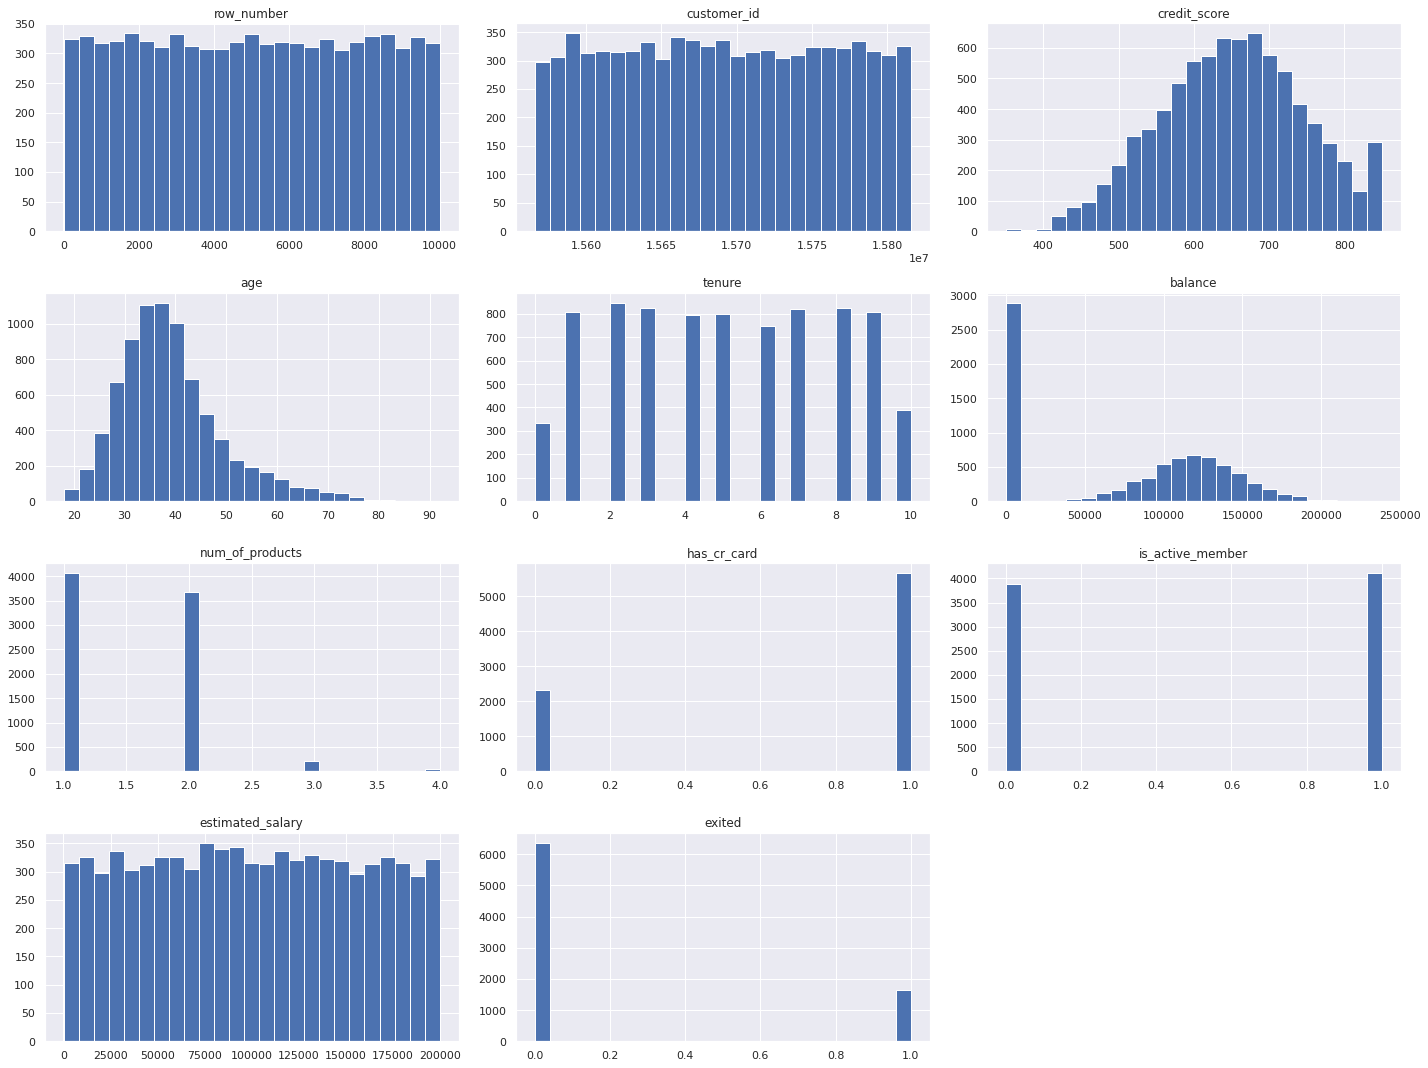

In [21]:
# numerical attributes histogram
num_hist = num_attr.hist( bins=25, figsize=(20,15) );
save_fig('01_num_attr_histogram')

- Credit score ranges from 350 up to 850. Mean = 650.75. Median = 652.
- Age ranges from 18 up to 92. Mean = 38.95. Median = 37. 75% of the observations are up to the age 44.
- Tenure (number of years that the customer was active) ranges from 0 to 10. Mean = 5.02. Median = 5. According the histogram, the number of customers with tenure equal to zero and 10 is lower than the other tenure values.
- Balance ranges from zero up to 238,387. Mean = 76,381. Median = 97,055. 25% of the observations have value equal to zero.
- Number of products ranges from 1 to 4. Mean = 1.53. Median = 1. 75% of the observations have value equal to 2. The histogram shows that the majority of number of products is 1 and 2. There is no number of products equal to zero, that is, all customers have bought at least one product.
- has_cr_card mean = 0.7087, that is, 70.87% of the observations have has_cr_card equal to 1.
- is_active_member mean = 0.5149, that is, 51.49% of the customers has done a bank activity in the past 12 months.
- Estimated salary ranges from 11.58 up to 199,992. Mean = 99,730. Median = 99,446. The histogram shows that the distribution is similar to an uniform distribution.
- Clients in churn: 20.4%.

#### 1.5.1.1. Tenure

In [44]:
# tenure feature
tenure_percentage = num_attr['tenure'].value_counts(normalize=True)*100
tenure_percentage

2     10.5875
3     10.3250
8     10.3000
7     10.2375
9     10.1125
1     10.1125
5     10.0000
4      9.9500
6      9.3375
10     4.8500
0      4.1875
Name: tenure, dtype: float64

Saving figure 01_tenure


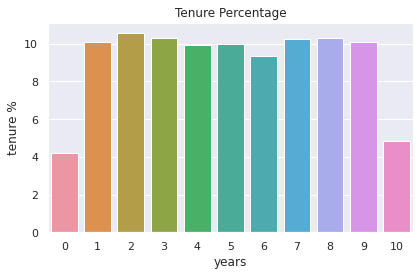

In [49]:
# plot tenure percentage
sns.barplot(x=tenure_percentage.index, y=tenure_percentage);
plt.title('Tenure Percentage');
plt.ylabel('tenure %');
plt.xlabel('years');
save_fig('01_tenure')

- 4.19% of the customers were active for less than a year.

#### 1.5.1.2. Balance

In [61]:
# check number of customers with balance equal to zero
balance_zero = num_attr[num_attr['balance'] == 0]
balance_zero['balance'].value_counts()

0.0    2891
Name: balance, dtype: int64

In [63]:
balance_zero['balance'].value_counts()[0] / num_attr.count()[0]

0.361375

- 2891 customers have balance equal to zero. That represents 36.14% of the customers.

Saving figure 01_balance_boxplot


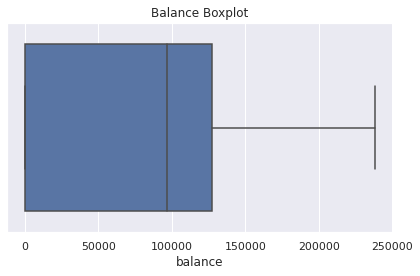

In [26]:
# balance Boxplot
sns.boxplot(x='balance', data=num_attr).set_title('Balance Boxplot');
save_fig('01_balance_boxplot')

#### 1.5.1.3. Estimated Salary

In [72]:
# check the lowest values
salary_low = num_attr[num_attr['estimated_salary'] < 1000]
salary_low['estimated_salary'].value_counts().sum()

43

In [73]:
salary_low

row_number  customer_id  credit_score  age  tenure    balance  \
85          9409     15767818           640   55      10  132436.34   
348         3392     15780411           570   46       3       0.00   
428         7227     15614813           777   46       0  107362.80   
492          394     15684548           556   38       8       0.00   
574         4163     15673584           652   74       5       0.00   
703         5838     15657603           850   35       6   81684.97   
984         6983     15685096           753   50       4       0.00   
1065        2724     15681550           614   41       8  121558.46   
1413        9051     15760988           667   33       9  124573.33   
1851        5121     15701176           663   26       5  141462.13   
2002        7566     15623369           708   52      10  105355.81   
2016        1759     15645544           642   30       5  129753.69   
2236        9921     15673020           678   49       3  204510.94   
2583        2047     15733429           520   34       8  120018.86   
2909        9114     15760662           521   29       2   87212.80   
2915        4990     15602851           629   40       9       0.00   
2966        2363     15791053           709   45       4  122917.71   
3457        3430     15674678           731   43       9   79120.27   
3585        8118     15639117           624   34       6       0.00   
3665        3776     15709004           528   22       5   93547.23   
3844        9648     15679693           625   31       5       0.00   
4080        5766     15717156           520   30       3  143396.54   
4215         983     15792360           668   32       7       0.00   
4352        8220     15607560           572   39       2       0.00   
4408        8029     15775124           763   37       8       0.00   
4438        7225     15609823           751   34       8  127095.14   
4455        9011     15786463           645   59       8  121669.93   
4481        6957     15696605           571   49       4  180614.04   
4595        4775     15640421           811   35       7       0.00   
4781         933     15634141           708   42       8  192390.52   
4899        3447     15764654           649   37       9   87374.88   
5261        8672     15689526           542   35       9  127543.11   
5428         397     15584766           557   33       3   54503.55   
5535        4384     15800784           645   42       4   98298.18   
6181        8723     15718667           621   35       7   87619.29   
6265        7021     15786237           651   28       7       0.00   
6385         560     15571816           850   70       5       0.00   
6471        8888     15768233           435   37       8  114346.30   
6473        8167     15769783           542   37       8       0.00   
6669         926     15636731           714   36       1  101609.01   
6909        6794     15611669           623   50       7  126608.37   
7189        9876     15747130           521   39       7       0.00   
7618        4105     15676571           850   55       6       0.00   

      num_of_products  has_cr_card  is_active_member  estimated_salary  exited  
85                  1            1                 0            978.66       0  
348                 2            0                 0            820.46       0  
428                 1            1                 0            487.30       0  
492                 2            0                 0            417.41       1  
574                 2            1                 1            937.15       0  
703                 1            1                 0            824.00       0  
984                 2            1                 1            861.40       0  
1065                1            1                 1            598.80       0  
1413                2            0                 0            683.37       0  
1851                1            1                 0            440.20 

- There are 43 instances with estimated salary lower than 1,000. Most of them have balance greater than 80,000, though.

Saving figure 01_salary_boxplot


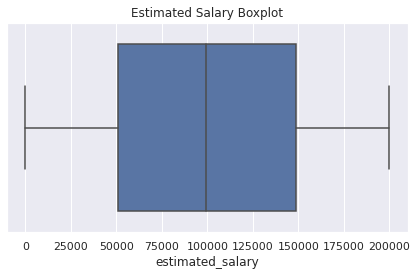

In [28]:
# estimated salary boxplot
sns.boxplot(x='estimated_salary', data=num_attr).set_title('Estimated Salary Boxplot');
save_fig('01_salary_boxplot')

#### 1.5.1.4. Credit Score

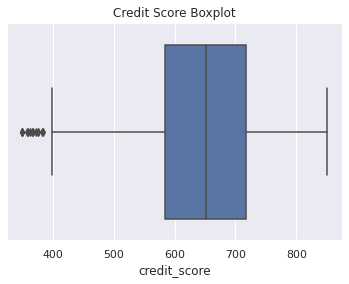

In [29]:
# credit score boxplot
sns.boxplot(x='credit_score', data=num_attr).set_title('Credit Score Boxplot');

- The boxplot shows that there are some outliers below 400.

- Check instances with credit score below 400:

In [34]:
aux_cred = num_attr[num_attr['credit_score'] < 400]
aux_cred['credit_score'].value_counts().sum()

15

In [35]:
aux_cred

row_number  customer_id  credit_score  age  tenure    balance  \
189         1963     15692416           358   52       8  143542.36   
379         9357     15734711           373   42       7       0.00   
667         1632     15685372           350   54       1  152677.48   
1124        8155     15791533           367   42       6   93608.28   
2025         943     15804586           376   46       6       0.00   
2283        1194     15779947           363   28       6  146098.43   
3210        1202     15651052           399   46       2  127655.22   
3439        5495     15642821           383   48       8   95808.19   
3533        9211     15792650           382   36       0       0.00   
4358        8724     15803202           350   51      10       0.00   
4767        1839     15758813           350   39       0  109733.20   
5457        1406     15612494           359   44       6  128747.69   
6319        2580     15597896           365   30       0  127760.07   
6430           8     15656148           376   29       4  115046.74   
6628        8763     15765173           350   60       3       0.00   

      num_of_products  has_cr_card  is_active_member  estimated_salary  exited  
189                 3            1                 0         141959.11       1  
379                 1            1                 0          77786.37       1  
667                 1            1                 1         191973.49       1  
1124                1            1                 0         168816.73       1  
2025                1            1                 0         157333.69       1  
2283                3            1                 0         100615.14       1  
3210                1            1                 0         139994.68       1  
3439                1            0                 0         137702.01       1  
3533                1            1                 1         179540.73       1  
4358                1            1                 1         125823.79       1  
4767                2            0                 0         123602.11       1  
5457                1            1                 0         146955.71       1  
6319                1            1                 0          81537.85       1  
6430                4            1                 0         119346.88       1  
6628                1            0                 0         113796.15       1

- There are 15 instances with credit score less than 400. All of them with 'exited' feature equal one (i.e., clients in churn).

### 1.5.2. Categorical Attributes

In [11]:
# select categorical attributes
cat_attr = df1.select_dtypes(exclude=['int64', 'float64'])
cat_attr

surname geography  gender
0        Walton    France    Male
1       Belcher   Germany    Male
2       Chikere   Germany  Female
3      Pagnotto    France    Male
4        Rhodes   Germany    Male
...         ...       ...     ...
7995       Kung     Spain  Female
7996  Ponomarev     Spain    Male
7997      Azuka    France  Female
7998    Olejuru     Spain    Male
7999       Mann     Spain    Male

[8000 rows x 3 columns]

In [79]:
geo_percentage = cat_attr['geography'].value_counts(normalize=True)*100
geo_percentage

France     49.9125
Germany    25.0625
Spain      25.0250
Name: geography, dtype: float64

Saving figure 01_geography


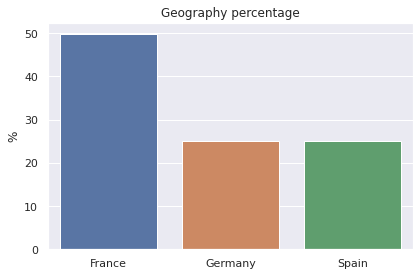

In [81]:
sns.barplot(x=geo_percentage.index, y=geo_percentage);
plt.ylabel('%');
plt.title('Geography percentage');
save_fig('01_geography')

- Almost 50% of the customers come from France.
- 25% of the customers come from Germany.
- The other 25% come from Spain.

In [83]:
gender_percentage = cat_attr['gender'].value_counts(normalize=True)*100
gender_percentage

Male      54.8375
Female    45.1625
Name: gender, dtype: float64

Saving figure 01_gender


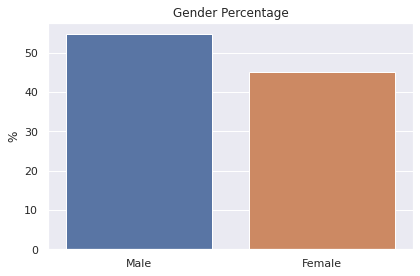

In [85]:
sns.barplot(x=gender_percentage.index, y=gender_percentage);
plt.ylabel('%');
plt.title('Gender Percentage');
save_fig('01_gender')

- 54.8% of the customers are men.
- 45.2% of the customers are women.

In [14]:
cat_attr['surname'].value_counts()

Smith        26
Martin       25
Scott        24
Genovese     23
Walker       21
             ..
Efremova      1
Voss          1
MacDevitt     1
Nielson       1
Colbert       1
Name: surname, Length: 2620, dtype: int64

- The most common surname is Smith with 26 times appearance.

## 1.6. Data Description Summary

**1. Credit Score**
- **Credit score ranges from 350 up to 850.** Mean = 650.75. Median = 652.
- There are 15 instances with credit score less than 400. **All of them with 'exited' feature equal one (i.e., clients in churn).**

**2. Age**
- **Age ranges from 18 up to 92.** Mean = 38.95. Median = 37. 75% of the observations are up to the age 44.

**3. Tenure (number of years that the customer was active)**
- Tenure ranges from 0 to 10. Mean = 5.02. Median = 5. According the histogram, the number of customers with tenure equal to zero and 10 is lower than the other tenure values. 
- **4.19% of the customers were active for less than a year.**

**4. Balance**
- **Balance ranges from zero up to 238,387.** Mean = 76,381. Median = 97,055. 25% of the observations have value equal to zero.
- **2891 customers have balance equal to zero. That represents 36.14% of the customers.**

**5. Products**
- Number of products ranges from 1 to 4. Mean = 1.53. Median = 1. 75% of the observations have value equal to 2. - - The histogram shows that **the majority of number of products is 1 and 2. There is no number of products equal to zero, that is, all customers have bought at least one product.**

**6. Credit Card**
- has_cr_card mean = 0.7087, that is, **70.87% of the customers have credit card.**

**7. Active Member**
- is_active_member mean = 0.5149, that is, **51.49% of the customers has done a bank activity in the past 12 months.**

**8. Estimated Salary**
- **Estimated salary ranges from 11.58 up to 199,992.** Mean = 99,730. Median = 99,446. The histogram shows that the distribution is similar to an uniform distribution.
- There are **43 instances with estimated salary lower than 1,000. Most of them have balance greater than 80,000, though.**

**9. Geography**
- **Almost 50% of the customers come from France.** 25% of the customers come from Germany and the other 25% come from Spain.

**10. Gender**
- **54.8% of the customers are men. 45.2% of the customers are women.**

**11. Surname**
- The most common surname is Smith with 26 times appearance.

**12. Churn Rate**
- **Clients in churn: 20.4%.**

# 2.0. Feature Engineering

In [13]:
# copy df1
df2 = df1.copy()

## 2.1. Mind Map

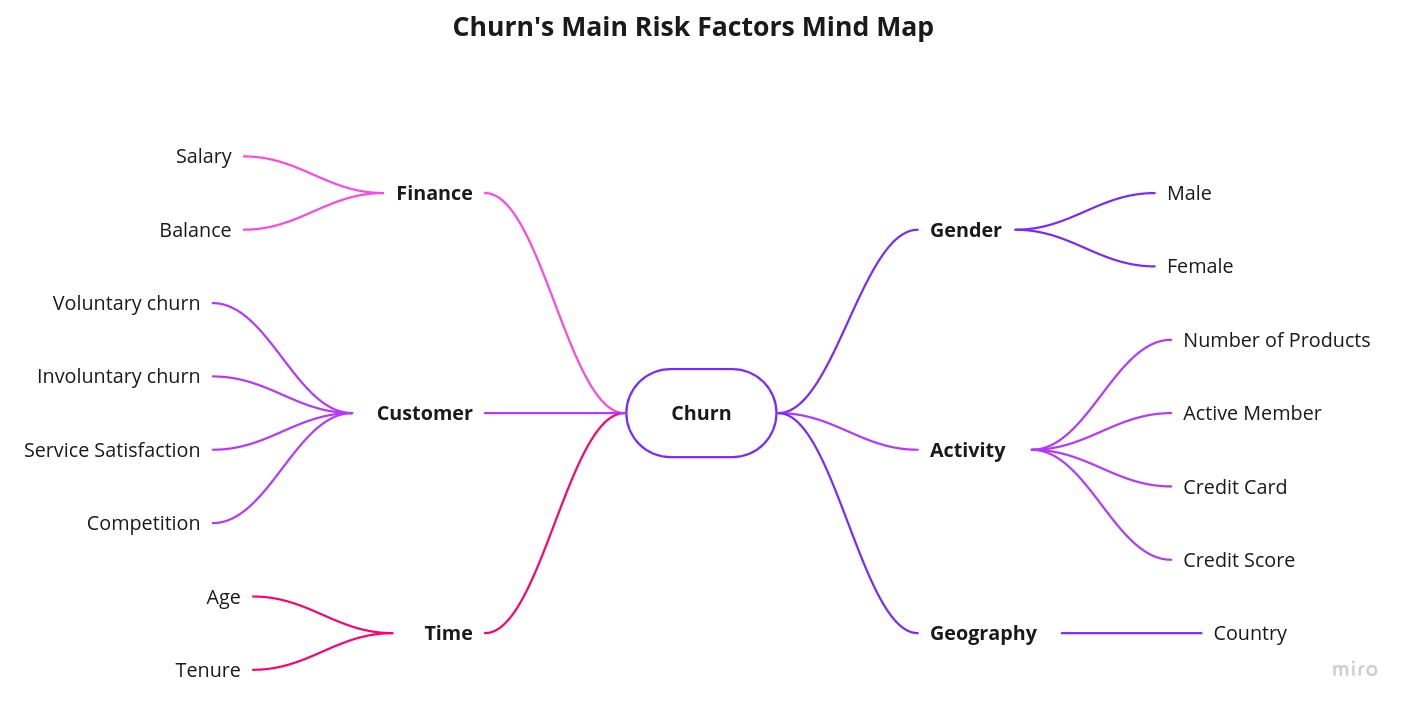

In [99]:
Image('images/mind_map_churn.jpg')

## 2.2. Hypothesis Creation

### 2.2.1. Finance

**1.** Churn should occur for clients with high salary

**2.** Churn should occur for clients with high balance

### 2.2.2. Gender

**1.** Churn should occur more for women than men.

### 2.2.3. Activity

**1.** Churn should occur for clients with one product.

**2.** Churn should not occur for active members.

**3.** Churn should not occur for clients with credit card.

**4.** Churn should occur for clients with a low credit score.

### 2.2.4. Geography

**1.** Churn rate should be higher for clients from Spain.

### 2.2.5. Time

**1.** Churn rate should be higher among young clients

**2.** Churn should occur for clients with high tenure.

### 2.2.6. Customer

**1.** Churn rate should be higher for voluntary churn in comparison to involuntary churn.

**2.** Churn should occur for clients with low service satisfaction rate.

**3.** Churn should occur due to competition.

## 2.3. Final Hypothesis List (Based on the data available in the dataset)

**1.** Churn should occur for clients with high salary

**2.** Churn should occur for clients with high balance

**3.** Churn should occur more for women than men.

**4.** Churn should occur for clients with one product.

**5.** Churn should not occur for active members.

**6.** Churn should not occur for clients with credit card.

**7.** Churn should occur for clients with a low credit score.

**8.** Churn rate should be higher for clients from Spain.

**9.** Churn rate should be higher among young clients

**10.** Churn should occur for clients with high tenure.

## 2.4. Feature Engineering

- The Feature Engineering is executed mainly based on the features relationship, according to the descriptive statistics previoulsy performed.

In [14]:
# feature engineering function. For more details, please see section 0.2. Helper Functions
df2 = feature_engineering(df2)

In [15]:
df2.sample(10).T

3709      3473      6121      7879      4821      2393  \
row_number            7784      7314      9134      8448      8874      7987   
customer_id       15681332  15583067  15726776  15792627  15810839  15678067   
surname               Tate  McMillan  Donnelly      Reid    Rogers     Boyle   
credit_score           437       687       705       765       610       667   
cred_ten_year      62.4286     137.4     352.5     127.5       610    166.75   
cred_age           10.1628   19.0833   19.5833   23.1818   17.9412   14.8222   
geography           France    France     Spain     Spain    France     Spain   
gender              Female    Female      Male    Female      Male      Male   
age                     43        36        36        33        34        45   
tenure                   6         4         1         5         0         3   
tenure_year              7         5         2         6         1         4   
age_ten_year       6.14286       7.2        18       5.5        34     11.25   
balance                  0     97158    111629   84557.8    103108         0   
bal_ten_year             0   19431.6   55814.6     14093    103108         0   
num_of_products          1         1         1         1         1         2   
has_cr_card              1         0         1         1         0         0   
is_active_member         0         1         1         1         0         0   
estimated_salary    148331   63185.1   21807.2   69039.4    125647    163655   
amount              148331    160343    133436    153597    228755    163655   
amount_credit       339.43   233.396   189.272   200.781   375.008    245.36   
amount_ten_year    21190.1   32068.6   66718.2   25599.5    228755   40913.8   
cred_prod              437       687       705       765       610     333.5   
amount_prod         148331    160343    133436    153597    228755   81827.5   
prod_m_cr                0         1         0         0         1         2   
prod_t_cr                1         0         1         1         0         0   
exited                   1         0         0         0         0         0   

                      4301      3636      7272      5063  
row_number            7577      1807      9959      5800  
customer_id       15666096  15683471  15657771  15649853  
surname             Ibekwe    Hansen     Ts'ui     Craig  
credit_score           676       691       537       625  
cred_ten_year        135.2    86.375   76.7143    156.25  
cred_age            25.037   18.1842   14.5135   13.8889  
geography            Spain    France    France    France  
gender                Male      Male      Male    Female  
age                     27        38        37        45  
tenure                   4         7         6         3  
tenure_year              5         8         7         4  
age_ten_year           5.4      4.75   5.28571     11.25  
balance                  0         0         0         0  
bal_ten_year             0         0         0         0  
num_of_products          1         2         1         1  
has_cr_card              0         0         1         1  
is_active_member         1         0         1         1  
estimated_salary    107956   81617.4   17802.4    184474  
amount              107956   81617.4   17802.4    184474  
amount_credit      159.698   118.115   33.1516   295.159  
amount_ten_year    21591.1   10202.2    2543.2   46118.5  
cred_prod              676     345.5       537       625  
amount_prod         107956   40808.7   17802.4    184474  
prod_m_cr                1         2         0         0  
prod_t_cr                0         0         1         1  
exited                   0         0         0         1

**12 new features were created.**
**New Features description:**

- **tenure_year**: Client's year of the tenure. For example, a client that has just started with the bank has a tenure equal to zero and a tenure year equal one (first year with the bank).

- **age_ten_year**: age of the customer divided by the tenure_year.

- **credit_ten_year**: Ratio between credit score and tenure year.

- **cred_age**: credit score divided by the age of the customer.

- **amount**: sum of the client's estimated salary and balance.

- **amount_credit**: Ratio between the client's amount and credit score.

- **amount_ten_year**: client's amount divided by the tenure year.

- **amount_prod**: client's amount divided by the number of products.

- **cred_prod**: Ratio between client's credit score and the number of products.

- **bal_ten_year**: client's balance divided by the tenure year.

- **prod_m_cr**: number of producrs minus credit card.

- **prod_t_cr**: number of products times credit card.

# 3.0. Variables Filtering

- No variables Filtering needed at this moment.

# 4.0. EDA - Exploratory Data Analysis

In [16]:
df4 = df2.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

In [95]:
df4['exited'].value_counts()

0    6370
1    1630
Name: exited, dtype: int64

Saving figure 04_exited


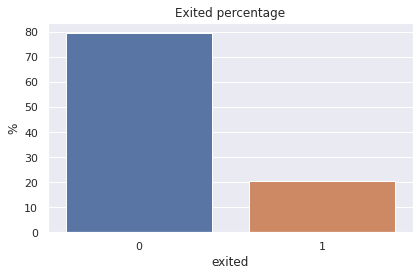

In [126]:
exited_percentage = df4['exited'].value_counts(normalize=True)*100
sns.barplot(x=exited_percentage.index, y=exited_percentage);
plt.ylabel('%');
plt.xlabel('exited');
plt.title('Exited percentage');
save_fig('04_exited')

In [127]:
exited_percentage

0    79.625
1    20.375
Name: exited, dtype: float64

- 20.4% of the clients exited TopBank. That is the current churn rate.

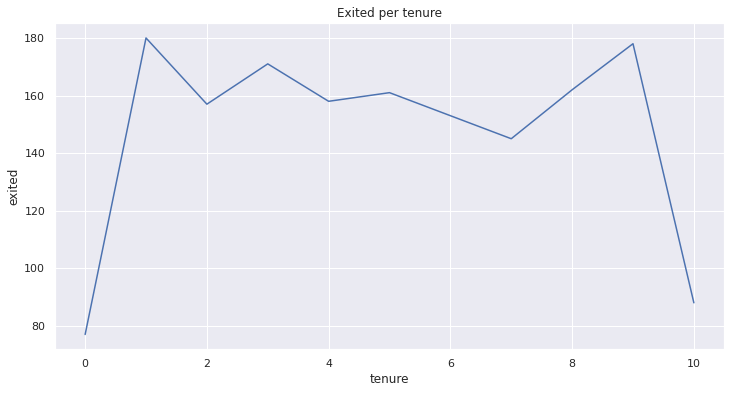

In [129]:
# Exited values per time
aux1 = df4[['tenure', 'exited']].groupby('tenure').sum().reset_index()

# set up figure size
plt.subplots(figsize=(12,6))
sns.lineplot(x='tenure', y='exited', data=aux1).set_title('Exited per tenure');

- The quantity of exited clients is higher in the first year and in the 9th year as bank's client.

### 4.1.2. Numerical Variable

In [17]:
num_attr = df4.select_dtypes(include=['int64', 'float64'])

In [18]:
num_attr.describe().T

count          mean           std           min  \
row_number        8000.0  4.990433e+03   2896.482331  1.000000e+00   
customer_id       8000.0  1.569088e+07  71936.185838  1.556570e+07   
credit_score      8000.0  6.507525e+02     96.596432  3.500000e+02   
cred_ten_year     8000.0  1.576143e+02    133.262431  3.181818e+01   
cred_age          8000.0  1.787218e+01      5.375629  4.857143e+00   
age               8000.0  3.894662e+01     10.526876  1.800000e+01   
tenure            8000.0  5.016625e+00      2.896791  0.000000e+00   
tenure_year       8000.0  6.016625e+00      2.896791  1.000000e+00   
age_ten_year      8000.0  9.460693e+00      8.525194  1.636364e+00   
balance           8000.0  7.638121e+04  62302.053597  0.000000e+00   
bal_ten_year      8000.0  1.871215e+04  25182.630543  0.000000e+00   
num_of_products   8000.0  1.529500e+00      0.581741  1.000000e+00   
has_cr_card       8000.0  7.087500e-01      0.454367  0.000000e+00   
is_active_member  8000.0  5.148750e-01      0.499810  0.000000e+00   
estimated_salary  8000.0  9.973081e+04  57335.116540  1.158000e+01   
amount            8000.0  1.761120e+05  85113.097209  9.007000e+01   
amount_credit     8000.0  2.770896e+02    142.984586  1.441120e-01   
amount_ten_year   8000.0  4.290042e+04  45038.549920  1.066700e+01   
cred_prod         8000.0  4.868349e+02    183.766330  9.400000e+01   
amount_prod       8000.0  1.371799e+05  87928.660922  4.503500e+01   
prod_m_cr         8000.0  8.207500e-01      0.734974  0.000000e+00   
prod_t_cr         8000.0  1.086375e+00      0.851472  0.000000e+00   
exited            8000.0  2.037500e-01      0.402810  0.000000e+00   

                           25%           50%           75%           max  
row_number        2.461750e+03  4.987500e+03  7.509500e+03  1.000000e+04  
customer_id       1.562869e+07  1.568995e+07  1.575327e+07  1.581569e+07  
credit_score      5.840000e+02  6.520000e+02  7.170000e+02  8.500000e+02  
cred_ten_year     7.633333e+01  1.088167e+02  1.853333e+02  8.500000e+02  
cred_age          1.408466e+01  1.729865e+01  2.093939e+01  4.688889e+01  
age               3.200000e+01  3.700000e+01  4.400000e+01  9.200000e+01  
tenure            3.000000e+00  5.000000e+00  8.000000e+00  1.000000e+01  
tenure_year       4.000000e+00  6.000000e+00  9.000000e+00  1.100000e+01  
age_ten_year      4.400000e+00  6.444444e+00  1.100000e+01  7.900000e+01  
balance           0.000000e+00  9.705515e+04  1.276332e+05  2.383876e+05  
bal_ten_year      0.000000e+00  1.327906e+04  2.451326e+04  1.970418e+05  
num_of_products   1.000000e+00  1.000000e+00  2.000000e+00  4.000000e+00  
has_cr_card       0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
is_active_member  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
estimated_salary  5.069182e+04  9.944694e+04  1.485277e+05  1.999925e+05  
amount            1.175445e+05  1.769135e+05  2.402496e+05  4.003484e+05  
amount_credit     1.788820e+02  2.708824e+02  3.749402e+02  9.847171e+02  
amount_ten_year   1.766741e+04  2.944390e+04  5.002961e+04  3.732363e+05  
cred_prod         3.235000e+02  4.450000e+02  6.540000e+02  8.500000e+02  
amount_prod       6.809130e+04  1.229909e+05  1.998015e+05  4.003484e+05  
prod_m_cr         0.000000e+00  1.000000e+00  1.000000e+00  4.000000e+00  
prod_t_cr         0.000000e+00  1.000000e+00  2.000000e+00  4.000000e+00  
exited            0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00

In [19]:
# numerical attributes statistics
num_stats(num_attr)

attributes           min           max          range          mean  \
0         row_number  1.000000e+00  1.000000e+04    9999.000000  4.990433e+03   
1        customer_id  1.556570e+07  1.581569e+07  249989.000000  1.569088e+07   
2       credit_score  3.500000e+02  8.500000e+02     500.000000  6.507525e+02   
3      cred_ten_year  3.181818e+01  8.500000e+02     818.181818  1.576143e+02   
4           cred_age  4.857143e+00  4.688889e+01      42.031746  1.787218e+01   
5                age  1.800000e+01  9.200000e+01      74.000000  3.894662e+01   
6             tenure  0.000000e+00  1.000000e+01      10.000000  5.016625e+00   
7        tenure_year  1.000000e+00  1.100000e+01      10.000000  6.016625e+00   
8       age_ten_year  1.636364e+00  7.900000e+01      77.363636  9.460693e+00   
9            balance  0.000000e+00  2.383876e+05  238387.560000  7.638121e+04   
10      bal_ten_year  0.000000e+00  1.970418e+05  197041.800000  1.871215e+04   
11   num_of_products  1.000000e+00  4.000000e+00       3.000000  1.529500e+00   
12       has_cr_card  0.000000e+00  1.000000e+00       1.000000  7.087500e-01   
13  is_active_member  0.000000e+00  1.000000e+00       1.000000  5.148750e-01   
14  estimated_salary  1.158000e+01  1.999925e+05  199980.900000  9.973081e+04   
15            amount  9.007000e+01  4.003484e+05  400258.360000  1.761120e+05   
16     amount_credit  1.441120e-01  9.847171e+02     984.572945  2.770896e+02   
17   amount_ten_year  1.066700e+01  3.732363e+05  373225.613000  4.290042e+04   
18         cred_prod  9.400000e+01  8.500000e+02     756.000000  4.868349e+02   
19       amount_prod  4.503500e+01  4.003484e+05  400303.395000  1.371799e+05   
20         prod_m_cr  0.000000e+00  4.000000e+00       4.000000  8.207500e-01   
21         prod_t_cr  0.000000e+00  4.000000e+00       4.000000  1.086375e+00   
22            exited  0.000000e+00  1.000000e+00       1.000000  2.037500e-01   

          median           std      skew   kurtosis  
0   4.987500e+03   2896.301295  0.002629  -1.209629  
1   1.568995e+07  71931.689685  0.006936  -1.196055  
2   6.520000e+02     96.590394 -0.079540  -0.418624  
3   1.088167e+02    133.254102  2.533326   7.282176  
4   1.729865e+01      5.375293  0.755077   1.042230  
5   3.700000e+01     10.526219  1.035706   1.459448  
6   5.000000e+00      2.896610  0.013124  -1.172842  
7   6.000000e+00      2.896610  0.013124  -1.172842  
8   6.444444e+00      8.524661  2.815697  10.289615  
9   9.705515e+04  62298.159597 -0.141721  -1.492209  
10  1.327906e+04  25181.056579  2.688730   9.898197  
11  1.000000e+00      0.581704  0.755984   0.636943  
12  1.000000e+00      0.454338 -0.919091  -1.155561  
13  1.000000e+00      0.499779 -0.059538  -1.996955  
14  9.944694e+04  57331.532983  0.007126  -1.174789  
15  1.769135e+05  85107.777474 -0.074331  -0.696291  
16  2.708824e+02    142.975649  0.269328  -0.089273  
17  2.944390e+04  45035.734922  2.938106  11.387018  
18  4.450000e+02    183.754844  0.215176  -1.316840  
19  1.229909e+05  87923.165209  0.490550  -0.696397  
20  1.000000e+00      0.734928  0.583833   0.132941  
21  1.000000e+00      0.851419  0.183340  -0.734669  
22  0.000000e+00      0.402785  1.471283   0.164715

Saving figure 04_histogram


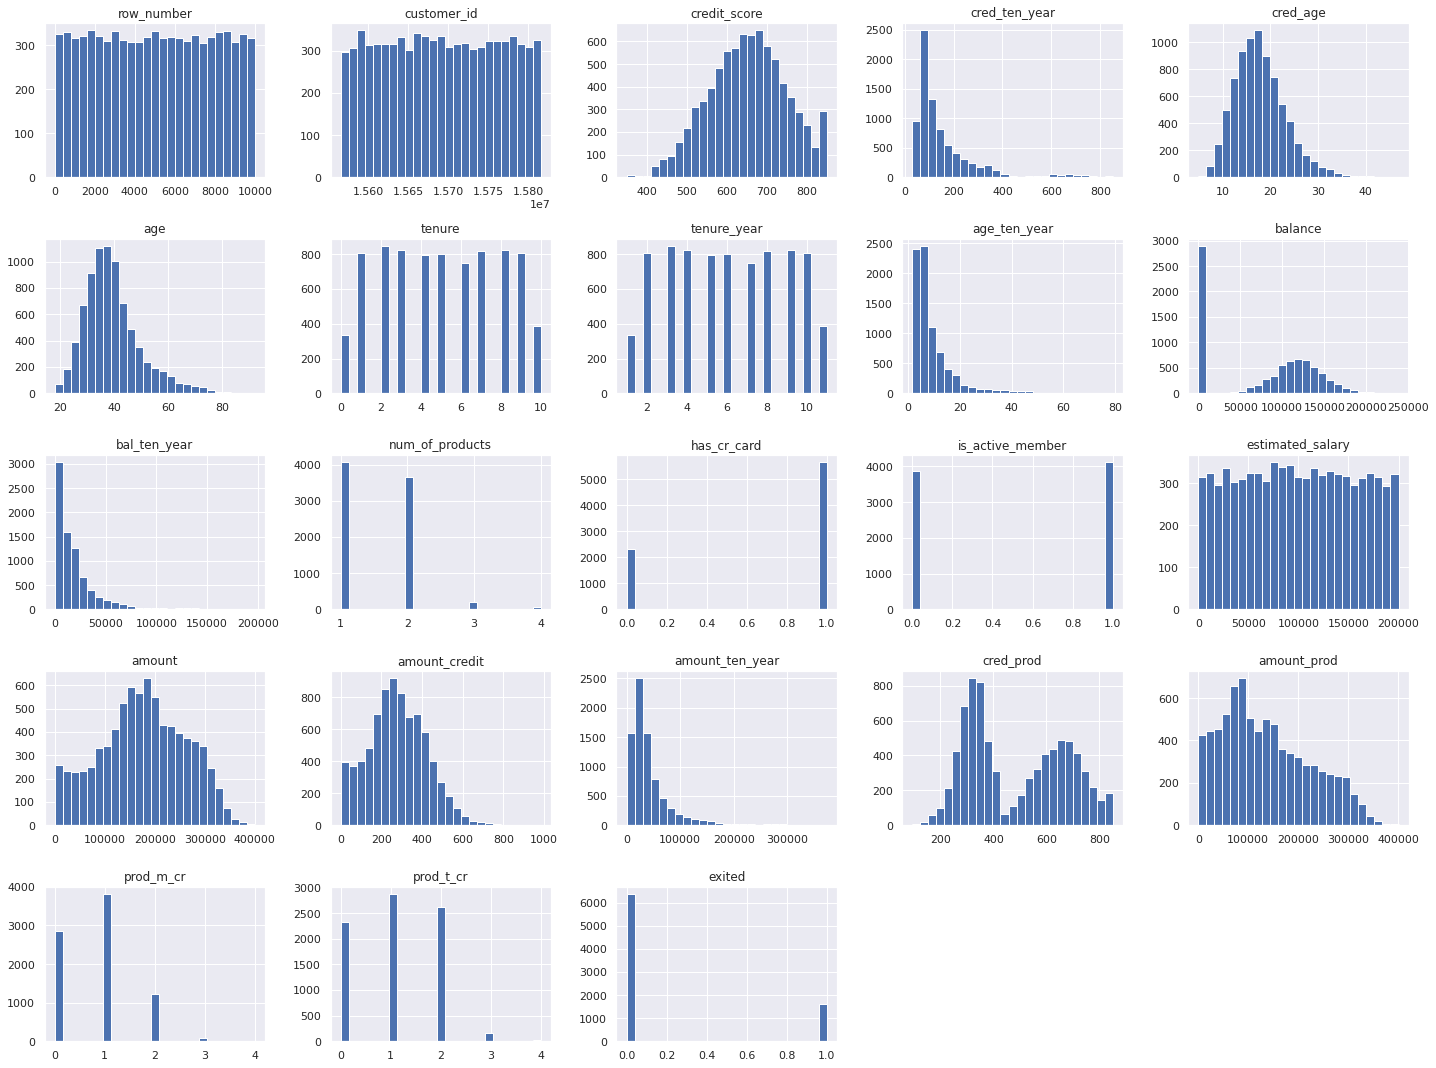

In [20]:
# numerical attributes histogram
num_attr.hist( bins=25, figsize=(20,15) );
save_fig('04_histogram')

**New Features descriptive statistics summary:**

- cred_ten_year ranges from 31.8 to 850. Mean = 157.6. Median = 108.8. 75% of the observations have values up to 185.3. In average, the client gets 157.6 credit score for each year as bank's client. The value of 850 means that there are customers with the maximum credit score already in the first year as bank's client.
- cred_age ranges from 4.86 to 46.9. Mean = 17.9. Median = 17.3. 75% of the observations are up to 20.9.
- tenure_year ranges from 1 to 11. Mean = 6.02. Median = 6.
- age_ten_year ranges from 1.64 to 79. Mean = 9.46. Median = 6.44. 75% of the observations have values up to 11.
- bal_ten_year ranges from 0 to 197,041. Mean = 18,712. Median = 13,297. 25% of the observations have value equal to zero. 75% of the observations have values up to 24,513.
- amount ranges from 90 to 400,348. Mean = 176,112. Median = 176,913. 25% of the observations have values up to 117,544. 75% of the observations have values up to 240,249.
- amount_credit ranges from 0.14 to 984. Mean = 277. Median = 270. 25% of the observations have values up to 178. 75% of the observations have values up to 374. An amount_credit smaller than one means that the client has more credit score than money.
- amount_ten_year ranges from 10 to 373,236. Mean = 42,900. Median = 29,443. 25% of the observations have values up to 17,667. 75% of the observations have values up to 50,029.
- cred_prod ranges from 94 to 850. Mean = 486. Median = 445. 25% of the observations have values up to 323. 75% of the observations have values up to 654. In average, the clients have 486 credit score per purchased product. The value of 850 means that there are clients with the maximum credit score which purchased only one product.
- amount_prod ranges from 45 to 400,348. Mean = 137,179. Median = 122,990. 25% of the observations have values up to 68,091. 75% of the observations have values up to 199,801. The value of 400,348 means that there are customers with the maximum amount which bought only one product.
- prod_m_cr ranges from 0 to 4. Mean = 0.8. Median = 1. 25% of the observations have value equal to zero. 75% of the observations have value equal to one. 
- prod_t_cr ranges from 0 to 4. Mean = 1.09. Median = 1. 25% of the observations have value equal to zero. 75% of the observations have value equal to 2. Value 0 means that the client has bought products but does not have a credit card.

In [28]:
num_attr['customer_id'].value_counts()

15812607    1
15707551    1
15728005    1
15811978    1
15682955    1
           ..
15692977    1
15684367    1
15682467    1
15712777    1
15695872    1
Name: customer_id, Length: 8000, dtype: int64

- Unique customer ID (no customer repetition).

### 4.1.3. Categorical Variable

In [31]:
cat_attr = df4.select_dtypes(exclude=['int64', 'float64'])
cat_attr.describe()

surname geography gender
count     8000      8000   8000
unique    2620         3      2
top      Smith    France   Male
freq        26      3993   4387

In [30]:
cat_attr['geography'].value_counts()

France     3993
Germany    2005
Spain      2002
Name: geography, dtype: int64

Saving figure 04_clients_per_country


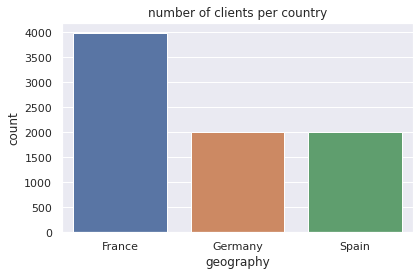

In [35]:
sns.countplot(x='geography', data=cat_attr).set_title('number of clients per country');
save_fig('04_clients_per_country')

In [37]:
cat_attr['geography'].value_counts(normalize=True)*100

France     49.9125
Germany    25.0625
Spain      25.0250
Name: geography, dtype: float64

- 3993 clients (49.91%) are from France.
- 2005 clients (25.06%) are from Germany.
- 2002 clients (25.03%) are from Spain.

In [38]:
cat_attr['gender'].value_counts()

Male      4387
Female    3613
Name: gender, dtype: int64

Saving figure 04_clients_per_gender


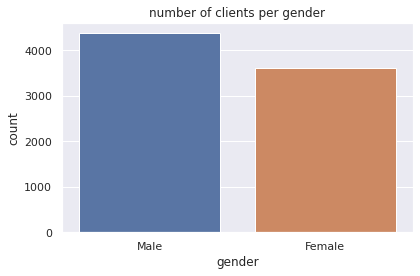

In [39]:
sns.countplot(x='gender', data=cat_attr).set_title('number of clients per gender');
save_fig('04_clients_per_gender')

In [41]:
cat_attr['gender'].value_counts(normalize=True)*100

Male      54.8375
Female    45.1625
Name: gender, dtype: float64

- 4387 clients (54.8%) are men.
- 3613 clients (45.2%) are women.

In [42]:
cat_attr['surname'].value_counts()

Smith         26
Martin        25
Scott         24
Genovese      23
Walker        21
              ..
Moody          1
Pye            1
Rischbieth     1
Lang           1
Theus          1
Name: surname, Length: 2620, dtype: int64

- There are 2620 different surnames in the dataset.
- The most common surnames are Smith (26), Martin (25) and Scott (24).

## 4.2. Bivariate Analysis

### H1. Churn should occur for clients with high salary
**TRUE** Churn occur for clients with high salary.

Saving figure 04_estimated_salary_density_distribution


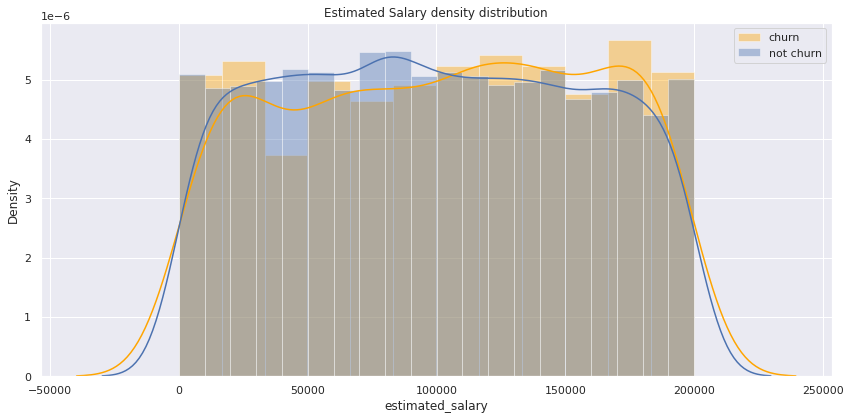

In [19]:
# create auxiliary dataframes for exited = 0 and exited = 1
aux1_1 = df4[df4['exited']==0]
aux1_2 = df4[df4['exited']==1]

# plot estimated salary density distribution for exited = 0 and exited = 1
plt.figure(figsize=(12,6))
sns.distplot(aux1_2['estimated_salary'], color='orange', kde=True, label='churn')
sns.distplot(aux1_1['estimated_salary'], kde=True, label='not churn')
plt.title('Estimated Salary density distribution');
plt.legend();
save_fig('04_estimated_salary_density_distribution')

In [75]:
aux1_2['estimated_salary'].describe()

count      1630.000000
mean     102026.976110
std       57949.860723
min          11.580000
25%       52662.252500
50%      104721.985000
75%      151224.030000
max      199808.100000
Name: estimated_salary, dtype: float64

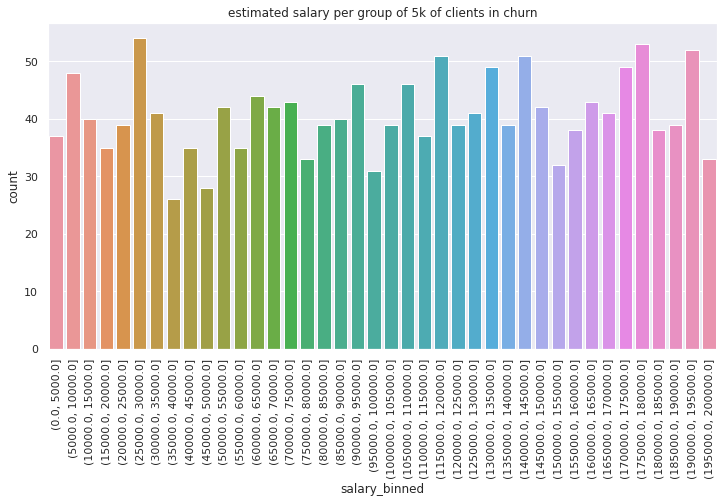

In [81]:
# plot estimated_salary binned values of clients in churn
bins1 = list(np.arange(0, 2.01e5, 5e3))
aux1_2['salary_binned'] = pd.cut(aux1_2['estimated_salary'], bins=bins1)
plt.subplots(figsize=(12,6))
sns.countplot(x='salary_binned', data=aux1_2).set_title("estimated salary per group of 5k of clients in churn");
# rotate x axis
plt.xticks(rotation=90);

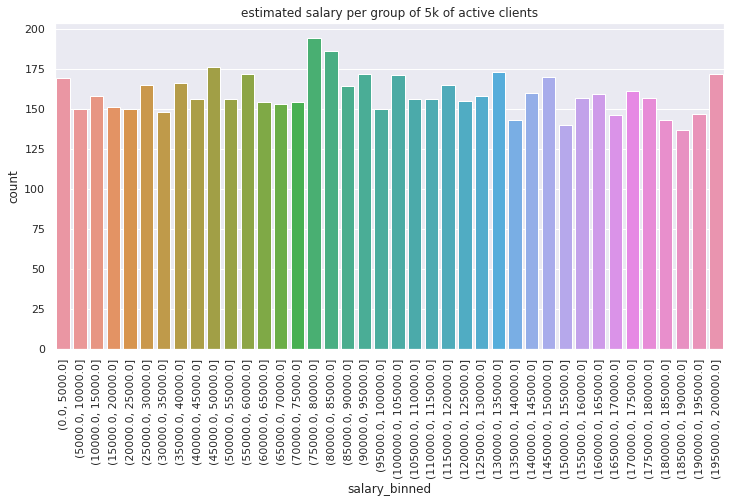

In [82]:
# plot estimated_salary binned values of active clients
bins1 = list(np.arange(0, 2.01e5, 5e3))
aux1_1['salary_binned'] = pd.cut(aux1_1['estimated_salary'], bins=bins1)
plt.subplots(figsize=(12,6))
sns.countplot(x='salary_binned', data=aux1_1).set_title("estimated salary per group of 5k of active clients");
# rotate x axis
plt.xticks(rotation=90);

- Plot estimated salary percentage per group of 5k

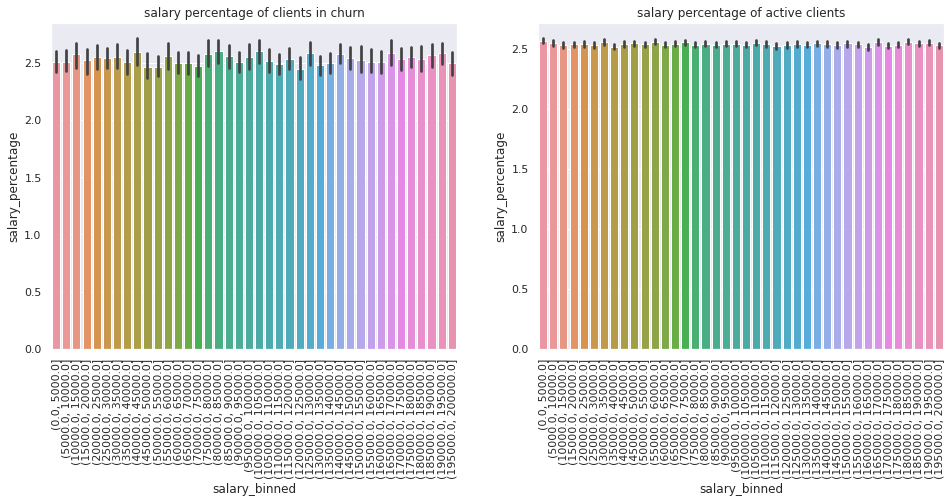

In [94]:
# define salary percentage
aux1_1['salary_percentage'] = aux1_1['salary_binned'].value_counts(normalize=True)*100
aux1_2['salary_percentage'] = aux1_2['salary_binned'].value_counts(normalize=True)*100

# set up figure size
plt.subplots(figsize=(16,6))

# 1st plot
plt.subplot(1,2,1)
sns.barplot(x='salary_binned', y='salary_percentage', data=aux1_2).set_title('salary percentage of clients in churn')
# rotate x axis
plt.xticks(rotation=90);

# 2nd plot
plt.subplot(1,2,2)
sns.barplot(x='salary_binned', y='salary_percentage', data=aux1_1).set_title('salary percentage of active clients')
# rotate x axis
plt.xticks(rotation=90);

- Calculate the relative percentage of active clients and clients in churn per salary_binned

In [106]:
# set new bins in order to ease the analysis
bins2 = list(np.arange(0, 2.01e5, 20e3))

# create new dataframe
aux100 = df4[['estimated_salary', 'exited']]
aux100['salary_binned'] = pd.cut(aux100['estimated_salary'], bins=bins2)

# new dataframe with salary_binned, exited and number of clients
aux101 = aux100[['salary_binned', 'estimated_salary', 'exited']].\
groupby(['salary_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux101.columns = ['salary_binned', 'exited', 'clients']

# sum of clients in churn
clients_in_churn = aux101[aux101['exited'] == 1]['clients'].sum()

# sum of active clients
clients_not_churn = aux101[aux101['exited'] == 0]['clients'].sum()

# calculate the relative percentage of clients in churn and active clients
aux101['relative_percentage'] = aux101.\
apply(lambda x: ((x['clients'] / clients_in_churn)*100) if x['exited'] == 1 else ((x['clients'] / clients_not_churn)*100), axis=1)

aux101

salary_binned  exited  clients  relative_percentage
0         (0.0, 20000.0]       0      628             9.858713
1         (0.0, 20000.0]       1      160             9.815951
2     (20000.0, 40000.0]       0      629             9.874411
3     (20000.0, 40000.0]       1      160             9.815951
4     (40000.0, 60000.0]       0      660            10.361068
5     (40000.0, 60000.0]       1      140             8.588957
6     (60000.0, 80000.0]       0      655            10.282575
7     (60000.0, 80000.0]       1      162             9.938650
8    (80000.0, 100000.0]       0      672            10.549451
9    (80000.0, 100000.0]       1      156             9.570552
10  (100000.0, 120000.0]       0      648            10.172684
11  (100000.0, 120000.0]       1      173            10.613497
12  (120000.0, 140000.0]       0      629             9.874411
13  (120000.0, 140000.0]       1      168            10.306748
14  (140000.0, 160000.0]       0      627             9.843014
15  (140000.0, 160000.0]       1      163            10.000000
16  (160000.0, 180000.0]       0      623             9.780220
17  (160000.0, 180000.0]       1      186            11.411043
18  (180000.0, 200000.0]       0      599             9.403454
19  (180000.0, 200000.0]       1      162             9.938650

- Plot the relative percentage of active clients and clients in churn per salary_binned

Saving figure 04_salary_relative_percentage


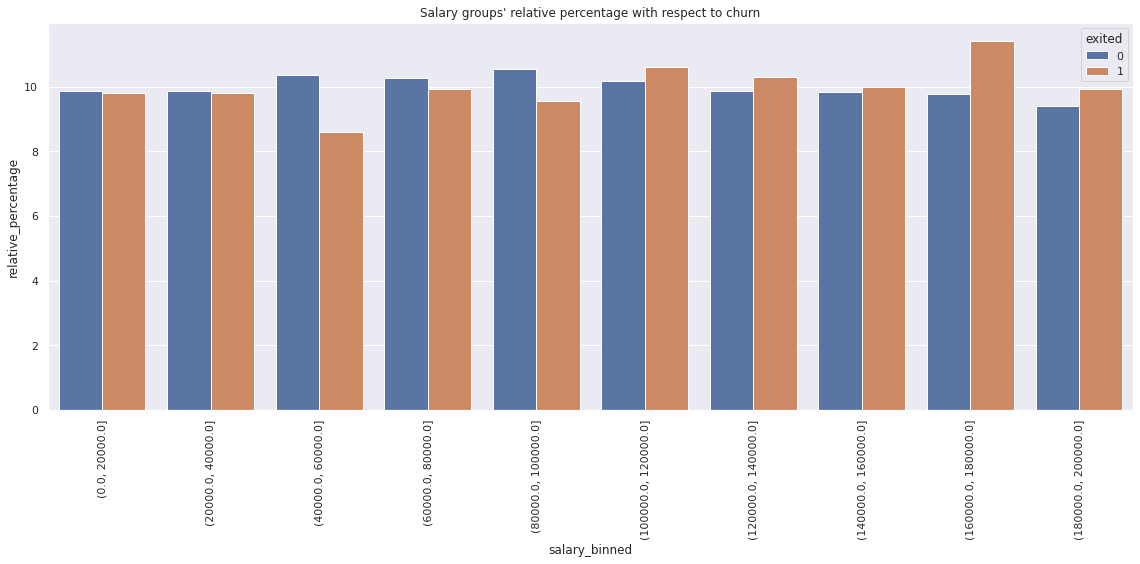

In [136]:
plt.subplots(figsize=(16,8))
sns.barplot(x='salary_binned', y='relative_percentage', hue='exited', data=aux101).\
set_title("Salary groups' relative percentage with respect to churn");
plt.xticks(rotation=90);
save_fig('04_salary_relative_percentage')

In [112]:
aux102 = aux101[aux101['exited']==1]
aux102.sort_values('relative_percentage', ascending=False)

salary_binned  exited  clients  relative_percentage
17  (160000.0, 180000.0]       1      186            11.411043
11  (100000.0, 120000.0]       1      173            10.613497
13  (120000.0, 140000.0]       1      168            10.306748
15  (140000.0, 160000.0]       1      163            10.000000
7     (60000.0, 80000.0]       1      162             9.938650
19  (180000.0, 200000.0]       1      162             9.938650
1         (0.0, 20000.0]       1      160             9.815951
3     (20000.0, 40000.0]       1      160             9.815951
9    (80000.0, 100000.0]       1      156             9.570552
5     (40000.0, 60000.0]       1      140             8.588957

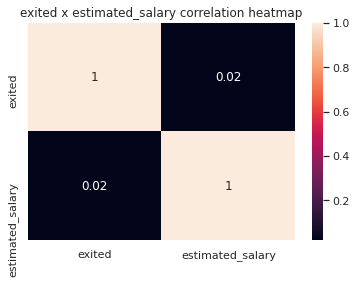

In [118]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['estimated_salary']]);

- The estimated salary is evenly distributed for both active clients (exited = 0) and clients in churn (exited = 1), therefore it is hard to detect a variation which could indicate client in churn. The correlation heatmap confirms this with a low coefficient of 0.02.
- The salary relative percentage plot shows that clients with salary greater than 100,000, the relative percentage of churn (orange bars) is always greater than the relative percentage of active members (blue bars).
- Also, for clients in churn, the top four salary relative percentage are from range values greater than 100,000.
- The relative percentage of salaries greater than 100,000 is 52.23%.
- Therefore, the hypothesis is true: churn occur for clients with high salary.

### H2. Churn should occur for clients with high balance
**TRUE** Churn occur for clients with high balance.

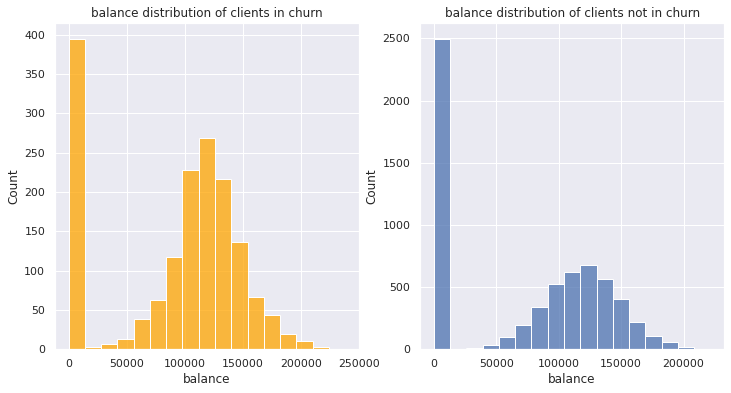

In [21]:
# set dataframes for exited = 0 and exited = 1
aux2_1 = df4[df4['exited']==0]
aux2_2 = df4[df4['exited']==1]

# set up figure size
plt.subplots(figsize=(12,6))

# plot balance distribution of clients in churn
plt.subplot(1,2,1)
sns.histplot(aux2_2['balance'], color='orange').set_title('balance distribution of clients in churn');

# plot balance distribution of clients not in churn
plt.subplot(1,2,2)
sns.histplot(aux2_1['balance']).set_title('balance distribution of clients not in churn');

Saving figure 04_balance_density_distribution


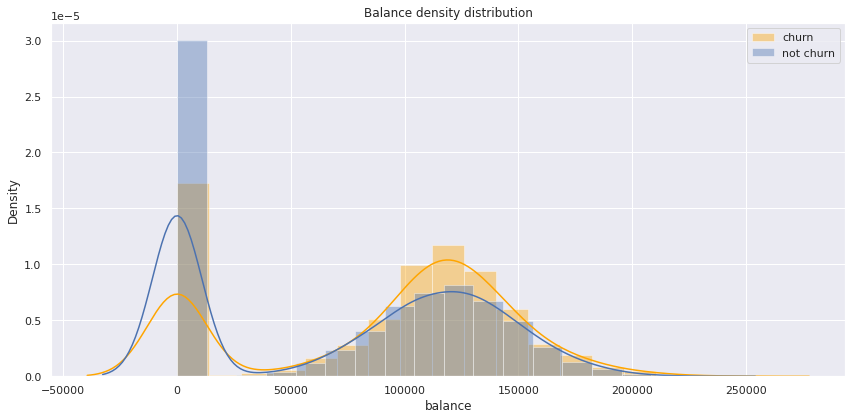

In [22]:
# plot balance density distribution for exited = 0 and exited = 1
plt.subplots(figsize=(12,6))
sns.distplot(aux2_2['balance'], color='orange', label='churn')
sns.distplot(aux2_1['balance'], label='not churn');
plt.legend()
plt.title('Balance density distribution');
save_fig('04_balance_density_distribution')

In [155]:
aux2_1['balance'].value_counts(normalize=True)*100

0.00         39.215071
130170.82     0.031397
117700.86     0.015699
65848.36      0.015699
159863.90     0.015699
               ...    
120727.97     0.015699
149436.73     0.015699
164003.05     0.015699
82729.49      0.015699
83624.55      0.015699
Name: balance, Length: 3872, dtype: float64

In [151]:
aux2_2['balance'].value_counts(normalize=True)*100

0.00         24.110429
200724.96     0.061350
101016.53     0.061350
154586.92     0.061350
113882.33     0.061350
               ...    
127655.22     0.061350
92805.72      0.061350
159203.71     0.061350
113755.78     0.061350
138547.97     0.061350
Name: balance, Length: 1238, dtype: float64

In [158]:
aux2_1['balance'].describe()

count      6370.000000
mean      72554.143826
std       62833.344641
min           0.000000
25%           0.000000
50%       91715.195000
75%      126221.812500
max      221532.800000
Name: balance, dtype: float64

In [159]:
aux2_2['balance'].describe()

count      1630.000000
mean      91337.278417
std       57817.821362
min           0.000000
25%       44091.025000
50%      109252.725000
75%      131200.062500
max      238387.560000
Name: balance, dtype: float64

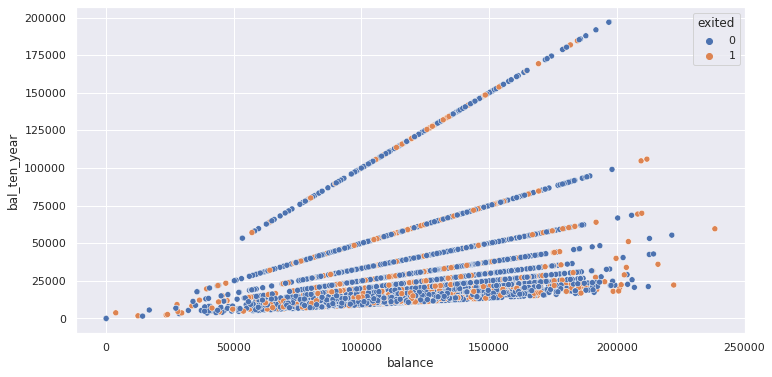

In [163]:
# balance x bal_ten_year scatterplot
plt.subplots(figsize=(12,6))
sns.scatterplot(x='balance', y='bal_ten_year',hue='exited', data=df4);

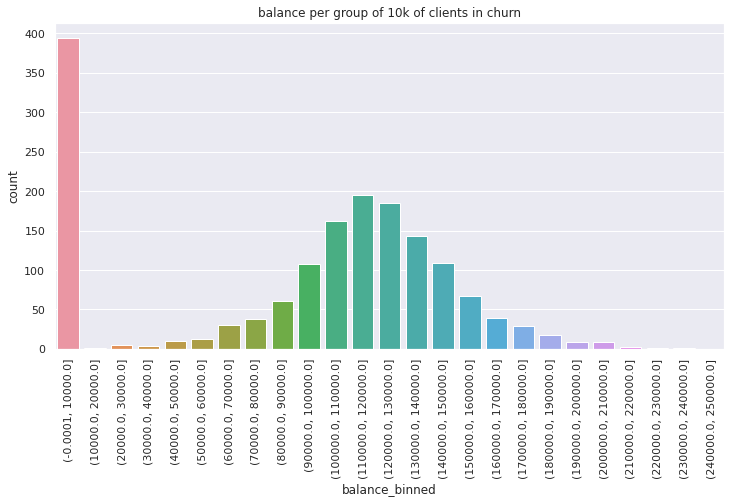

In [175]:
# plot balance binned values of clients in churn
bins1 = list(np.arange(-1e-4, 2.51e5, 10e3))
aux2_2['balance_binned'] = pd.cut(aux2_2['balance'], bins=bins1)
plt.subplots(figsize=(12,6))
sns.countplot(x='balance_binned', data=aux2_2).set_title("balance per group of 10k of clients in churn");
# rotate x axis
plt.xticks(rotation=90);

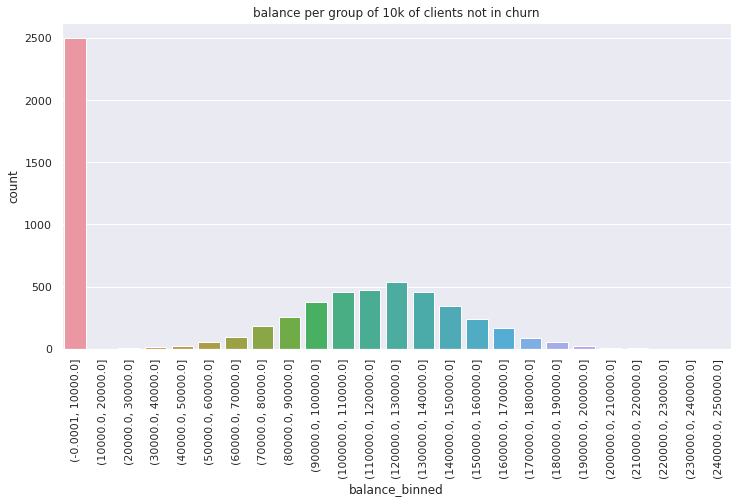

In [176]:
# plot balance binned values of clients not in churn
bins1 = list(np.arange(-1e-4, 2.51e5, 10e3))
aux2_1['balance_binned'] = pd.cut(aux2_1['balance'], bins=bins1)
plt.subplots(figsize=(12,6))
sns.countplot(x='balance_binned', data=aux2_1).set_title("balance per group of 10k of clients not in churn");
# rotate x axis
plt.xticks(rotation=90);

- Calculate the relative percentage of clients in churn and not in churn per balance.

In [180]:
# create new dataframe
aux200 = df4[['balance', 'exited']]
aux200['balance_binned'] = pd.cut(aux200['balance'], bins=bins1)

# new dataframe with balance_binned, exited and number of clients
aux201 = aux200[['balance_binned', 'balance', 'exited']].\
groupby(['balance_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux201.columns = ['balance_binned', 'exited', 'clients']

# sum of clients in churn
clients_in_churn = aux201[aux201['exited'] == 1]['clients'].sum()

# sum of clients not in churn
clients_not_churn = aux201[aux201['exited'] == 0]['clients'].sum()

# calculate the relative percentage of clients in churn and not in churn
aux201['relative_percentage'] = aux201.\
apply(lambda x: ((x['clients'] / clients_in_churn)*100) if x['exited'] == 1 else ((x['clients'] / clients_not_churn)*100), axis=1)

aux201

balance_binned  exited  clients  relative_percentage
0     (-0.0001, 10000.0]       0   2498.0            39.215071
1     (-0.0001, 10000.0]       1    394.0            24.171779
2     (10000.0, 20000.0]       0      2.0             0.031397
3     (10000.0, 20000.0]       1      1.0             0.061350
4     (20000.0, 30000.0]       0      3.0             0.047096
5     (20000.0, 30000.0]       1      5.0             0.306748
6     (30000.0, 40000.0]       0     11.0             0.172684
7     (30000.0, 40000.0]       1      4.0             0.245399
8     (40000.0, 50000.0]       0     25.0             0.392465
9     (40000.0, 50000.0]       1     10.0             0.613497
10    (50000.0, 60000.0]       0     53.0             0.832025
11    (50000.0, 60000.0]       1     12.0             0.736196
12    (60000.0, 70000.0]       0     98.0             1.538462
13    (60000.0, 70000.0]       1     30.0             1.840491
14    (70000.0, 80000.0]       0    186.0             2.919937
15    (70000.0, 80000.0]       1     38.0             2.331288
16    (80000.0, 90000.0]       0    257.0             4.034537
17    (80000.0, 90000.0]       1     60.0             3.680982
18   (90000.0, 100000.0]       0    377.0             5.918367
19   (90000.0, 100000.0]       1    108.0             6.625767
20  (100000.0, 110000.0]       0    456.0             7.158556
21  (100000.0, 110000.0]       1    162.0             9.938650
22  (110000.0, 120000.0]       0    473.0             7.425432
23  (110000.0, 120000.0]       1    195.0            11.963190
24  (120000.0, 130000.0]       0    540.0             8.477237
25  (120000.0, 130000.0]       1    185.0            11.349693
26  (130000.0, 140000.0]       0    455.0             7.142857
27  (130000.0, 140000.0]       1    143.0             8.773006
28  (140000.0, 150000.0]       0    341.0             5.353218
29  (140000.0, 150000.0]       1    109.0             6.687117
30  (150000.0, 160000.0]       0    243.0             3.814757
31  (150000.0, 160000.0]       1     67.0             4.110429
32  (160000.0, 170000.0]       0    170.0             2.668760
33  (160000.0, 170000.0]       1     39.0             2.392638
34  (170000.0, 180000.0]       0     89.0             1.397174
35  (170000.0, 180000.0]       1     29.0             1.779141
36  (180000.0, 190000.0]       0     55.0             0.863422
37  (180000.0, 190000.0]       1     18.0             1.104294
38  (190000.0, 200000.0]       0     26.0             0.408163
39  (190000.0, 200000.0]       1      8.0             0.490798
40  (200000.0, 210000.0]       0      7.0             0.109890
41  (200000.0, 210000.0]       1      9.0             0.552147
42  (210000.0, 220000.0]       0      4.0             0.062794
43  (210000.0, 220000.0]       1      2.0             0.122699
44  (220000.0, 230000.0]       0      1.0             0.015699
45  (220000.0, 230000.0]       1      1.0             0.061350
46  (230000.0, 240000.0]       0      NaN                  NaN
47  (230000.0, 240000.0]       1      1.0             0.061350
48  (240000.0, 250000.0]       0      NaN                  NaN
49  (240000.0, 250000.0]       1      NaN                  NaN

- Plot the relative percentage of clients in churn and not in churn per balance.

Saving figure 04_balance_relative_percentage


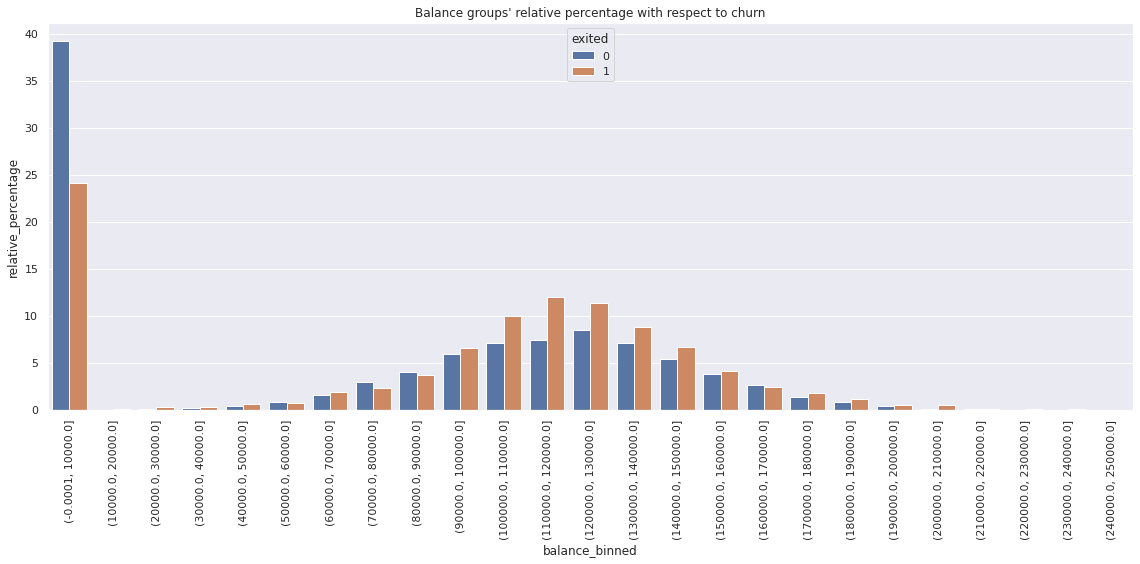

In [181]:
plt.subplots(figsize=(16,8))
sns.barplot(x='balance_binned', y='relative_percentage', hue='exited', data=aux201).\
set_title("Balance groups' relative percentage with respect to churn");
plt.xticks(rotation=90);
save_fig('04_balance_relative_percentage')

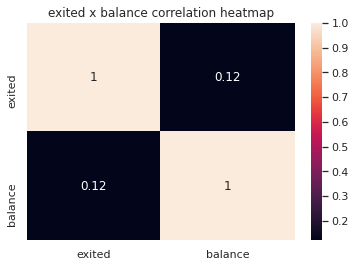

In [182]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['balance']]);

- 39% of clients not in churn have balance equal to zero. 24% of clients in churn have balance equal to zero.
- The balance density distribution shows that as the balance value increases, the relative proportion of clients in churn is greater than the proportion of clients not in churn.
- The Balance group's relative percentage barplot shows that from balance 90,000 on, the relative percentage of clients in churn is greater than the relative percentage of clients not in churn.
- The correlation heatmap shows a correlation coefficient of 0.12 between balance and exited feature.
- The balance x bal_ten_year scatterplot doesn't show a clear pattern of clients in churn.
- Therefore, the hypothesis is true: churn occur for clients with high balance.

### H3. Churn should occur more for women than men.
**TRUE** Churn occur more for women than men.

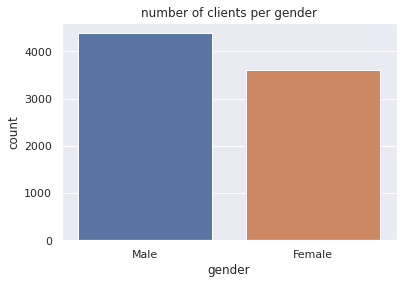

In [207]:
# plot gender distribution
sns.countplot(x='gender', data=df4).set_title('number of clients per gender');

Saving figure 04_gender_churn


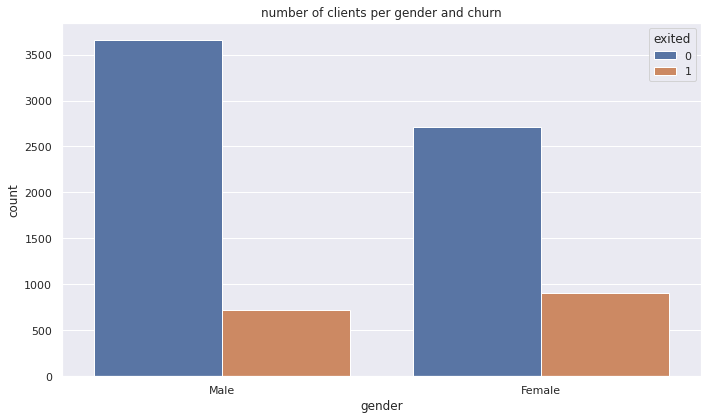

In [212]:
# plot number of clients per gender and churn
plt.subplots(figsize=(10,6))
sns.countplot(x='gender', hue='exited', data=df4).set_title('number of clients per gender and churn');
save_fig('04_gender_churn')

In [214]:
# define dataframe for exited = 0 and exited = 1
aux3_1 = df4[df4['exited']==0]
aux3_2 = df4[df4['exited']==1]

Saving figure 04_gender_percentage


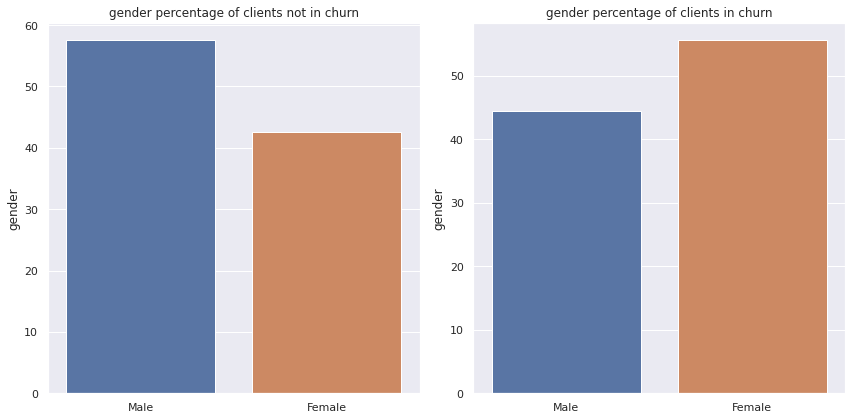

In [222]:
# plot gender distribution percentage

# set up figure size
plt.subplots(figsize=(12,6))

# 1st plot: gender percentage of clients not in churn
plt.subplot(1,2,1)
perc_not_churn = aux3_1['gender'].value_counts(normalize=True)*100
sns.barplot(x=perc_not_churn.index, y=perc_not_churn).set_title('gender percentage of clients not in churn');

# 2nd plot: gender percentage of clients in churn
plt.subplot(1,2,2)
perc_churn = aux3_2['gender'].value_counts(normalize=True)*100
sns.barplot(x=perc_churn.index, y=perc_churn, order=['Male', 'Female']).set_title('gender percentage of clients in churn');
save_fig('04_gender_percentage')

In [224]:
perc_not_churn = aux3_1['gender'].value_counts(normalize=True)*100
perc_not_churn

Male      57.503925
Female    42.496075
Name: gender, dtype: float64

In [225]:
perc_churn = aux3_2['gender'].value_counts(normalize=True)*100
perc_churn

Female    55.582822
Male      44.417178
Name: gender, dtype: float64

- As previously checked, 4387 clients (54.8%) are men and 3613 clients (45.2%) are women.
- For clients not in churn, 57.5% are men and 42.5% are women: the proportion of men is greater than the proportion considering the whole dataset (54.8%).
- For clients in churn, 55.6% are women and 44.4% are men: the proportion is inverse compared to the whole dataset and for client not in churn, as for both of them the proportion of men is greater than the proportion of women.
- Therefore, the hypothesis is true: churn occur more for women than men.

### H4. Churn should occur for clients with one product.
**TRUE** Churn occur for clients with one product.

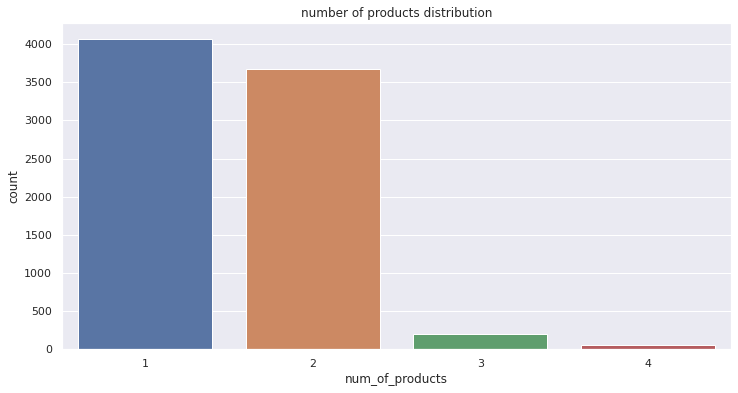

In [262]:
# number of products countplot
# set up figure size
plt.subplots(figsize=(12,6))
sns.countplot(x='num_of_products', data=df4).set_title('number of products distribution');

In [263]:
df4['num_of_products'].value_counts(normalize=True)*100

1    50.8875
2    45.9000
3     2.5875
4     0.6250
Name: num_of_products, dtype: float64

Saving figure 04_products_barplot


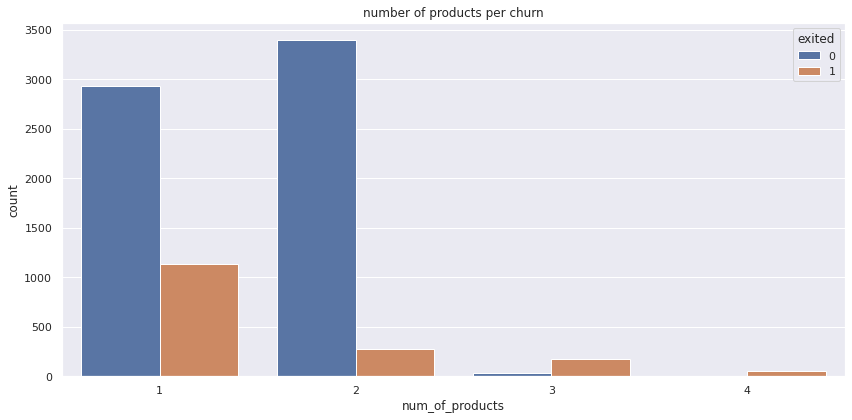

In [228]:
# number of products countplot
# set up figure size
plt.subplots(figsize=(12,6))
sns.countplot(x='num_of_products', hue='exited', data=df4).set_title('number of products per churn');
save_fig('04_products_barplot')

Saving figure 04_num_products_percentage


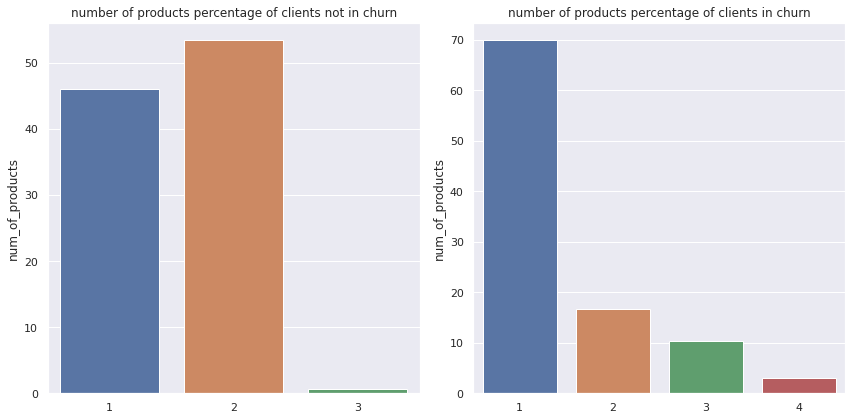

In [319]:
# define dataframe for exited = 0 and exited = 1
aux4_1 = df4[df4['exited']==0]
aux4_2 = df4[df4['exited']==1]

# plot percentages

# set up figure size
plt.subplots(figsize=(12,6))

# 1st plot
plt.subplot(1,2,1)
prod_perc_not_churn = aux4_1['num_of_products'].value_counts(normalize=True)*100
sns.barplot(x=prod_perc_not_churn.index, y=prod_perc_not_churn).\
set_title('number of products percentage of clients not in churn');

# 2nd plot
plt.subplot(1,2,2)
prod_perc_churn = aux4_2['num_of_products'].value_counts(normalize=True)*100
sns.barplot(x=prod_perc_churn.index, y=prod_perc_churn).\
set_title('number of products percentage of clients in churn');

save_fig('04_num_products_percentage')

In [232]:
prod_perc_not_churn

2    53.390895
1    46.028257
3     0.580848
Name: num_of_products, dtype: float64

In [233]:
prod_perc_churn

1    69.877301
2    16.625767
3    10.429448
4     3.067485
Name: num_of_products, dtype: float64

- Plot churn ratio per number of products

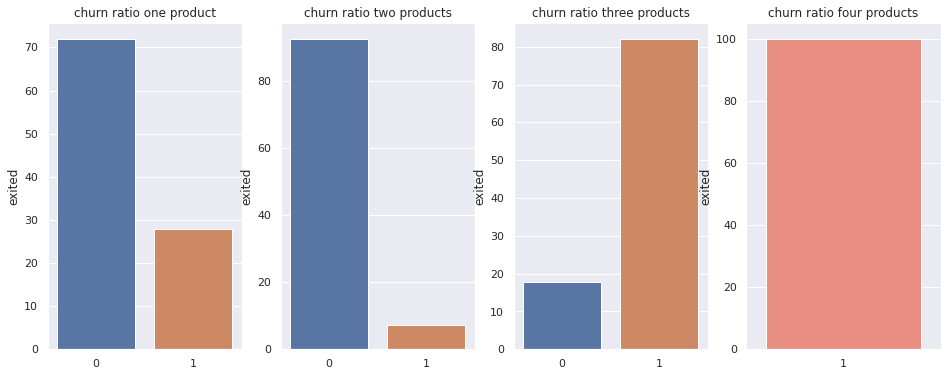

In [258]:
# set up figure size
plt.subplots(figsize=(16,6))

# 1st plot: number of products = 1
plt.subplot(1,4,1)
aux4_3 = df4[df4['num_of_products']==1]
churn_prod_1 = aux4_3['exited'].value_counts(normalize=True)*100
sns.barplot(x=churn_prod_1.index, y=churn_prod_1).set_title('churn ratio one product');

# 2nd plot: number of products = 2
plt.subplot(1,4,2)
aux4_4 = df4[df4['num_of_products']==2]
churn_prod_2 = aux4_4['exited'].value_counts(normalize=True)*100
sns.barplot(x=churn_prod_2.index, y=churn_prod_2).set_title('churn ratio two products');

# 3rd plot: number of products = 3
plt.subplot(1,4,3)
aux4_5 = df4[df4['num_of_products']==3]
churn_prod_3 = aux4_5['exited'].value_counts(normalize=True)*100
sns.barplot(x=churn_prod_3.index, y=churn_prod_3).set_title('churn ratio three products');

# 4th plot: number of products = 4
plt.subplot(1,4,4)
aux4_6 = df4[df4['num_of_products']==4]
churn_prod_4 = aux4_6['exited'].value_counts(normalize=True)*100
sns.barplot(x=churn_prod_4.index, y=churn_prod_4, color='salmon').set_title('churn ratio four products');

In [259]:
churn_prod_2

0    92.619826
1     7.380174
Name: exited, dtype: float64

- Plot number of products relative percentage of clients not in churn and in churn

In [255]:
# new dataframe with num_of_products, exited and number of clients
aux400 = df4[['num_of_products','balance', 'exited']].groupby(['num_of_products', 'exited']).count().reset_index()
aux400.columns = ['num_of_products', 'exited', 'num_clients']

# sum of clients in churn
sum_churn = aux400[aux400['exited']==1]['num_clients'].sum()

# sum of clients not in churn
sum_not_churn = aux400[aux400['exited']==0]['num_clients'].sum()

# calculate relative percentage
aux400['relative_percentage'] = aux400.\
apply(lambda x: ((x['num_clients'] / sum_churn)*100) if x['exited'] == 1 else ((x['num_clients'] / sum_not_churn)*100), axis=1)

aux400

num_of_products  exited  num_clients  relative_percentage
0                1       0         2932            46.028257
1                1       1         1139            69.877301
2                2       0         3401            53.390895
3                2       1          271            16.625767
4                3       0           37             0.580848
5                3       1          170            10.429448
6                4       1           50             3.067485

- Plot number of products relative percentage

Saving figure 04_num_products_relative_percentage


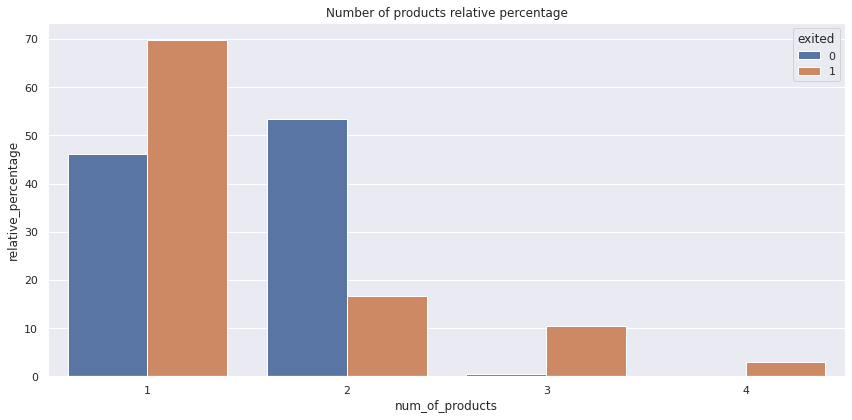

In [320]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.barplot(x='num_of_products', y='relative_percentage', hue='exited', data=aux400).\
set_title('Number of products relative percentage');
save_fig('04_num_products_relative_percentage')

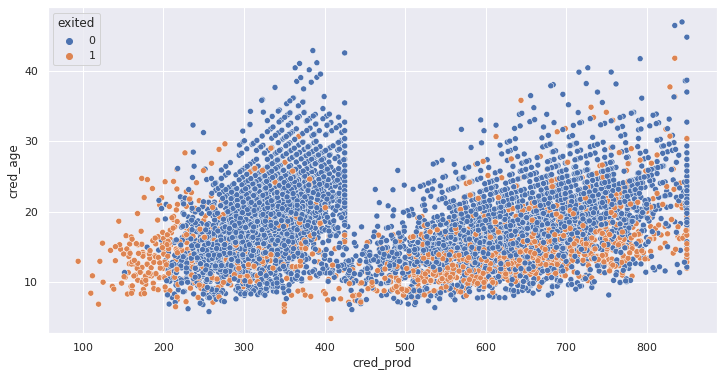

In [306]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='cred_prod', y='cred_age', hue='exited', data=df4);

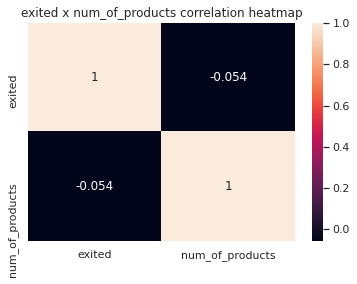

In [422]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['num_of_products']]);

- Clients in churn: almost 70% have one product, 16.6% have two products, 10.4% have three products and 3% have four products.
- Clients not in churn: 53.4% have two products, 46% have one product, 0.6% have three products and none have four products.
- In absolute values, there are more clients in churn with three and four products than clients not in churn with three products. There are no clients not in churn with four products.
- Considering all clients with one product,  more than 70% are not in churn.
- Considering all clients with two products, more than 90% are not in churn.
- Considering all clients with three products, more than 80% are in churn.
- All clients that have four products are in churn.
- More than 50% of the clients have only one product.
- Therefore, the hypothesis is true: churn occur for clients with one product.

### H5. Churn should not occur for active members.
**TRUE** Churn does not occur for active members.

In [308]:
df4['is_active_member'].value_counts()

1    4119
0    3881
Name: is_active_member, dtype: int64

In [309]:
df4['is_active_member'].value_counts(normalize=True)*100

1    51.4875
0    48.5125
Name: is_active_member, dtype: float64

- Plot is active member per churn

Saving figure 04_active_member_countplot


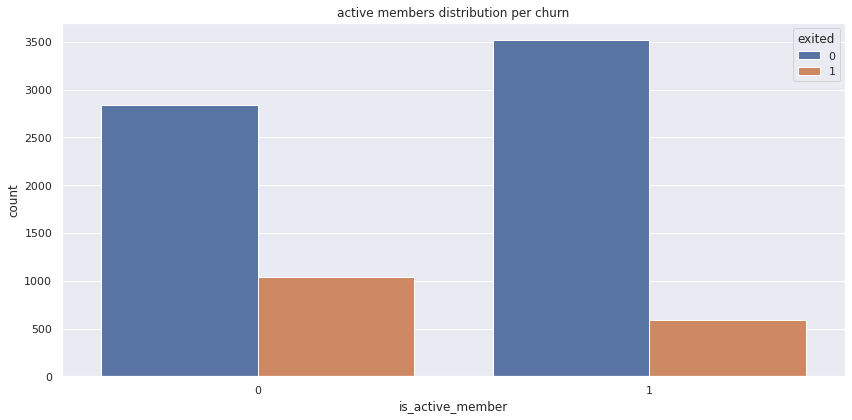

In [322]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.countplot(x='is_active_member', hue='exited', data=df4).set_title('active members distribution per churn');
save_fig('04_active_member_countplot')

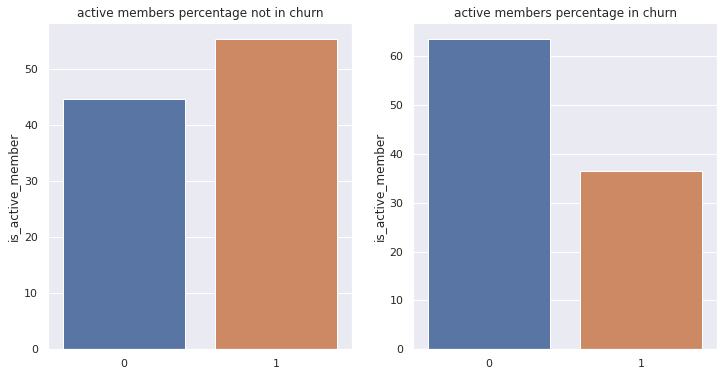

In [313]:
# define dataframes exited = 0 and exited = 1
aux5_1 = df4[df4['exited']==0]
aux5_2 = df4[df4['exited']==1]

# plot percentages

# set up figure size
plt.subplots(figsize=(12,6))

# 1st plot
plt.subplot(1,2,1)
active_perc_not_churn = aux5_1['is_active_member'].value_counts(normalize=True)*100
sns.barplot(x=active_perc_not_churn.index, y=active_perc_not_churn).\
set_title('active members percentage not in churn');

# 2nd plot
plt.subplot(1,2,2)
active_perc_churn = aux5_2['is_active_member'].value_counts(normalize=True)*100
sns.barplot(x=active_perc_churn.index, y=active_perc_churn).\
set_title('active members percentage in churn');

In [314]:
active_perc_not_churn

1    55.33752
0    44.66248
Name: is_active_member, dtype: float64

In [315]:
active_perc_churn

0    63.558282
1    36.441718
Name: is_active_member, dtype: float64

In [317]:
# new dataframe with is_active_member, exited and number of clients
aux500 = df4[['is_active_member','balance', 'exited']].groupby(['is_active_member', 'exited']).count().reset_index()
aux500.columns = ['is_active_member', 'exited', 'num_clients']

# sum of clients in churn
sum_churn = aux500[aux500['exited']==1]['num_clients'].sum()

# sum of clients not in churn
sum_not_churn = aux500[aux500['exited']==0]['num_clients'].sum()

# calculate relative percentage
aux500['relative_percentage'] = aux500.\
apply(lambda x: ((x['num_clients'] / sum_churn)*100) if x['exited'] == 1 else ((x['num_clients'] / sum_not_churn)*100), axis=1)

aux500

is_active_member  exited  num_clients  relative_percentage
0                 0       0         2845            44.662480
1                 0       1         1036            63.558282
2                 1       0         3525            55.337520
3                 1       1          594            36.441718

- Plot is_active_member relative percentage

Saving figure 04_active_members_relative_percentage


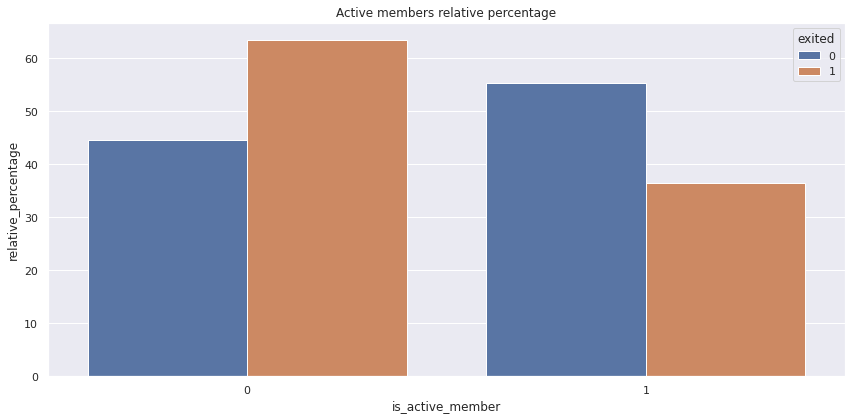

In [323]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.barplot(x='is_active_member', y='relative_percentage', hue='exited', data=aux500).\
set_title('Active members relative percentage');
save_fig('04_active_members_relative_percentage')

- 51.5% of the clients are active members. 48.5% of the clients are not active members.
- Clients not in churn: 55.3% are active members. 44.7% are not active members.
- Clients in churn: 63.6% are not active members. 36.4% are active members, which corresponds to 594 clients, that is, even though they are active members, they decided to exit the bank.
- Therefore, the hypothesis is true: churn does not occur for active members.

### H6. Churn should not occur for clients with credit card.
**TRUE** Churn does not occur for clients with credit card.

In [324]:
df4['has_cr_card'].value_counts()

1    5670
0    2330
Name: has_cr_card, dtype: int64

In [325]:
df4['has_cr_card'].value_counts(normalize=True)*100

1    70.875
0    29.125
Name: has_cr_card, dtype: float64

- Plot clients with credit card distribution

Saving figure 04_credit_card_countplot


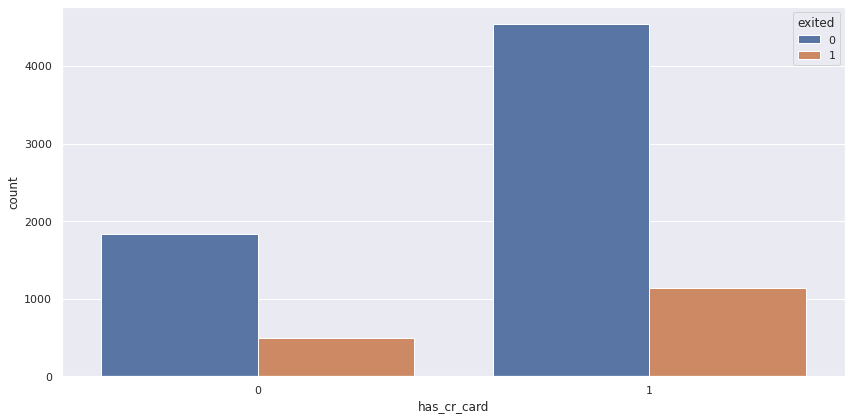

In [336]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.countplot(x='has_cr_card', hue='exited', data=df4);
save_fig('04_credit_card_countplot')

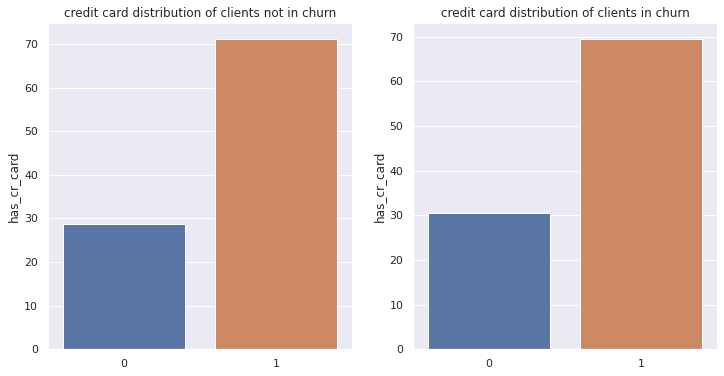

In [330]:
# define dataframe for exited = 0 and exited = 1
aux6_1 = df4[df4['exited']==0]
aux6_2 = df4[df4['exited']==1]

# plot percentages

# set up figure size
plt.subplots(figsize=(12,6))

# 1st plot: credit card distribution of clients not in churn
plt.subplot(1,2,1)
card_perc_not_churn = aux6_1['has_cr_card'].value_counts(normalize=True)*100
sns.barplot(x=card_perc_not_churn.index, y=card_perc_not_churn).\
set_title('credit card distribution of clients not in churn');

# 2nd plot: credit card distribution of clients in churn
plt.subplot(1,2,2)
card_perc_churn = aux6_2['has_cr_card'].value_counts(normalize=True)*100
sns.barplot(x=card_perc_churn.index, y=card_perc_churn).\
set_title('credit card distribution of clients in churn');

In [331]:
card_perc_not_churn

1    71.208791
0    28.791209
Name: has_cr_card, dtype: float64

In [332]:
card_perc_churn

1    69.570552
0    30.429448
Name: has_cr_card, dtype: float64

In [333]:
# new dataframe with has_cr_card, exited and number of clients
aux600 = df4[['has_cr_card','balance', 'exited']].groupby(['has_cr_card', 'exited']).count().reset_index()
aux600.columns = ['has_cr_card', 'exited', 'num_clients']

# sum of clients in churn
sum_churn = aux600[aux600['exited']==1]['num_clients'].sum()

# sum of clients not in churn
sum_not_churn = aux600[aux600['exited']==0]['num_clients'].sum()

# calculate relative percentage
aux600['relative_percentage'] = aux600.\
apply(lambda x: ((x['num_clients'] / sum_churn)*100) if x['exited'] == 1 else ((x['num_clients'] / sum_not_churn)*100), axis=1)

aux600

has_cr_card  exited  num_clients  relative_percentage
0            0       0         1834            28.791209
1            0       1          496            30.429448
2            1       0         4536            71.208791
3            1       1         1134            69.570552

- Plot has_cr_card relative percentage

Saving figure 04_credit_card_relative_percentage


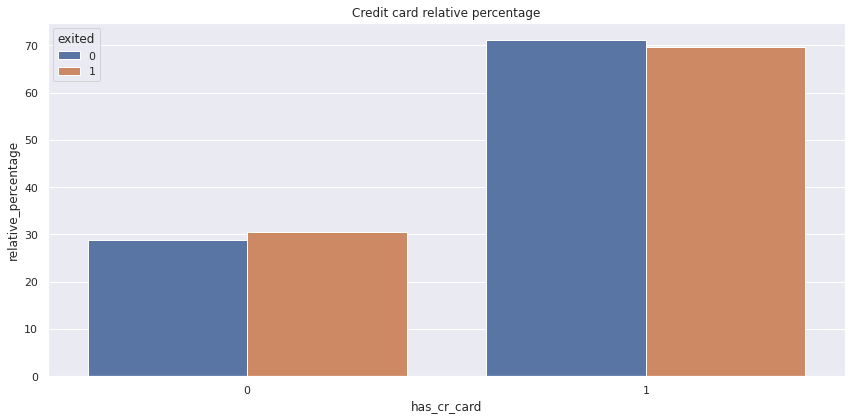

In [335]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.barplot(x='has_cr_card', y='relative_percentage', hue='exited', data=aux600).\
set_title('Credit card relative percentage');
save_fig('04_credit_card_relative_percentage')

- 70.9% of the customers have credit card.
- Clients not in churn: 71.2% have credit card. 28.8% have not credit card.
- Clients in churn: 69.6% have credit card. 30.4% have not credit card.
- The proportion of clients in churn without credit card (30.4%) is greater than the proportion of clients not in churn without credit card (28.8%).
- The proportion of clients not in churn with credit card (71.2%) is greater than the proportion of clients in churn with credit card (69.6%).
- Therefore, the hypothesis is True: churn does not occur for clients with credit card.

### H7. Churn should occur for clients with a low credit score.
**TRUE** Churn occur for clients with a low credit score.

Saving figure 04_credit_score_density_distribution


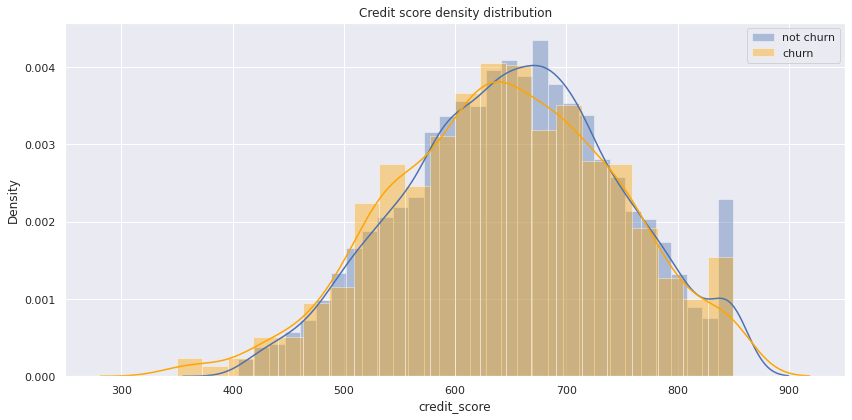

In [343]:
# set dataframes for exited = 0 and exited = 1
aux7_1 = df4[df4['exited']==0]
aux7_2 = df4[df4['exited']==1]

# set up figure size
plt.subplots(figsize=(12,6))

sns.distplot(aux7_1['credit_score'], label='not churn');
sns.distplot(aux7_2['credit_score'], color='orange', label='churn');
plt.title('Credit score density distribution');
plt.legend();
save_fig('04_credit_score_density_distribution')

In [344]:
df4['credit_score'].describe()

count    8000.000000
mean      650.752500
std        96.596432
min       350.000000
25%       584.000000
50%       652.000000
75%       717.000000
max       850.000000
Name: credit_score, dtype: float64

- Plot credit score binned

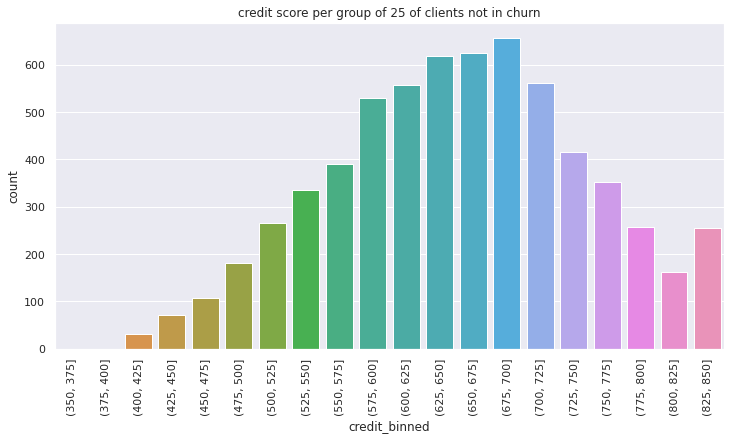

In [350]:
# set binned credit score
bins7 = list(np.arange(350, 851, 25))

aux7_1['credit_binned'] = pd.cut(aux7_1['credit_score'], bins=bins7)

plt.subplots(figsize=(12,6))

sns.countplot(x='credit_binned', data=aux7_1).set_title("credit score per group of 25 of clients not in churn");
# rotate x axis
plt.xticks(rotation=90);

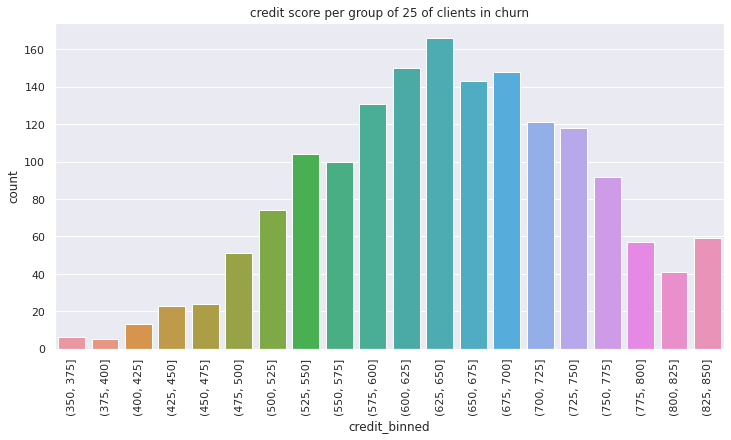

In [351]:
aux7_2['credit_binned'] = pd.cut(aux7_2['credit_score'], bins=bins7)

plt.subplots(figsize=(12,6))

sns.countplot(x='credit_binned', data=aux7_2).set_title("credit score per group of 25 of clients in churn");
# rotate x axis
plt.xticks(rotation=90);

- Calculate the relative percentage of clients in churn and not in churn per credit score.

In [352]:
# create new dataframe
aux700 = df4[['credit_score', 'exited']]
aux700['credit_binned'] = pd.cut(aux700['credit_score'], bins=bins7)

# new dataframe with credit_binned, exited and number of clients
aux701 = aux700[['credit_binned', 'credit_score', 'exited']].\
groupby(['credit_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux701.columns = ['credit_binned', 'exited', 'clients']

# sum of clients in churn
clients_in_churn = aux701[aux701['exited'] == 1]['clients'].sum()

# sum of clients not in churn
clients_not_churn = aux701[aux701['exited'] == 0]['clients'].sum()

# calculate the relative percentage of clients in churn and not in churn
aux701['relative_percentage'] = aux701.\
apply(lambda x: ((x['clients'] / clients_in_churn)*100) if x['exited'] == 1 else ((x['clients'] / clients_not_churn)*100), axis=1)

aux701

credit_binned  exited  clients  relative_percentage
0     (350, 375]       0      NaN                  NaN
1     (350, 375]       1      6.0             0.369004
2     (375, 400]       0      NaN                  NaN
3     (375, 400]       1      5.0             0.307503
4     (400, 425]       0     30.0             0.470958
5     (400, 425]       1     13.0             0.799508
6     (425, 450]       0     72.0             1.130298
7     (425, 450]       1     23.0             1.414514
8     (450, 475]       0    106.0             1.664050
9     (450, 475]       1     24.0             1.476015
10    (475, 500]       0    181.0             2.841444
11    (475, 500]       1     51.0             3.136531
12    (500, 525]       0    265.0             4.160126
13    (500, 525]       1     74.0             4.551046
14    (525, 550]       0    335.0             5.259027
15    (525, 550]       1    104.0             6.396064
16    (550, 575]       0    390.0             6.122449
17    (550, 575]       1    100.0             6.150062
18    (575, 600]       0    530.0             8.320251
19    (575, 600]       1    131.0             8.056581
20    (600, 625]       0    557.0             8.744113
21    (600, 625]       1    150.0             9.225092
22    (625, 650]       0    619.0             9.717425
23    (625, 650]       1    166.0            10.209102
24    (650, 675]       0    624.0             9.795918
25    (650, 675]       1    143.0             8.794588
26    (675, 700]       0    656.0            10.298273
27    (675, 700]       1    148.0             9.102091
28    (700, 725]       0    561.0             8.806907
29    (700, 725]       1    121.0             7.441574
30    (725, 750]       0    416.0             6.530612
31    (725, 750]       1    118.0             7.257073
32    (750, 775]       0    353.0             5.541601
33    (750, 775]       1     92.0             5.658057
34    (775, 800]       0    258.0             4.050235
35    (775, 800]       1     57.0             3.505535
36    (800, 825]       0    162.0             2.543171
37    (800, 825]       1     41.0             2.521525
38    (825, 850]       0    255.0             4.003140
39    (825, 850]       1     59.0             3.628536

- Plot the relative percentage of clients in churn and not in churn per credit score.

Saving figure 04_credit_score_relative_percentage


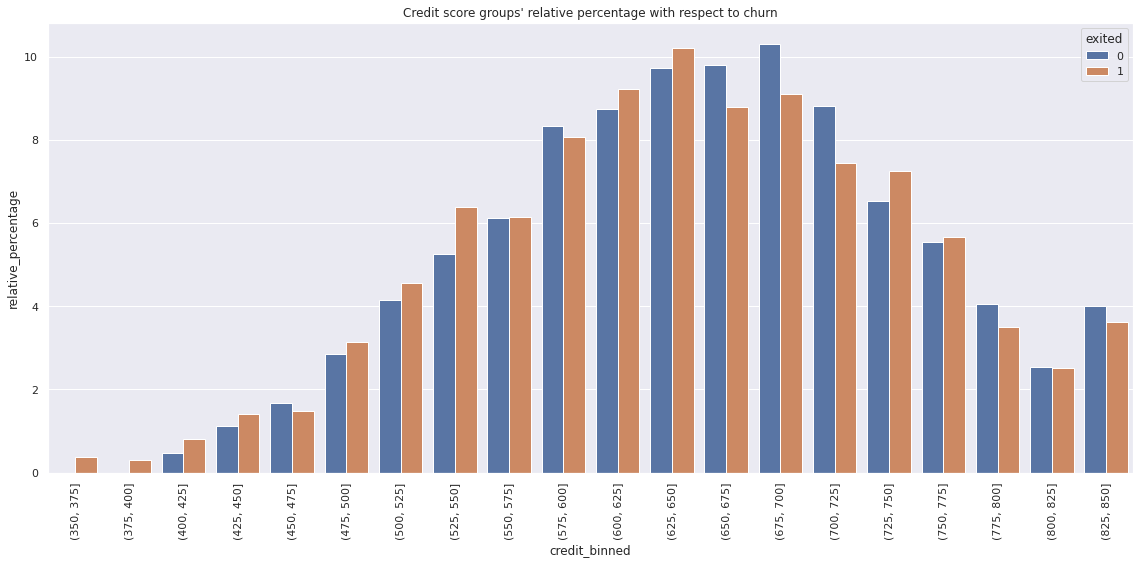

In [354]:
plt.subplots(figsize=(16,8))
sns.barplot(x='credit_binned', y='relative_percentage', hue='exited', data=aux701).\
set_title("Credit score groups' relative percentage with respect to churn");
plt.xticks(rotation=90);
save_fig('04_credit_score_relative_percentage')

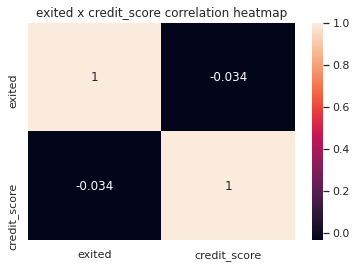

In [355]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['credit_score']]);

- Credit score x cred_ten_year scatter plot

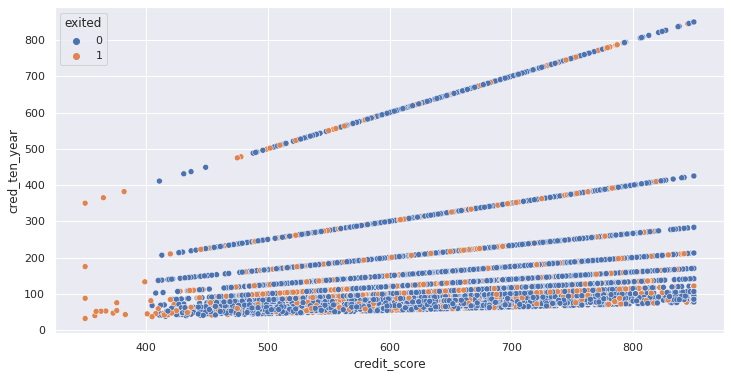

In [356]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='cred_ten_year', hue='exited', data=df4);

- Credit score x cred_age scatterplot

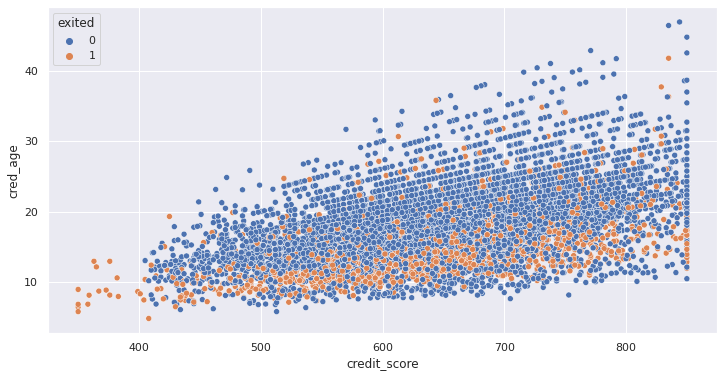

In [360]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='cred_age',hue='exited', data=df4);

- Credit score x age scatterplot

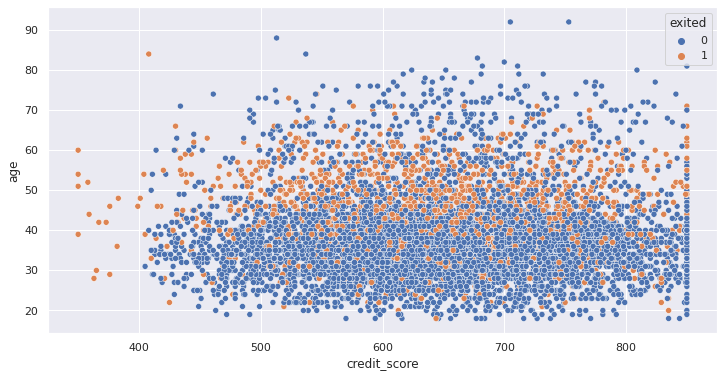

In [363]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='age',hue='exited', data=df4);

- The credit score density distribution shows that the distributions for churn and not churn clients are very similar. For credit score below 650 the churn proportion (orange) is greater than the not churn proportion (blue).
- The relative percentage barplot shows that for credit score greater than 650 the proportion of not churn is greater than the not churn in almost all credit score divisions.
- The correlation heatmap shows a corefficient between credit score and churn (exited) of -0.034.
- The credit score x cred_age scatterplot shows a slight churn pattern for cred_age below 20.
- The credit score x age scatterplot shows a slight churn pattern for age above 45.
- Therefore, the hypothesis is True: Churn occur for clients with a low credit score.

#### Additional scatterplots

- Credit score x age_ten_year scatterplot

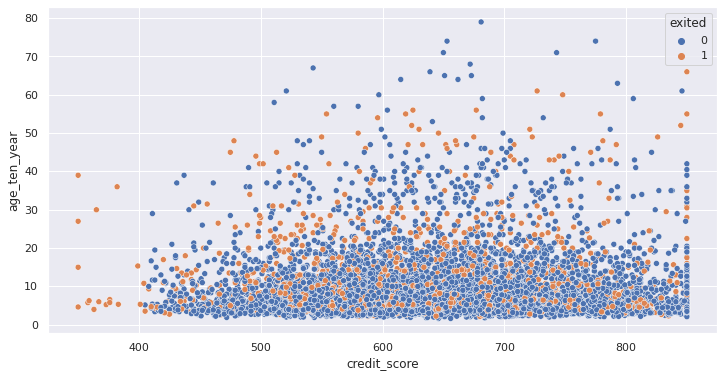

In [366]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='age_ten_year',hue='exited', data=df4);

- Credit score x bal_ten_year scatterplot

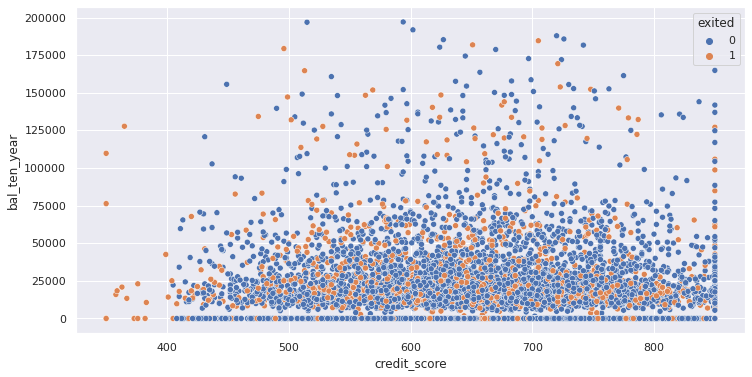

In [367]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='bal_ten_year',hue='exited', data=df4);

- Credit score x balance scatterplot

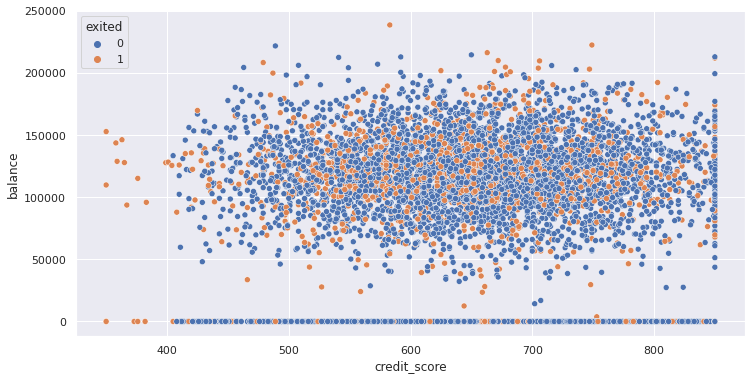

In [368]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='balance',hue='exited', data=df4);

- Credit score x estimated salary scatterplot

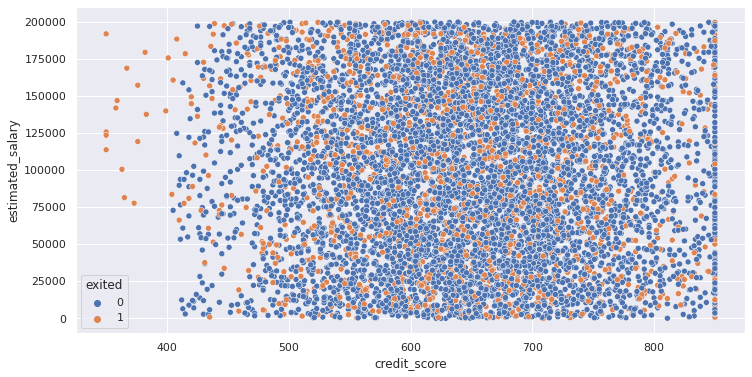

In [369]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='estimated_salary',hue='exited', data=df4);

- Credit score x amount scatterplot

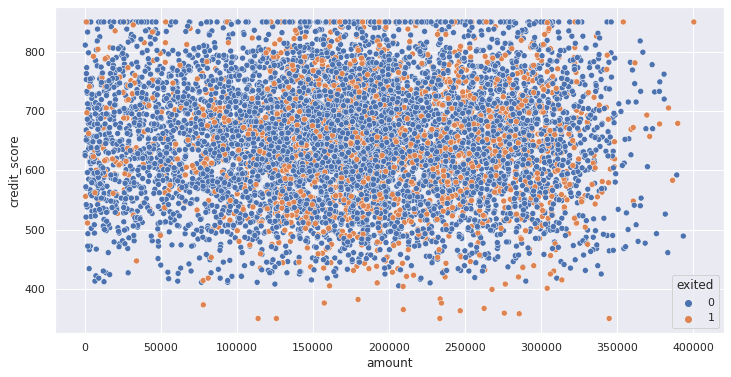

In [370]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='amount', y='credit_score',hue='exited', data=df4);

- Credit score x amount_credit scatterplot

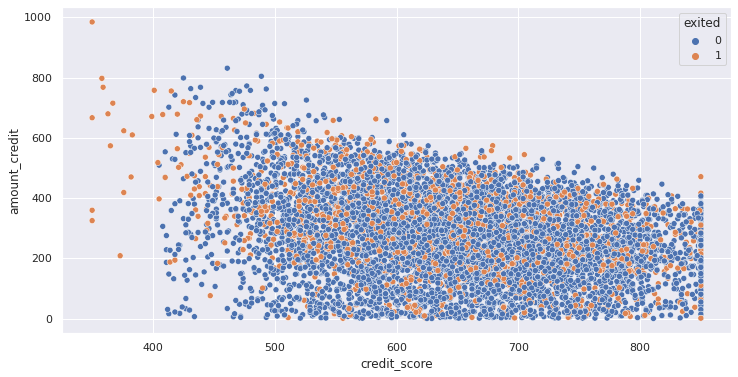

In [372]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='amount_credit',hue='exited', data=df4);

- Credit score x cred_prod scatterplot

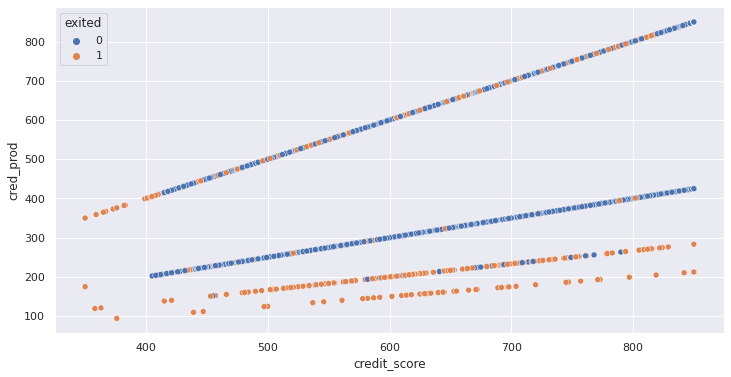

In [373]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='credit_score', y='cred_prod',hue='exited', data=df4);

### H8. Churn rate should be higher for clients from Spain.
**FALSE** Churn rate is lower for clients from Spain.

- Geography countplot per churn

Saving figure 04_geography_distribution_churn


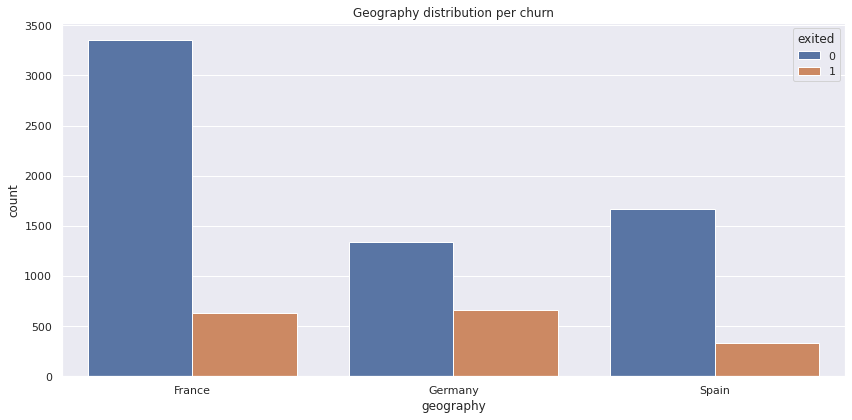

In [378]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.countplot(x='geography', hue='exited', data=df4).set_title('Geography distribution per churn');
save_fig('04_geography_distribution_churn')

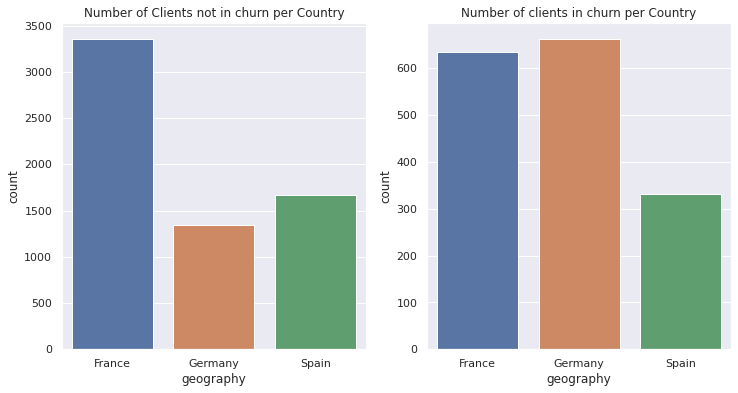

In [24]:
# set draframe for exited = 0 and exited = 1
aux8_1 = df4[df4['exited']==0]
aux8_2 = df4[df4['exited']==1]

# set up plot size
plt.subplots(figsize=(12,6))

# 1st plot
plt.subplot(1,2,1)
sns.countplot(x='geography', order=['France', 'Germany', 'Spain'], data=aux8_1).\
set_title('Number of Clients not in churn per Country');

# 2nd plot
plt.subplot(1,2,2)
sns.countplot(x='geography', data=aux8_2).set_title('Number of clients in churn per Country');

In [379]:
# new dataframe with geography, exited and number of clients
aux700 = df4[['geography','balance', 'exited']].groupby(['geography', 'exited']).count().reset_index()
aux700.columns = ['geography', 'exited', 'num_clients']

# sum of clients in churn
sum_churn = aux700[aux700['exited']==1]['num_clients'].sum()

# sum of clients not in churn
sum_not_churn = aux700[aux700['exited']==0]['num_clients'].sum()

# calculate relative percentage
aux700['relative_percentage'] = aux700.\
apply(lambda x: ((x['num_clients'] / sum_churn)*100) if x['exited'] == 1 else ((x['num_clients'] / sum_not_churn)*100), axis=1)

aux700

geography  exited  num_clients  relative_percentage
0    France       0         3358            52.715856
1    France       1          635            38.957055
2   Germany       0         1342            21.067504
3   Germany       1          663            40.674847
4     Spain       0         1670            26.216641
5     Spain       1          332            20.368098

- Plot geography relative percentage

Saving figure 04_geography_relative_percentage


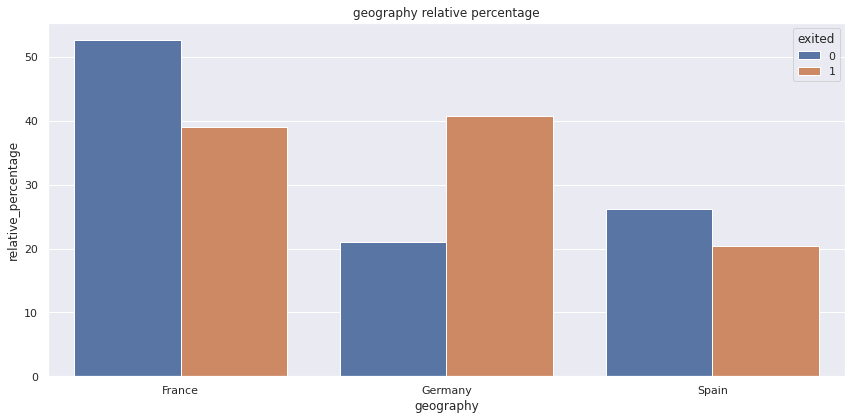

In [381]:
# set up figure size
plt.subplots(figsize=(12,6))

sns.barplot(x='geography', y='relative_percentage', hue='exited', data=aux700).\
set_title('geography relative percentage');
save_fig('04_geography_relative_percentage')

- Credit score x amount scatterplot

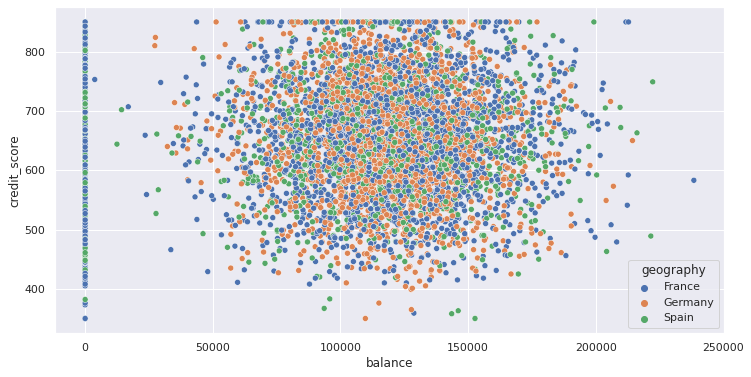

In [383]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='balance', y='credit_score', hue='geography', data=df4);

- As previously checked, 3993 clients (49.91%) are from France, 2005 clients (25.06%) are from Germany and 2002 clients (25.03%) are from Spain.
- Clients not in churn: 52.7% are from France, 26.2% are from Spain and 21.1% are from Germany. Compared to the whole dataset ratio, Germany decreased its proportion in aprox. 4%.
- Clients in churn: 40.7% are from Germany, 39% are from France and 20.3% are from Spain. Compared to the whole dataset ratio, Germany increased its proportion in aprox. 15%. Conversely, Spain's ratio decreased in aprox. 5%.
- Therefore, the hypothesis is False: Churn rate is lower for clients from Spain.

### H9. Churn rate should be higher among young clients
**FALSE** Churn rate is lower among young clients.

Saving figure 04_age_density_distribution


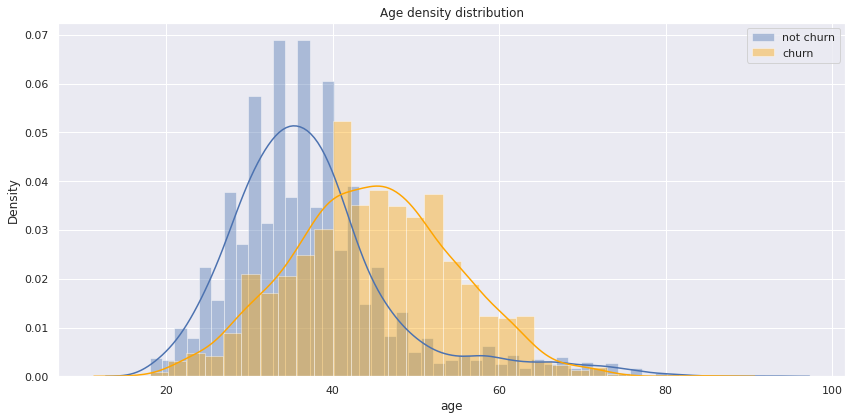

In [21]:
# set dataframes for exited = 0 and exited = 1
aux9_1 = df4[df4['exited']==0]
aux9_2 = df4[df4['exited']==1]

# set up figure size
plt.subplots(figsize=(12,6))

sns.distplot(aux9_1['age'], label='not churn');
sns.distplot(aux9_2['age'], color='orange', label='churn');
plt.title('Age density distribution');
plt.legend();
save_fig('04_age_density_distribution')

Saving figure 04_age_distribution_churn


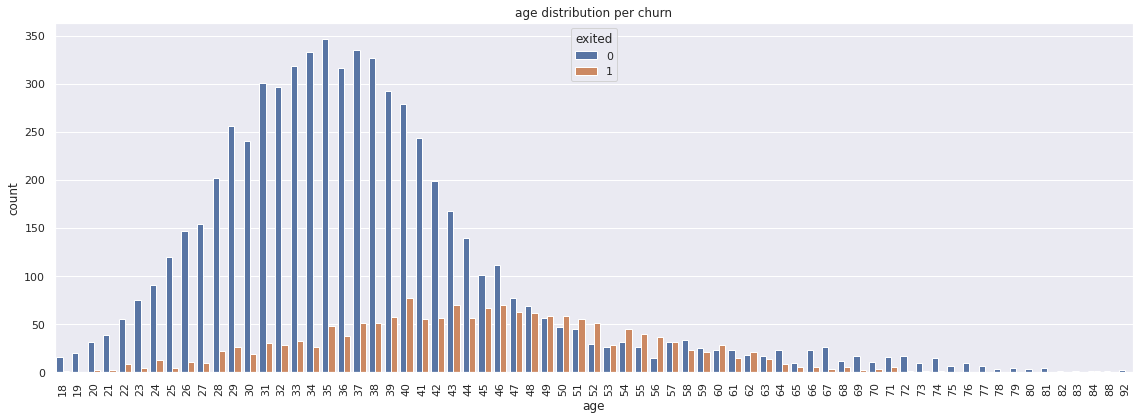

In [397]:
plt.subplots(figsize=(16,6))
sns.countplot(x='age', hue='exited', data=df4).set_title('age distribution per churn');
plt.xticks(rotation=90);
save_fig('04_age_distribution_churn')

Saving figure 04_age_percentage_distribution


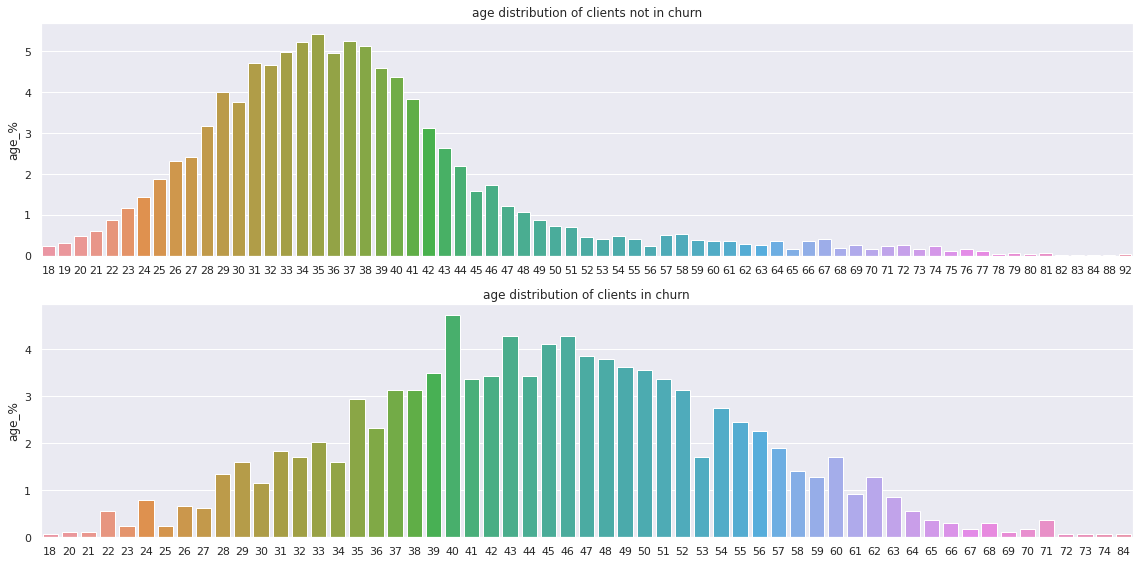

In [404]:
# plot percentages

# set up figure size
plt.subplots(figsize=(16,8))

# 1st plot: age distribution of clients not in churn
plt.subplot(2,1,1)
age_perc_not_churn = aux9_1['age'].value_counts(normalize=True)*100
sns.barplot(x=age_perc_not_churn.index, y=age_perc_not_churn).\
set_title('age distribution of clients not in churn');
plt.ylabel('age_%');

# 2nd plot: age distribution of clients in churn
plt.subplot(2,1,2)
age_perc_churn = aux9_2['age'].value_counts(normalize=True)*100
sns.barplot(x=age_perc_churn.index, y=age_perc_churn).\
set_title('age distribution of clients in churn');
plt.ylabel('age_%');

save_fig('04_age_percentage_distribution')

In [22]:
# new dataframe with has_cr_card, exited and number of clients
aux900 = df4[['age','balance', 'exited']].groupby(['age', 'exited']).count().reset_index()
aux900.columns = ['age', 'exited', 'num_clients']

# sum of clients in churn
sum_churn = aux900[aux900['exited']==1]['num_clients'].sum()

# sum of clients not in churn
sum_not_churn = aux900[aux900['exited']==0]['num_clients'].sum()

# calculate relative percentage
aux900['relative_percentage'] = aux900.\
apply(lambda x: ((x['num_clients'] / sum_churn)*100) if x['exited'] == 1 else ((x['num_clients'] / sum_not_churn)*100), axis=1)

aux900

age  exited  num_clients  relative_percentage
0     18       0           16             0.251177
1     18       1            1             0.061350
2     19       0           20             0.313972
3     20       0           31             0.486656
4     20       1            2             0.122699
..   ...     ...          ...                  ...
121   83       0            1             0.015699
122   84       0            1             0.015699
123   84       1            1             0.061350
124   88       0            1             0.015699
125   92       0            2             0.031397

[126 rows x 4 columns]

- Plot age relative percentage

Saving figure 04_age_relative_percentage


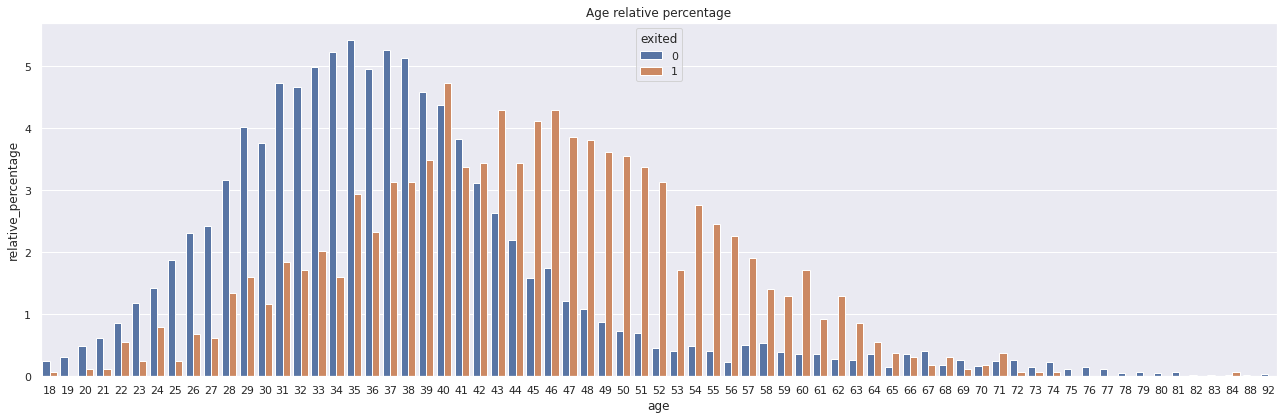

In [23]:
# set up figure size
plt.subplots(figsize=(18,6))

sns.barplot(x='age', y='relative_percentage', hue='exited', data=aux900).\
set_title('Age relative percentage');
save_fig('04_age_relative_percentage')

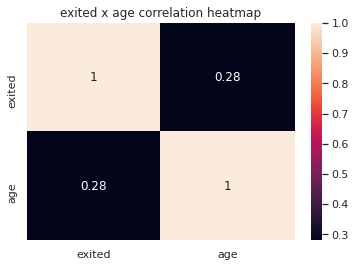

In [416]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['age']]);

- The density distribution plot shows that churn is proportionaly greater from 40 year on.
- The relative percentage barplot shows that from 40 years until 65 years, the churn ration is greater than the not churn. For all other ages, the not churn proportion is greater.
- The correlation heatmap shows a correlation coefficient of 0.28.
- Therefore, the hypothesis is False: churn rate is lower among young clients.

### H10. Churn should occur for clients with high tenure.
**TRUE** Churn occur for clients with high tenure.

Saving figure 04_tenure_distribution


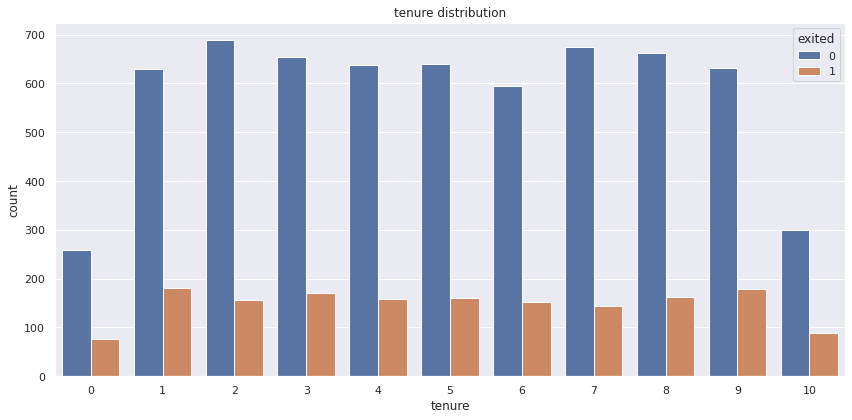

In [415]:
plt.subplots(figsize=(12,6))
sns.countplot(x='tenure', hue='exited', data=df4).set_title('tenure distribution');
save_fig('04_tenure_distribution')

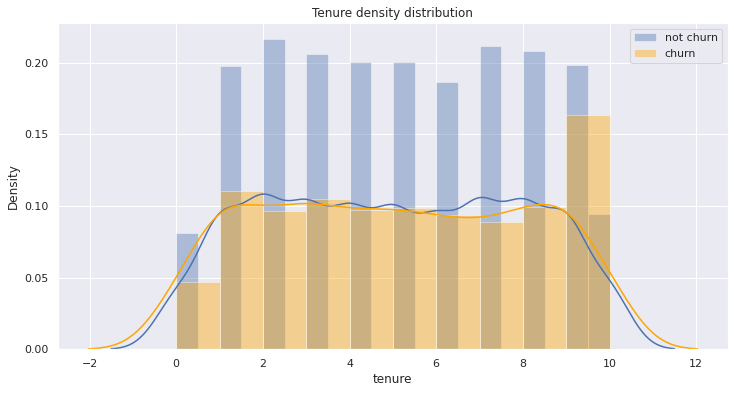

In [421]:
# set dataframe for exited = 0 and exited = 1
aux10_1 = df4[df4['exited']==0]
aux10_2 = df4[df4['exited']==1]

# set up figure size
plt.subplots(figsize=(12,6))

sns.distplot(aux10_1['tenure'], label='not churn');
sns.distplot(aux10_2['tenure'], color='orange', label='churn');
plt.title('Tenure density distribution');
plt.legend();
#save_fig('04_age_density_distribution')

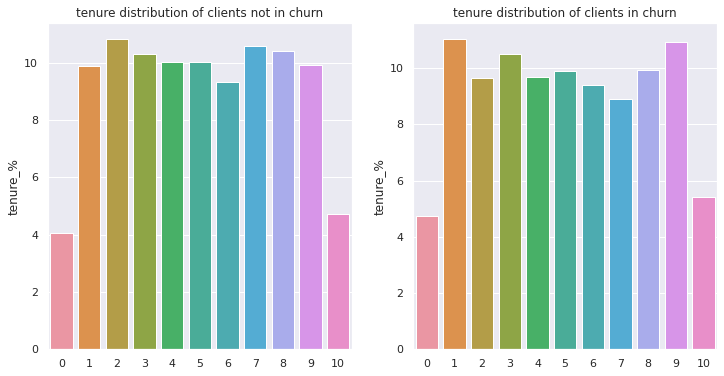

In [414]:
# plot percentages

# set up figure size
plt.subplots(figsize=(12,6))

# 1st plot: age distribution of clients not in churn
plt.subplot(1,2,1)
tenure_perc_not_churn = aux10_1['tenure'].value_counts(normalize=True)*100
sns.barplot(x=tenure_perc_not_churn.index, y=tenure_perc_not_churn).\
set_title('tenure distribution of clients not in churn');
plt.ylabel('tenure_%');

# 2nd plot: age distribution of clients in churn
plt.subplot(1,2,2)
tenure_perc_churn = aux10_2['tenure'].value_counts(normalize=True)*100
sns.barplot(x=tenure_perc_churn.index, y=tenure_perc_churn).\
set_title('tenure distribution of clients in churn');
plt.ylabel('tenure_%');

#save_fig('04_age_percentage_distribution')

In [418]:
# new dataframe with has_cr_card, exited and number of clients
aux10 = df4[['tenure','balance', 'exited']].groupby(['tenure', 'exited']).count().reset_index()
aux10.columns = ['tenure', 'exited', 'num_clients']

# sum of clients in churn
sum_churn = aux10[aux10['exited']==1]['num_clients'].sum()

# sum of clients not in churn
sum_not_churn = aux10[aux10['exited']==0]['num_clients'].sum()

# calculate relative percentage
aux10['relative_percentage'] = aux10.\
apply(lambda x: ((x['num_clients'] / sum_churn)*100) if x['exited'] == 1 else ((x['num_clients'] / sum_not_churn)*100), axis=1)

aux10

tenure  exited  num_clients  relative_percentage
0        0       0          258             4.050235
1        0       1           77             4.723926
2        1       0          629             9.874411
3        1       1          180            11.042945
4        2       0          690            10.832025
5        2       1          157             9.631902
6        3       0          655            10.282575
7        3       1          171            10.490798
8        4       0          638            10.015699
9        4       1          158             9.693252
10       5       0          639            10.031397
11       5       1          161             9.877301
12       6       0          594             9.324961
13       6       1          153             9.386503
14       7       0          674            10.580848
15       7       1          145             8.895706
16       8       0          662            10.392465
17       8       1          162             9.938650
18       9       0          631             9.905808
19       9       1          178            10.920245
20      10       0          300             4.709576
21      10       1           88             5.398773

- Plot tenure relative percentage

Saving figure 04_tenure_relative_percentage


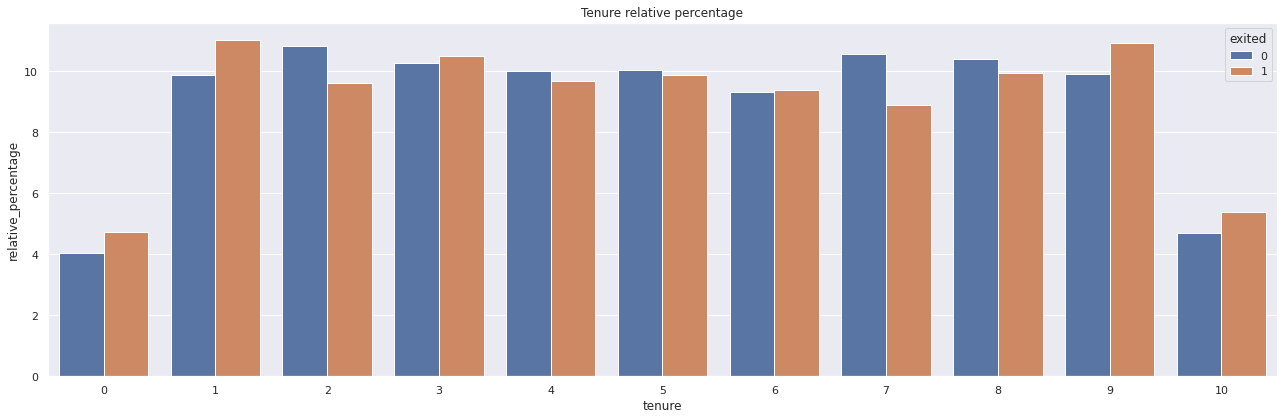

In [424]:
# set up figure size
plt.subplots(figsize=(18,6))

sns.barplot(x='tenure', y='relative_percentage', hue='exited', data=aux10).\
set_title('Tenure relative percentage');
save_fig('04_tenure_relative_percentage')

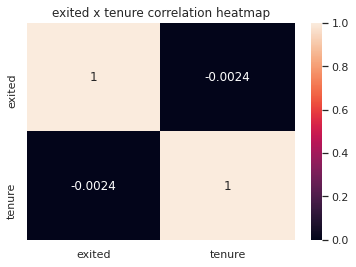

In [423]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['tenure']]);

- The tenure for churn and not churn is evenly distributed and has a very similar distribution and proportion pattern.
- There is no clear pattern that determines, based on the tenure, if a client is in churn.
- The biggest relative percentage difference between churn and not churn are for tenure 1 (1.2%), 2 (1.2%), 7 (1.7%) and 9 (1%).
- The correlation heatmap shows a low correlation coefficient between tenure and churn (exited) of -0.0024.
- The relative tenure proportion of clients in churn is greater for the lowest and biggest tenure than the tenure proportion of clients not in churn: that happens for tenure 0, 1, 9 and 10.
- Therefore, the hypothesis is true: churn occur for clients with high tenure.

### 4.2.1. Amount Analysis

Saving figure 04_amount_density_distribution


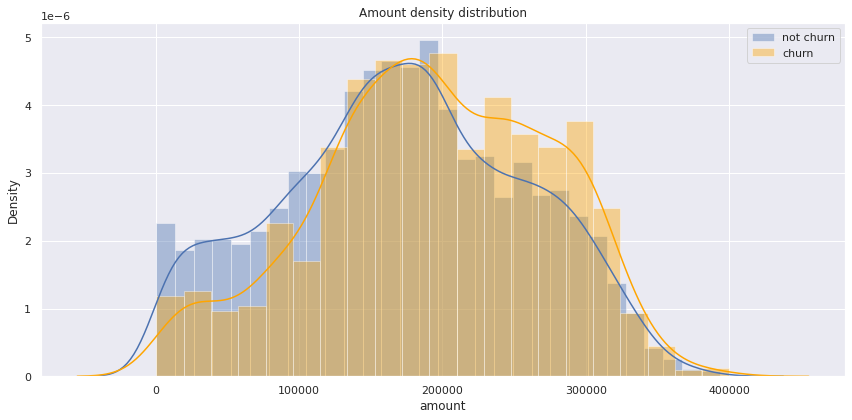

In [23]:
# set dataframe for exited = 0 and exited = 1
aux11_1 = df4[df4['exited']==0]
aux11_2 = df4[df4['exited']==1]

# set up figure size
plt.subplots(figsize=(12,6))

sns.distplot(aux11_1['amount'], label='not churn');
sns.distplot(aux11_2['amount'], color='orange', label='churn');
plt.title('Amount density distribution');
plt.legend();

save_fig('04_amount_density_distribution')

- Plot Amount binned values of clients in churn

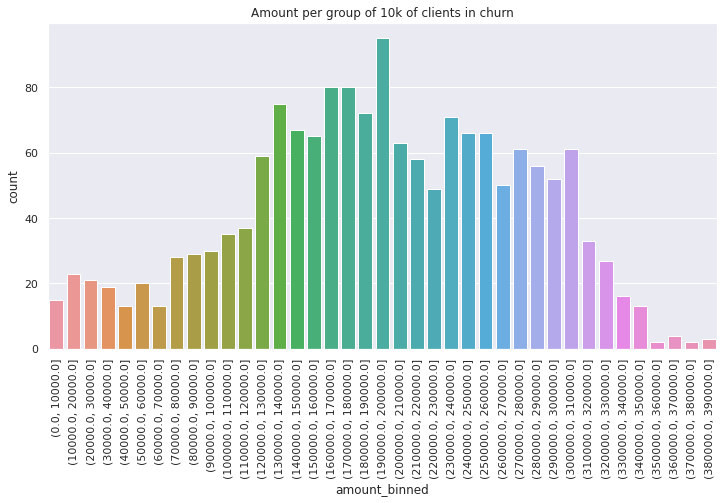

In [17]:
# plot amount binned values of clients in churn
# value groups division
bins11 = list(np.arange(0, 4e5, 10e3))
aux11_2['amount_binned'] = pd.cut(aux11_2['amount'], bins=bins11)
plt.subplots(figsize=(12,6))
sns.countplot(x='amount_binned', data=aux11_2).set_title("Amount per group of 10k of clients in churn");
# rotate x axis
plt.xticks(rotation=90);

- Plot Amount binned values of clients not in churn

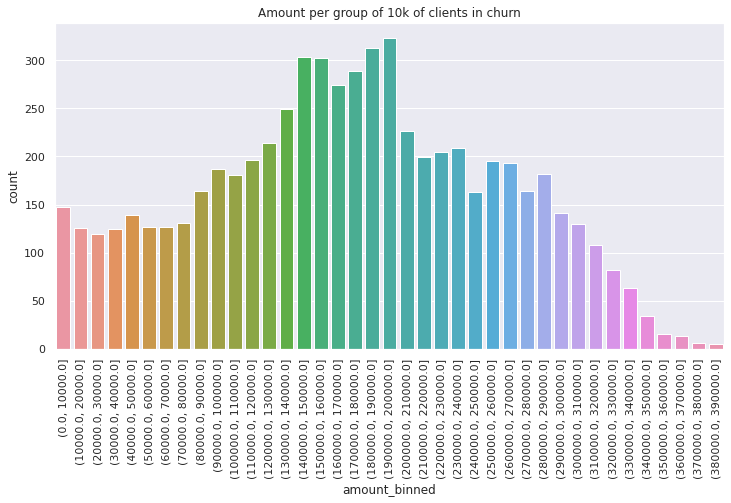

In [18]:
# plot amount binned values of clients not in churn

aux11_1['amount_binned'] = pd.cut(aux11_1['amount'], bins=bins11)
plt.subplots(figsize=(12,6))
sns.countplot(x='amount_binned', data=aux11_1).set_title("Amount per group of 10k of clients in churn");
# rotate x axis
plt.xticks(rotation=90);

- Calculate the relative percentage of clients in churn and not in churn per amount.

In [21]:
# create new dataframe
aux110 = df4[['amount', 'exited']]
aux110['amount_binned'] = pd.cut(aux110['amount'], bins=bins11)

# new dataframe with amount_binned, exited and number of clients
aux111 = aux110[['amount_binned', 'amount', 'exited']].\
groupby(['amount_binned', 'exited']).count().reset_index()

# rename new dataframe columns
aux111.columns = ['amount_binned', 'exited', 'clients']

# sum of clients in churn
clients_in_churn = aux111[aux111['exited'] == 1]['clients'].sum()

# sum of clients not in churn
clients_not_churn = aux111[aux111['exited'] == 0]['clients'].sum()

# calculate the relative percentage of clients in churn and not in churn
aux111['relative_percentage'] = aux111.\
apply(lambda x: ((x['clients'] / clients_in_churn)*100) if x['exited'] == 1 else ((x['clients'] / clients_not_churn)*100), axis=1)

aux111

amount_binned  exited  clients  relative_percentage
0         (0.0, 10000.0]       0      147             2.308055
1         (0.0, 10000.0]       1       15             0.920810
2     (10000.0, 20000.0]       0      126             1.978333
3     (10000.0, 20000.0]       1       23             1.411909
4     (20000.0, 30000.0]       0      119             1.868425
..                   ...     ...      ...                  ...
73  (360000.0, 370000.0]       1        4             0.245549
74  (370000.0, 380000.0]       0        6             0.094206
75  (370000.0, 380000.0]       1        2             0.122775
76  (380000.0, 390000.0]       0        5             0.078505
77  (380000.0, 390000.0]       1        3             0.184162

[78 rows x 4 columns]

- Plot the relative percentage of clients in churn and not in churn per amount.

Saving figure 04_amount_relative_percentage


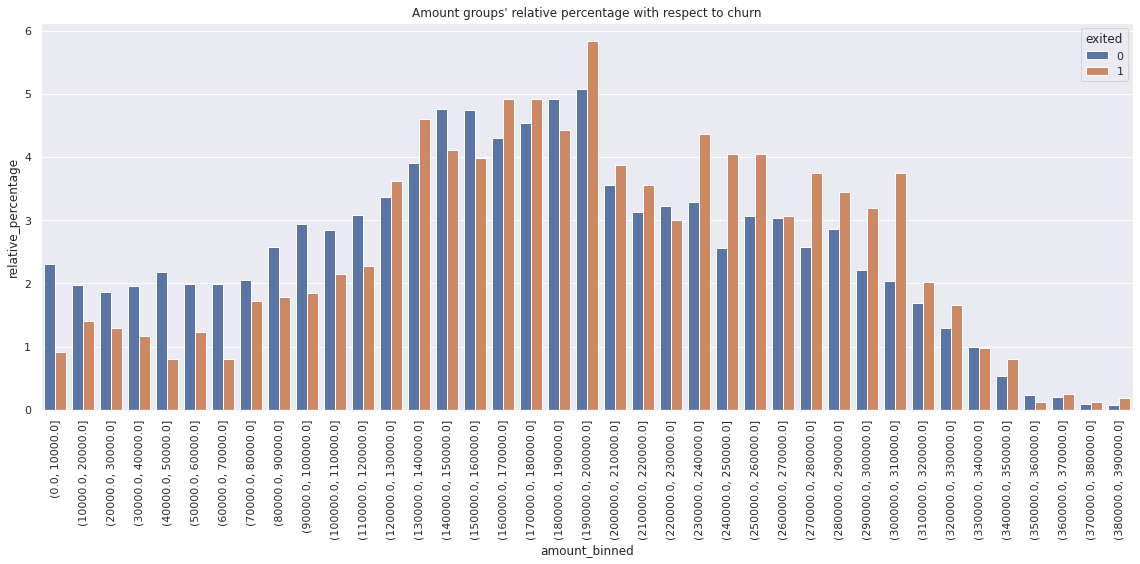

In [24]:
plt.subplots(figsize=(16,8))
sns.barplot(x='amount_binned', y='relative_percentage', hue='exited', data=aux111).\
set_title("Amount groups' relative percentage with respect to churn");
plt.xticks(rotation=90);
save_fig('04_amount_relative_percentage')

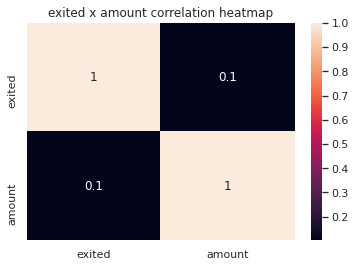

In [426]:
# point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df4[['exited']], df4[['amount']]);

- The amount density distribution plot shows that for the lowest amount values the majority of clients are not in churn. Conversely, for the highest amount values the majority of clients are in churn.
- The amount group's relative percentage plot shows that the amounts from zero to 120,000 have proportionaly more clients not in churn.
- From 120,000 to 190,000, the relative percentage of clients in churn and not in churn are miscelanious.
- From 190,000 on, the majority of relative percentages are from clients in churn.
- The correlation heatmap shows a correlation coefficient of 0.1 between amount and churn (exited).

#### Additional Scatterplots

- amount x amount_credit scatterplot

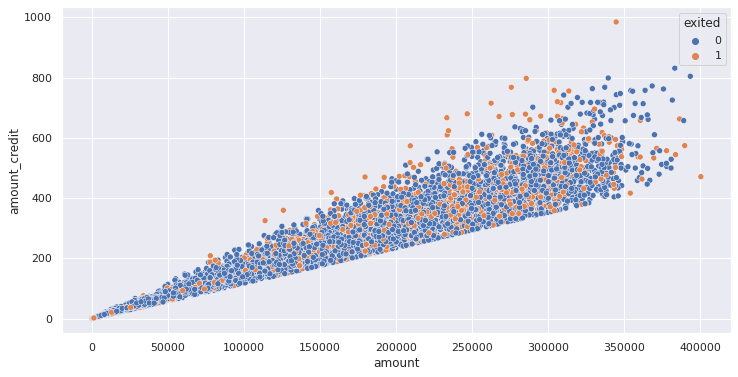

In [25]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='amount', y='amount_credit', hue='exited', data=df4);

- amount x amount_ten_year scatterplot

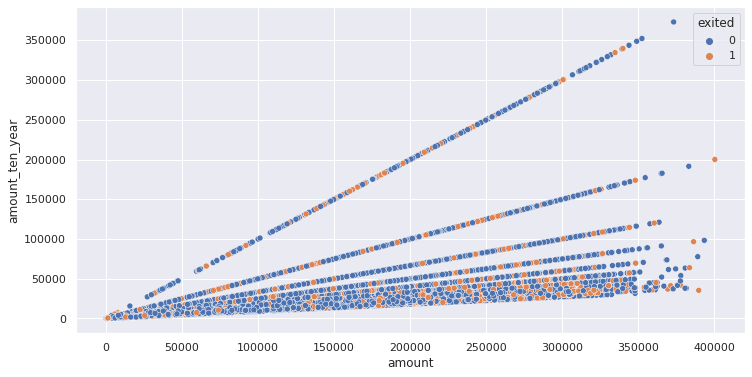

In [26]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='amount', y='amount_ten_year', hue='exited', data=df4);

- amount x amount_prod scatterplot

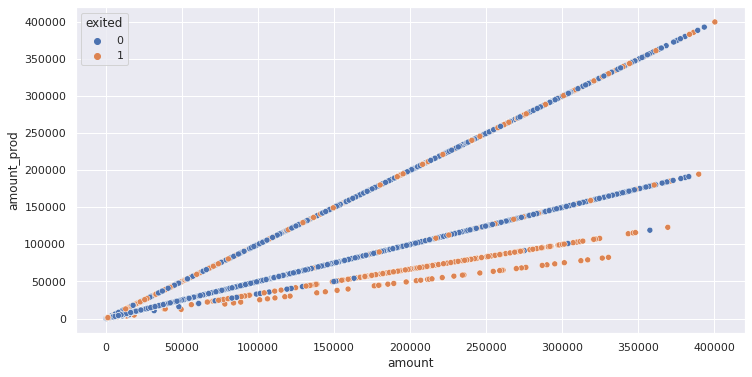

In [27]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='amount', y='amount_prod', hue='exited', data=df4);

- amount x age scatterplot

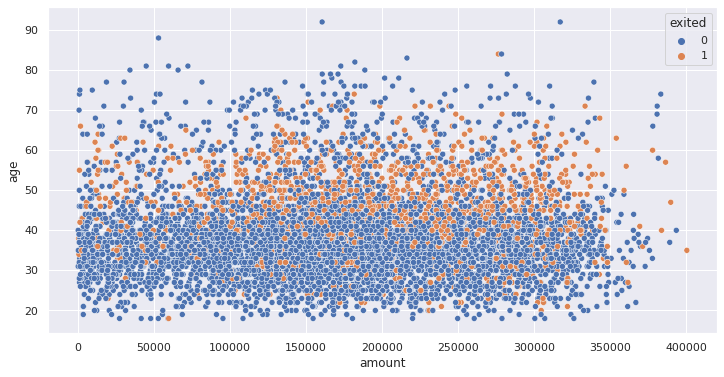

In [28]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='amount', y='age', hue='exited', data=df4);

### 4.2.2. Hypothesis Summary

In [28]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Churn should occur for clients with high salary.',
                                      'Churn should occur for clients with high balance.',
                                      'Churn should occur more for women than men.',
                                      'Churn should occur for clients with one product.',
                                      'Churn should not occur for active members.',
                                      'Churn should not occur for clients with credit card.',
                                      'Churn should occur for clients with a low credit score.',
                                      'Churn rate should be higher for clients from Spain.',
                                      'Churn rate should be higher among young clients.',
                                      'Churn should occur for clients with high tenure.',
                                     ],
                        'True / False':['True', 'True', 'True', 'True', 'True', 'True', 'True', 'False', 'False',
                                        'True'], 
                        'Relevance':['Low', 'High', 'Low', 'High', 'Medium', 'Low', 'Low', 'Medium', 'High', 
                                     'Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
summary

Hypothesis True / False  \
1          Churn should occur for clients with high salary.         True   
2         Churn should occur for clients with high balance.         True   
3               Churn should occur more for women than men.         True   
4          Churn should occur for clients with one product.         True   
5                Churn should not occur for active members.         True   
6      Churn should not occur for clients with credit card.         True   
7   Churn should occur for clients with a low credit score.         True   
8       Churn rate should be higher for clients from Spain.        False   
9          Churn rate should be higher among young clients.        False   
10         Churn should occur for clients with high tenure.         True   

   Relevance  
1        Low  
2       High  
3        Low  
4       High  
5     Medium  
6        Low  
7        Low  
8     Medium  
9       High  
10       Low

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

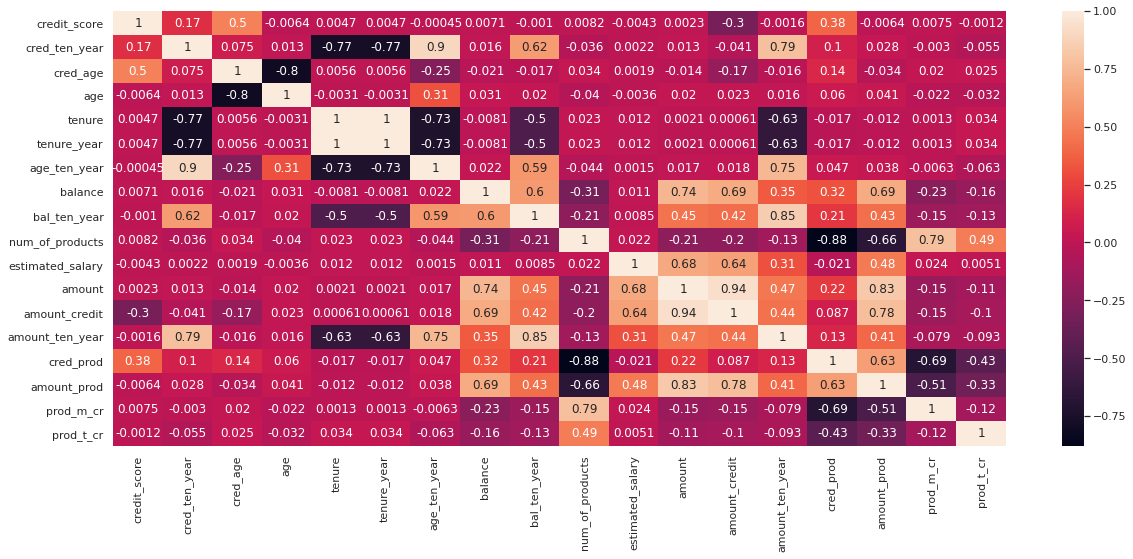

In [30]:
# select numerical attributes
num_attr = df4.select_dtypes(include=['int64', 'float64'])

# drop binary variables and row number, customer id features
num_attr = df4.drop(['has_cr_card', 'is_active_member', 'exited', 'row_number', 'customer_id'], axis=1)

# correlation by pearosn method
correlation = num_attr.corr( method='pearson' )

# set up figure size
f, ax = plt.subplots( figsize=(20,8))

sns.heatmap( correlation, annot=True );

Highlights:

- amount_prod x balance = 0.69
- balance x num_of_products = -0.31
- cred_prod x balance = 0.32
- amount x num_of_products = -0.21
- amount x cred_prod = 0.22
- cred_prod x bal_ten_year = 0.21

All the other highest correlations are among the new features and the original ones.

### 4.3.2. Categorical Attributes

In [31]:
c = df4.select_dtypes(exclude=['int64', 'float64'])
c.describe()

surname geography gender
count     8000      8000   8000
unique    2620         3      2
top      Smith    France   Male
freq        26      3993   4387

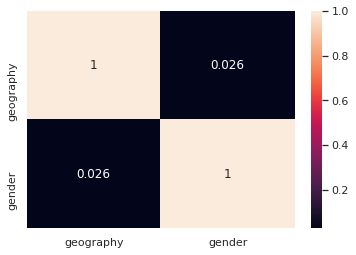

In [34]:
# calculate Cramer V
# Cramer V (chi2) formula is in the 0.2. Helper Functions subsection.
c1 = cramer_v( c['geography'], c['geography'] )
c2 = cramer_v( c['geography'], c['gender'] )

c3 = cramer_v( c['gender'], c['geography'] )
c4 = cramer_v( c['gender'], c['gender'] )

# final dataset
d = pd.DataFrame( {'geography': [c1, c2], 
                   'gender': [c3, c4]})

d = d.set_index( d.columns)

sns.heatmap( d, annot=True);

# 5.0. Data Preparation

In [24]:
df5 = df4.copy()

## 5.1. Boxplots

- Boxplots of some features in order to check outliers presence.

Saving figure 05_boxplots


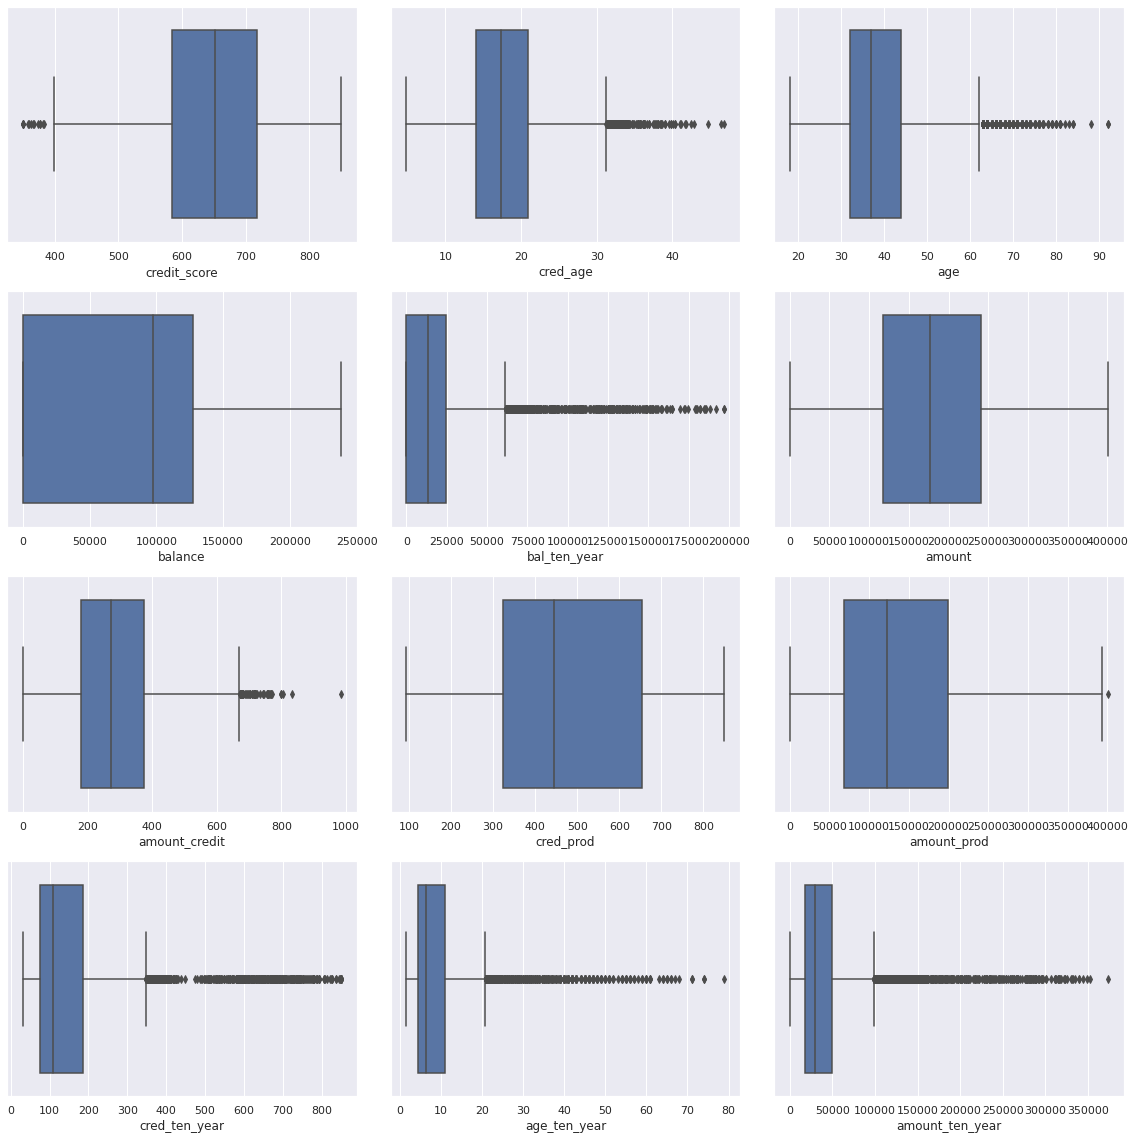

In [25]:
# set up figure size
plt.subplots(figsize=(16,16))

# credit_score boxplot
plt.subplot(4,3,1)
sns.boxplot(df5['credit_score'])

# cred_age boxplot
plt.subplot(4,3,2)
sns.boxplot(df5['cred_age'])

# age boxplot
plt.subplot(4,3,3)
sns.boxplot(df5['age'])

# balance boxplot
plt.subplot(4,3,4)
sns.boxplot(df5['balance'])

# bal_ten_year boxplot
plt.subplot(4,3,5)
sns.boxplot(df5['bal_ten_year'])

# amount boxplot
plt.subplot(4,3,6)
sns.boxplot(df5['amount'])

# amount_credit boxplot
plt.subplot(4,3,7)
sns.boxplot(df5['amount_credit'])

# cred_prod boxplot
plt.subplot(4,3,8)
sns.boxplot(df5['cred_prod'])

# amount_prod boxplot
plt.subplot(4,3,9)
sns.boxplot(df5['amount_prod']);

# cred_ten_year boxplot
plt.subplot(4,3,10)
sns.boxplot(df5['cred_ten_year'])

# age_ten_year boxplot
plt.subplot(4,3,11)
sns.boxplot(df5['age_ten_year'])

# amount_ten_year boxplot
plt.subplot(4,3,12)
sns.boxplot(df5['amount_ten_year']);

save_fig('05_boxplots')

## 5.2. Rescaling

The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.

- Standard Scaler: applied on variables with a distribution shape similar to a normal distribution;
- Min-Max Scaler: applied on variables with low outliers influence;
- Robust Scaler: applied on variables with high outliers influence.

In [19]:
# 1. Standard Scaler: credit_score
ssc = StandardScaler()

# credit_score
df5['credit_score'] = ssc.fit_transform(df5[['credit_score']].values)
# save scaler, so it can be applied in new data
with open('parameter/credit_score_scaler.pkl', 'wb') as f:
    pickle.dump(ssc, f)

In [20]:
# 2. Min-Max Scaler: cred_age, age, tenure, tenure_year, balance, estimated_salary, amount, 
# cred_prod, amount_prod, prod_m_cr, prod_t_cr
mms = MinMaxScaler()

# cred_age
df5['cred_age'] = mms.fit_transform(df5[['cred_age']].values)
# save scaler, so it can be applied in new data
with open('parameter/cred_age_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# age
df5['age'] = mms.fit_transform(df5[['age']].values)
# save scaler, so it can be applied in new data
with open('parameter/age_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# tenure
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
# save scaler, so it can be applied in new data
with open('parameter/tenure_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# tenure_year
df5['tenure_year'] = mms.fit_transform(df5[['tenure_year']].values)
# save scaler, so it can be applied in new data
with open('parameter/tenure_year_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# balance
df5['balance'] = mms.fit_transform(df5[['balance']].values)
# save scaler, so it can be applied in new data
with open('parameter/balance_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# estimated_salary
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)
# save scaler, so it can be applied in new data
with open('parameter/estimated_salary_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# amount
df5['amount'] = mms.fit_transform(df5[['amount']].values)
# save scaler, so it can be applied in new data
with open('parameter/amount_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)

# cred_prod
df5['cred_prod'] = mms.fit_transform(df5[['cred_prod']].values)
# save scaler, so it can be applied in new data
with open('parameter/cred_prod_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)

# amount_prod
df5['amount_prod'] = mms.fit_transform(df5[['amount_prod']].values)
# save scaler, so it can be applied in new data
with open('parameter/amount_prod_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# prod_m_cr
df5['prod_m_cr'] = mms.fit_transform(df5[['prod_m_cr']].values)
# save scaler, so it can be applied in new data
with open('parameter/prod_m_cr_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)
    
# prod_t_cr
df5['prod_t_cr'] = mms.fit_transform(df5[['prod_t_cr']].values)
# save scaler, so it can be applied in new data
with open('parameter/prod_t_cr_scaler.pkl', 'wb') as f:
    pickle.dump(mms, f)

In [21]:
# 3. Robust Scaler: amount_cred, cred_ten_year, age_ten_year, bal_ten_year, amount_ten_year
rs = RobustScaler()

# amount_credit
df5['amount_credit'] = rs.fit_transform(df5[['amount_credit']].values)
# save scaler, so it can be applied in new data
with open('parameter/amount_credit_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# cred_ten_year
df5['cred_ten_year'] = rs.fit_transform(df5[['cred_ten_year']].values)
# save scaler, so it can be applied in new data
with open('parameter/cred_ten_year_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# age_ten_year
df5['age_ten_year'] = rs.fit_transform(df5[['age_ten_year']].values)
# save scaler, so it can be applied in new data
with open('parameter/age_ten_year_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# bal_ten_year
df5['bal_ten_year'] = rs.fit_transform(df5[['bal_ten_year']].values)
# save scaler, so it can be applied in new data
with open('parameter/bal_ten_year_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)
    
# amount_ten_year
df5['amount_ten_year'] = rs.fit_transform(df5[['amount_ten_year']].values)
# save scaler, so it can be applied in new data
with open('parameter/amount_ten_year_scaler.pkl', 'wb') as f:
    pickle.dump(rs, f)

## 5.3. Transformation

### 5.3.1. Encoding

- Apply One-Hot Encoding on geography and gender features due to their low cardinality.

In [22]:
# One-Hot Encoding: geography
df5 = pd.get_dummies(df5, prefix=['geography'], columns=['geography'])

In [23]:
# One-Hot Encoding: gender
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender'])

## 5.3. Check Prepared Data

In [79]:
df5.head().T

0         1         2          3          4
row_number             2152      8393      5007       4118       7183
customer_id        15588614  15641158  15750014   15663964   15573520
surname              Walton   Belcher   Chikere   Pagnotto     Rhodes
credit_score        1.05857  0.913626   1.07927  -0.929207   0.427035
cred_ten_year     -0.134786  0.696636   5.92829   -0.14052 -0.0913718
cred_age            0.19874  0.433877  0.369917   0.245172   0.220436
age                0.527027  0.189189  0.256757   0.256757   0.418919
tenure                  0.7       0.3         0        0.5        0.6
tenure_year             0.7       0.3         0        0.5        0.6
age_ten_year       0.103114   0.23569   4.62963 -0.0420875  0.0841751
balance                   0  0.428413  0.477648          0     0.4637
bal_ten_year      -0.541709  0.499852   4.10334  -0.541709   0.102493
num_of_products           1         1         2          2          2
has_cr_card               1         1         1          1          0
is_active_member          0         0         1          0          1
estimated_salary   0.797394  0.319879  0.586979   0.415448   0.537358
amount             0.398205  0.414781  0.577555   0.207374   0.544457
amount_credit     -0.301421 -0.235166  0.180682  -0.626172   0.225269
amount_ten_year   -0.293846  0.373383   6.23621   -0.48189  0.0525574
cred_prod          0.871693  0.853175     0.375   0.246693   0.333333
amount_prod        0.398273  0.414847  0.288745   0.103675   0.272198
prod_m_cr                 0         0      0.25       0.25        0.5
prod_t_cr              0.25      0.25       0.5        0.5          0
exited                    1         1         0          0          0
geography_France          1         0         0          1          0
geography_Germany         0         1         1          0          1
geography_Spain           0         0         0          0          0
gender_Female             0         0         1          0          0
gender_Male               1         1         0          1          1

- Check numerical attributes distribution

In [80]:
num_attr = df5.select_dtypes(include=['int64', 'float64'])

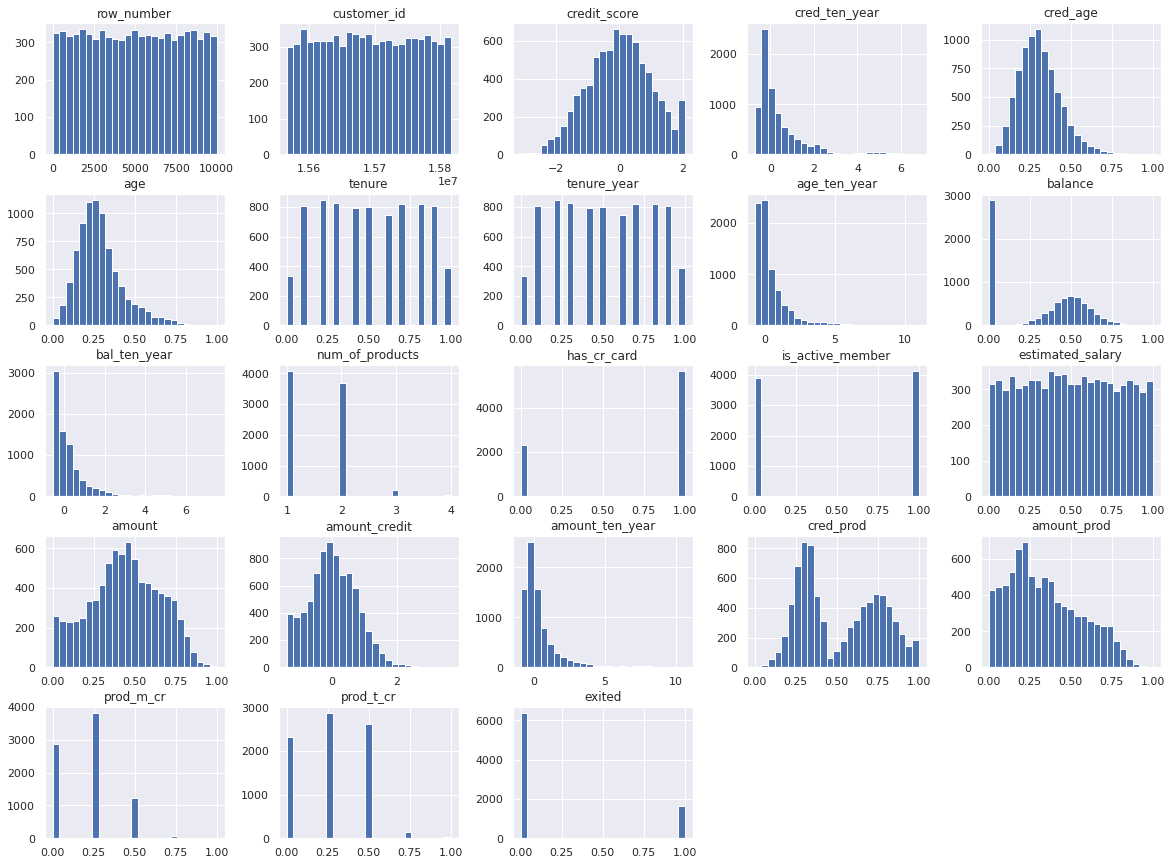

In [81]:
# numerical attributes histogram
num_attr.hist( bins=25, figsize=(20,15) );

# 6.0. Feature Selection

In [40]:
# Remove unnecessary Columns

# Remove row_number, customer_id and surname columns. They will not be applied for the machine learning training.
df5 = df5.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [41]:
# Remove target variable from train set
X_train = df5.drop('exited', axis=1)

# target variable
y_train = df5['exited'].copy()

In [42]:
X_train.head()

credit_score  cred_ten_year  cred_age       age  tenure  tenure_year  \
0      1.058568      -0.134786  0.198740  0.527027     0.7          0.7   
1      0.913626       0.696636  0.433877  0.189189     0.3          0.3   
2      1.079274       5.928287  0.369917  0.256757     0.0          0.0   
3     -0.929207      -0.140520  0.245172  0.256757     0.5          0.5   
4      0.427035      -0.091372  0.220436  0.418919     0.6          0.6   

   age_ten_year   balance  bal_ten_year  num_of_products  ...  \
0      0.103114  0.000000     -0.541709                1  ...   
1      0.235690  0.428413      0.499852                1  ...   
2      4.629630  0.477648      4.103337                2  ...   
3     -0.042088  0.000000     -0.541709                2  ...   
4      0.084175  0.463700      0.102493                2  ...   

   amount_ten_year  cred_prod  amount_prod  prod_m_cr  prod_t_cr  \
0        -0.293846   0.871693     0.398273       0.00       0.25   
1         0.373383   0.853175     0.414847       0.00       0.25   
2         6.236212   0.375000     0.288745       0.25       0.50   
3        -0.481890   0.246693     0.103675       0.25       0.50   
4         0.052557   0.333333     0.272198       0.50       0.00   

   geography_France  geography_Germany  geography_Spain  gender_Female  \
0                 1                  0                0              0   
1                 0                  1                0              0   
2                 0                  1                0              1   
3                 1                  0                0              0   
4                 0                  1                0              0   

   gender_Male  
0            1  
1            1  
2            0  
3            1  
4            1  

[5 rows x 25 columns]

In [43]:
y_train.head()

0    1
1    1
2    0
3    0
4    0
Name: exited, dtype: int64

## 6.1. Random Forest as Feature Selector

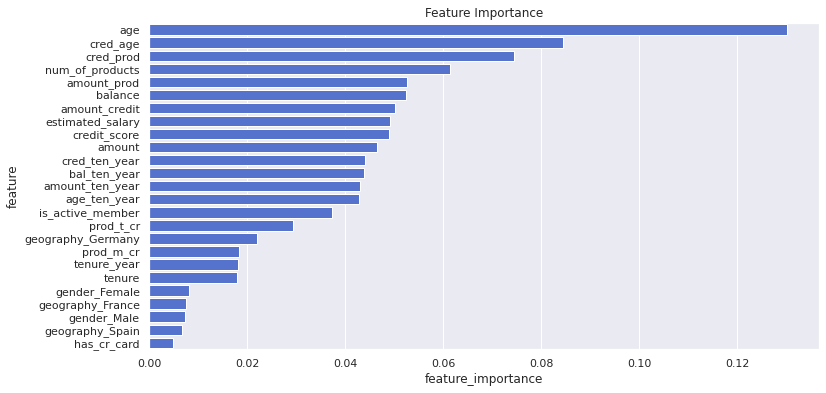

In [44]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [45]:
feat_imp_select = feat_imp.iloc[:13]
feat_imp_select

feature  feature_importance
0                age            0.130135
1           cred_age            0.084362
2          cred_prod            0.074398
3    num_of_products            0.061345
4        amount_prod            0.052567
5            balance            0.052419
6      amount_credit            0.050173
7   estimated_salary            0.049073
8       credit_score            0.048819
9             amount            0.046442
10     cred_ten_year            0.043976
11      bal_ten_year            0.043689
12   amount_ten_year            0.043068

- Select top features list.
- Add geography and is_active_member based on EDA.

In [46]:
# top features list
feat_list = feat_imp_select['feature'].to_list() + ['geography_Germany', 'geography_France', 'geography_Spain', 'is_active_member']
feat_list

['age',
 'cred_age',
 'cred_prod',
 'num_of_products',
 'amount_prod',
 'balance',
 'amount_credit',
 'estimated_salary',
 'credit_score',
 'amount',
 'cred_ten_year',
 'bal_ten_year',
 'amount_ten_year',
 'geography_Germany',
 'geography_France',
 'geography_Spain',
 'is_active_member']

# 7.0. Machine Learning Modelling

In [47]:
# train data with selected features of Feature Selection
x_train = X_train[feat_list]

In [31]:
x_train.head()

age  cred_age  cred_prod  num_of_products  amount_prod   balance  \
0  0.527027  0.198740   0.871693                1     0.398273  0.000000   
1  0.189189  0.433877   0.853175                1     0.414847  0.428413   
2  0.256757  0.369917   0.375000                2     0.288745  0.477648   
3  0.256757  0.245172   0.246693                2     0.103675  0.000000   
4  0.418919  0.220436   0.333333                2     0.272198  0.463700   

   amount_credit  estimated_salary  credit_score    amount  cred_ten_year  \
0      -0.301421          0.797394      1.058568  0.398205      -0.134786   
1      -0.235166          0.319879      0.913626  0.414781       0.696636   
2       0.180682          0.586979      1.079274  0.577555       5.928287   
3      -0.626172          0.415448     -0.929207  0.207374      -0.140520   
4       0.225269          0.537358      0.427035  0.544457      -0.091372   

   bal_ten_year  amount_ten_year  geography_Germany  geography_France  \
0     -0.541709        -0.293846                  0                 1   
1      0.499852         0.373383                  1                 0   
2      4.103337         6.236212                  1                 0   
3     -0.541709        -0.481890                  0                 1   
4      0.102493         0.052557                  1                 0   

   geography_Spain  is_active_member  
0                0                 0  
1                0                 0  
2                0                 1  
3                0                 0  
4                0                 1

In [32]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                8000 non-null   float64
 1   cred_age           8000 non-null   float64
 2   cred_prod          8000 non-null   float64
 3   num_of_products    8000 non-null   int64  
 4   amount_prod        8000 non-null   float64
 5   balance            8000 non-null   float64
 6   amount_credit      8000 non-null   float64
 7   estimated_salary   8000 non-null   float64
 8   credit_score       8000 non-null   float64
 9   amount             8000 non-null   float64
 10  cred_ten_year      8000 non-null   float64
 11  bal_ten_year       8000 non-null   float64
 12  amount_ten_year    8000 non-null   float64
 13  geography_Germany  8000 non-null   uint8  
 14  geography_France   8000 non-null   uint8  
 15  geography_Spain    8000 non-null   uint8  
 16  is_active_member   8000 

## 7.1. Balancing Data for Training

In [52]:
# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# resample the dataset
x_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

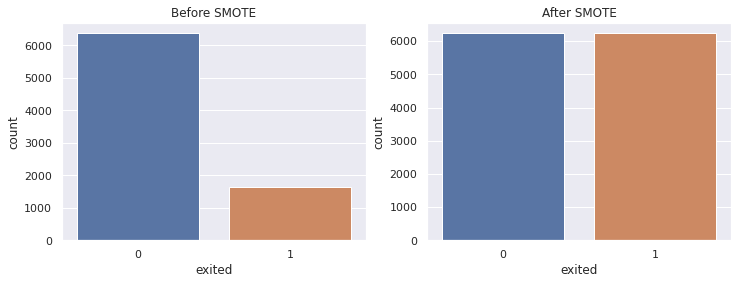

In [53]:
# plots before and after SMOTETomek
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_balanced)
plt.title("After SMOTE")

plt.show()

## 7.2. Logistic Regression

### 7.2.1. Imbalanced Data

In [158]:
# instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_train, y_train)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance = performance(logit, x_train, y_train)
logit_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0        0.83325        0.717363     0.300613       0.422827   

   test_roc_auc_score  test_mcc  
0            0.635079  0.389126

In [159]:
# predcitions
logit_y_pred = cross_val_predict(logit, x_train, y_train, cv=10)

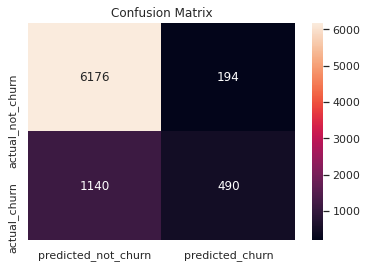

In [160]:
# confusion matrix
logit_cm = confusion_matrix(y_train, logit_y_pred)

# dataframe for heatmap
logit_cm_df = pd.DataFrame(logit_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(logit_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

### 7.2.2. Balanced Data

In [175]:
# instantiate the model
logit = LogisticRegression()

# fit the model
logit.fit(x_balanced, y_balanced)

# model performance with performance function. For more details, please see Helper Functions section.
logit_performance_bal = performance(logit, x_balanced, y_balanced)
logit_performance_bal

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.750642        0.747601     0.756813       0.752078   

   test_roc_auc_score  test_mcc  
0            0.750641  0.501461

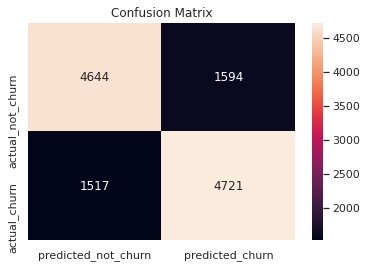

In [176]:
# predcitions
logit_y_pred = cross_val_predict(logit, x_balanced, y_balanced, cv=10)

# confusion matrix
logit_cm = confusion_matrix(y_balanced, logit_y_pred)

# dataframe for heatmap
logit_cm_df = pd.DataFrame(logit_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(logit_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.3. Random forest Classifier

### 7.3.1. Imbalanced Data

In [54]:
# define the model
rf_im_clf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

In [55]:
# model performance with performance function. For more details, please see Helper Functions section.
rf_performance = performance(rf_im_clf, x_train, y_train)
rf_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.859375        0.756713     0.458896        0.56974   

   test_roc_auc_score  test_mcc  
0            0.710374  0.514708

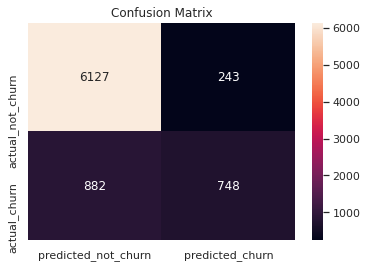

In [56]:
# predcitions
rf_y_pred = cross_val_predict(rf_im_clf, x_train, y_train, cv=10)

# confusion matrix
rf_cm = confusion_matrix(y_train, rf_y_pred)

# dataframe for heatmap
rf_cm_df = pd.DataFrame(rf_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(rf_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

### 7.3.2. Balanced Data

In [57]:
# define the model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(x_balanced, y_balanced)

In [58]:
# model performance with performance function. For more details, please see Helper Functions section.
rf_performance_bal = performance(rf_clf, x_balanced, y_balanced)
rf_performance_bal

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.896284        0.886859     0.908152       0.897014   

   test_roc_auc_score  test_mcc  
0            0.896284  0.793466

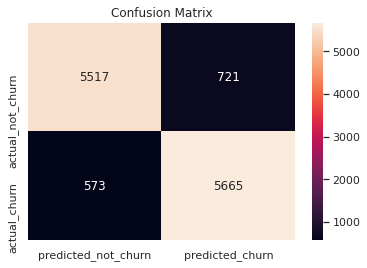

In [59]:
# predcitions
rf_y_pred = cross_val_predict(rf_clf, x_balanced, y_balanced, cv=10)

# confusion matrix
rf_cm = confusion_matrix(y_balanced, rf_y_pred)

# dataframe for heatmap
rf_cm_df = pd.DataFrame(rf_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(rf_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.4. XGBoost Classifier

### 7.4.1. Imbalanced Data

In [60]:
# define the model
xgb_im_clf = XGBClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

In [61]:
# model performance with performance function. For more details, please see Helper Functions section.
xgb_performance = performance(xgb_im_clf, x_train, y_train)
xgb_performance

test_accuracy  test_precision  test_recall  test_f1_score  \
0        0.85525        0.715567     0.484663       0.576276   

   test_roc_auc_score  test_mcc  
0            0.717371  0.507597

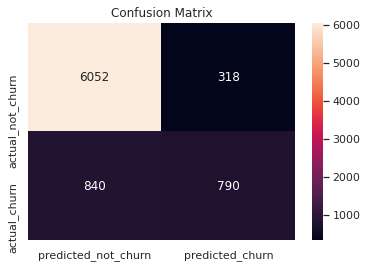

In [62]:
# predictions
xgb_y_pred = cross_val_predict(xgb_im_clf, x_train, y_train, cv=10)

# confusion matrix
xgb_cm = confusion_matrix(y_train, xgb_y_pred)

# dataframe for heatmap
xgb_cm_df = pd.DataFrame(xgb_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(xgb_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

### 7.4.2. Balanced Data

In [63]:
# define the model
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1).fit(x_balanced, y_balanced)

In [64]:
# model performance with performance function. For more details, please see Helper Functions section.
xgb_performance_bal = performance(xgb_clf, x_balanced, y_balanced)
xgb_performance_bal

test_accuracy  test_precision  test_recall  test_f1_score  \
0       0.898379        0.914517     0.877556       0.887607   

   test_roc_auc_score  test_mcc  
0            0.898378  0.806235

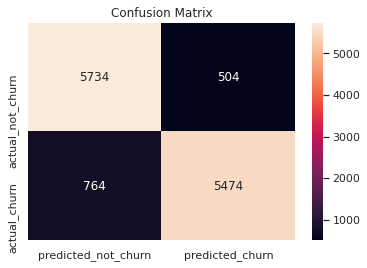

In [65]:
# predictions
xgb_y_pred = cross_val_predict(xgb_clf, x_balanced, y_balanced, cv=10)

# confusion matrix
xgb_cm = confusion_matrix(y_balanced, xgb_y_pred)

# dataframe for heatmap
xgb_cm_df = pd.DataFrame(xgb_cm, columns=['predicted_not_churn', 'predicted_churn'], index=['actual_not_churn', 'actual_churn'])

# confusion matrix heatmap
sns.heatmap(xgb_cm_df, annot=True, fmt='d').set_title('Confusion Matrix');

## 7.5. Performance Comparison

### 7.5.1. Imbalanced Data

In [167]:
# performance comparison data frame
performance_comp = pd.concat([logit_performance, rf_performance, xgb_performance])
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

accuracy  precision    recall  f1_score  roc_auc_score  \
model                                                                         
Logistic Regression  0.833250   0.717363  0.300613  0.422827       0.635079   
Random Forest        0.859375   0.756713  0.458896  0.569740       0.710374   
XGBoost              0.855250   0.715567  0.484663  0.576276       0.717371   

                          MCC  
model                          
Logistic Regression  0.389126  
Random Forest        0.514708  
XGBoost              0.507597

### 7.5.2. Balanced Data

In [183]:
# performance comparison data frame
performance_comp = pd.concat([logit_performance_bal, rf_performance_bal, xgb_performance_bal])
performance_comp.columns = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']
performance_comp['model'] = ['Logistic Regression', 'Random Forest', 'XGBoost']
performance_comp = performance_comp[['model', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score', 'MCC']]
performance_comp.set_index('model')

accuracy  precision    recall  f1_score  roc_auc_score  \
model                                                                         
Logistic Regression  0.750642   0.747601  0.756813  0.752078       0.750641   
Random Forest        0.896284   0.886859  0.908152  0.897014       0.896284   
XGBoost              0.898379   0.914517  0.877556  0.887607       0.898378   

                          MCC  
model                          
Logistic Regression  0.501461  
Random Forest        0.793466  
XGBoost              0.806235

- Metrics calculated with 10-fold cross validation.
- Best models are Random Forest and XGBoost.
- Random Forest has the best Recall (90.8%) and best F1-Score (89.7%).
- XGBoost has the best Precision (91.5%) and best MCC (80.6%).

Based on the Business context and in order to better accomplish the project goals, deliverables and deployment, the chosen model is Random Forest.

# 8.0. Hyperparameter Fine-Tuning

## 8.1. Random Search

### 8.1.1. Random Search with balanced data

In [37]:
# instantiate the classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [38]:
# set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [39]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [40]:
# fit the model
rf_random.fit(x_balanced, y_balanced)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 41.3min finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 36}

In [42]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=36, n_estimators=900, n_jobs=-1,
                       random_state=42)

In [43]:
# best estimator
rf_tuned = rf_random.best_estimator_
rf_tuned

RandomForestClassifier(max_depth=36, n_estimators=900, n_jobs=-1,
                       random_state=42)

In [44]:
# save tuned model
with open('model/model_rf_tuned.pkl', 'wb') as f:
    pickle.dump(rf_tuned, f)

### 8.1.2. Random Search with imbalanced data

In [143]:
# instantiate the classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [144]:
# set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [145]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_imb_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [146]:
# fit the model
rf_imb_random.fit(x_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 26.0min finished


RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [147]:
rf_imb_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 32}

In [148]:
rf_imb_random.best_estimator_

RandomForestClassifier(max_depth=32, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, random_state=42)

In [149]:
# best estimator
rf_imb_tuned = rf_imb_random.best_estimator_
rf_imb_tuned

RandomForestClassifier(max_depth=32, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, random_state=42)

In [150]:
# save tuned model
with open('model/model_rf_imb_tuned.pkl', 'wb') as f:
    pickle.dump(rf_imb_tuned, f)

## 8.2. Tuned Model x Base Model Performance Comparison on Test Set

### 8.2.1. Prepare Test Set

In [37]:
# load test set
test_set = pd.read_csv('dataset/test.csv')
test_set.sample(5)

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
1266       6562    15650538       Sun          445   Germany  Female   48   
1834       4354    15804822        L?          805    France  Female   31   
225         969    15641009   Wilhelm          544    France    Male   37   
757        3536    15626882    Stobie          662     Spain    Male   37   
124        8027    15679743  Genovesi          607    France  Female   33   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
1266       7  168286.58              1          1               0   
1834       4       0.00              2          1               0   
225        3   84496.71              1          0               0   
757        5   94901.09              1          1               1   
124        8   91301.72              1          0               1   

      EstimatedSalary  Exited  
1266         16645.77       1  
1834          4798.12       0  
225          79972.09       0  
757          48233.75       0  
124         130824.57       0

In [38]:
# rename columns
test_set = rename_columns(test_set)

# Create new features
test_set = feature_engineering(test_set)

test_set.head()

row_number  customer_id    surname  credit_score  cred_ten_year   cred_age  \
0        5703     15749540     Hsiung           585         73.125  16.250000   
1        3668     15807340  O'Donnell           525        105.000  15.909091   
2        1618     15801062   Matthews           557        111.400  13.925000   
3        5674     15572801  Krischock           639        106.500  18.794118   
4        4273     15600708  Calabresi           640        160.000  18.823529   

  geography  gender  age  tenure  ...  is_active_member  estimated_salary  \
0    France    Male   36       7  ...                 0          94283.09   
1   Germany    Male   33       4  ...                 0          55072.93   
2     Spain  Female   40       4  ...                 1         105433.53   
3     Spain    Male   34       5  ...                 0          33950.08   
4     Spain  Female   34       3  ...                 1         168544.85   

      amount  amount_credit  amount_ten_year  cred_prod  amount_prod  \
0   94283.09     161.167675      11785.38625      292.5    47141.545   
1  186096.69     354.469886      37219.33800      262.5    93048.345   
2  105433.53     189.288205      21086.70600      278.5    52716.765   
3  173343.27     271.272723      28890.54500      319.5    86671.635   
4  246371.65     384.955703      61592.91250      640.0   246371.650   

   prod_m_cr  prod_t_cr  exited  
0          1          2       0  
1          2          0       0  
2          2          0       0  
3          2          0       0  
4          0          1       0  

[5 rows x 26 columns]

In [39]:
# copy test_set
X_test_prep = test_set.copy()

In [40]:
# Transformations
# Load scalers
credit_score_scaler = pickle.load(open('parameter/credit_score_scaler.pkl', 'rb'))
cred_age_scaler = pickle.load(open('parameter/cred_age_scaler.pkl', 'rb'))
age_scaler = pickle.load(open('parameter/age_scaler.pkl', 'rb'))
tenure_scaler = pickle.load(open('parameter/tenure_scaler.pkl', 'rb'))
tenure_year_scaler = pickle.load(open('parameter/tenure_year_scaler.pkl', 'rb'))
balance_scaler = pickle.load(open('parameter/balance_scaler.pkl', 'rb'))
estimated_salary_scaler = pickle.load(open('parameter/estimated_salary_scaler.pkl', 'rb'))
amount_scaler = pickle.load(open('parameter/amount_scaler.pkl', 'rb'))
cred_prod_scaler = pickle.load(open('parameter/cred_prod_scaler.pkl', 'rb'))
amount_prod_scaler = pickle.load(open('parameter/amount_prod_scaler.pkl', 'rb'))
prod_m_cr_scaler = pickle.load(open('parameter/prod_m_cr_scaler.pkl', 'rb'))
prod_t_cr_scaler = pickle.load(open('parameter/prod_t_cr_scaler.pkl', 'rb'))
amount_credit_scaler = pickle.load(open('parameter/amount_credit_scaler.pkl', 'rb'))
cred_ten_year_scaler = pickle.load(open('parameter/cred_ten_year_scaler.pkl', 'rb'))
age_ten_year_scaler = pickle.load(open('parameter/age_ten_year_scaler.pkl', 'rb'))
bal_ten_year_scaler = pickle.load(open('parameter/bal_ten_year_scaler.pkl', 'rb'))
amount_ten_year_scaler = pickle.load(open('parameter/amount_ten_year_scaler.pkl', 'rb'))

In [41]:
# Apply rescaling
X_test_prep['credit_score'] = credit_score_scaler.fit_transform(X_test_prep[['credit_score']].values)
X_test_prep['cred_age'] = cred_age_scaler.fit_transform(X_test_prep[['cred_age']].values)
X_test_prep['age'] = age_scaler.fit_transform(X_test_prep[['age']].values)
X_test_prep['tenure'] = tenure_scaler.fit_transform(X_test_prep[['tenure']].values)
X_test_prep['tenure_year'] = tenure_year_scaler.fit_transform(X_test_prep[['tenure_year']].values)
X_test_prep['balance'] = balance_scaler.fit_transform(X_test_prep[['balance']].values)
X_test_prep['estimated_salary'] = estimated_salary_scaler.fit_transform(X_test_prep[['estimated_salary']].values)
X_test_prep['amount'] = amount_scaler.fit_transform(X_test_prep[['amount']].values)
X_test_prep['cred_prod'] = cred_prod_scaler.fit_transform(X_test_prep[['cred_prod']].values)
X_test_prep['amount_prod'] = amount_prod_scaler.fit_transform(X_test_prep[['amount_prod']].values)
X_test_prep['prod_m_cr'] = prod_m_cr_scaler.fit_transform(X_test_prep[['prod_m_cr']].values)
X_test_prep['prod_t_cr'] = prod_t_cr_scaler.fit_transform(X_test_prep[['prod_t_cr']].values)
X_test_prep['amount_credit'] = amount_credit_scaler.fit_transform(X_test_prep[['amount_credit']].values)
X_test_prep['cred_ten_year'] = cred_ten_year_scaler.fit_transform(X_test_prep[['cred_ten_year']].values)
X_test_prep['age_ten_year'] = age_ten_year_scaler.fit_transform(X_test_prep[['age_ten_year']].values)
X_test_prep['bal_ten_year'] = bal_ten_year_scaler.fit_transform(X_test_prep[['bal_ten_year']].values)
X_test_prep['amount_ten_year'] = amount_ten_year_scaler.fit_transform(X_test_prep[['amount_ten_year']].values)

In [42]:
# Encoding - apply one-hot encoding
X_test_prep = pd.get_dummies(X_test_prep, prefix=['geography'], columns=['geography'])
X_test_prep = pd.get_dummies(X_test_prep, prefix=['gender'], columns=['gender'])

In [43]:
# target variable
y_test = X_test_prep['exited'].copy()

In [44]:
# selected feeatures list
select_feat = ['age',
 'cred_age',
 'cred_prod',
 'num_of_products',
 'amount_prod',
 'balance',
 'amount_credit',
 'estimated_salary',
 'credit_score',
 'amount',
 'cred_ten_year',
 'bal_ten_year',
 'amount_ten_year',
 'geography_Germany',
 'geography_France',
 'geography_Spain',
 'is_active_member']

# selected features on test set
x_test = X_test_prep[select_feat]

### 8.2.2. Base Model Performance

In [66]:
# Performance of model trained on balanced data
random_forest_bal, cm = performance_test('Random Forest bal', rf_clf, x_test, y_test)
random_forest_bal

precision   recall  f1_score  roc_auc_score       mcc
Random Forest bal   0.467905  0.68059  0.554555       0.741425  0.425848

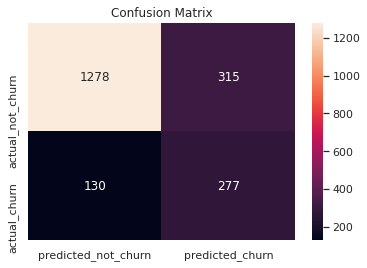

In [67]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

In [68]:
# performance of model trained on imbalanced data
# Model's performance on test set
random_forest_imb, cm = performance_test('Random Forest imb',rf_im_clf, x_test, y_test)
random_forest_imb

precision    recall  f1_score  roc_auc_score       mcc
Random Forest imb   0.709343  0.503686   0.58908       0.725477  0.516374

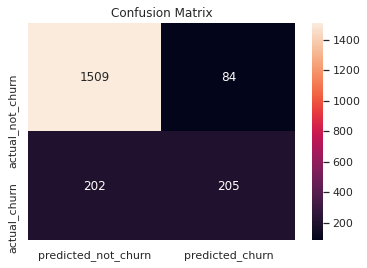

In [69]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

### 8.2.3. Tuned Model Performance

In [70]:
# open tuned model
with open('model/model_rf_tuned.pkl', 'rb') as f:
    rf_tuned = pickle.load(f)

In [71]:
# Model's performance on test set
random_forest_tuned_bal, cm = performance_test('Random Forest tuned bal',rf_tuned, x_test, y_test)
random_forest_tuned_bal

precision    recall  f1_score  roc_auc_score  \
Random Forest tuned bal   0.458472  0.678133  0.547076       0.736744   

                              mcc  
Random Forest tuned bal  0.415587

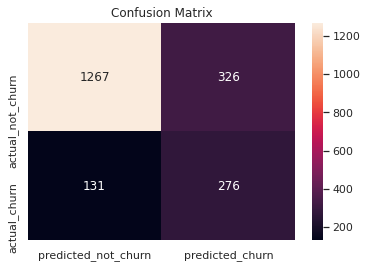

In [72]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

In [35]:
# performance of model trained on imbalanced data
# open tuned model
with open('model/model_rf_imb_tuned.pkl', 'rb') as f:
    rf_imb_tuned = pickle.load(f)

In [20]:
# Model's performance on test set
random_forest_tuned_imb, cm = performance_test('Random Forest tuned imb',rf_imb_tuned, x_test, y_test)
random_forest_tuned_imb

precision    recall  f1_score  roc_auc_score     mcc
Random Forest tuned imb   0.733564  0.520885  0.609195       0.736274  0.5411

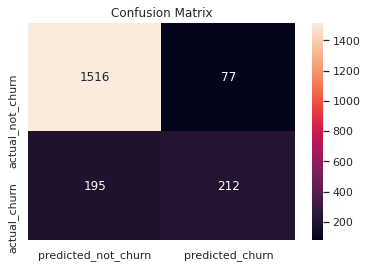

In [21]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

### 8.2.3. XGBoost

In [76]:
# Model's performance on test set
xgb_bal, cm = performance_test('XGBoost bal',xgb_clf, x_test, y_test)
xgb_bal

precision    recall  f1_score  roc_auc_score       mcc
XGBoost bal   0.271756  0.874693  0.414677       0.637911  0.233601

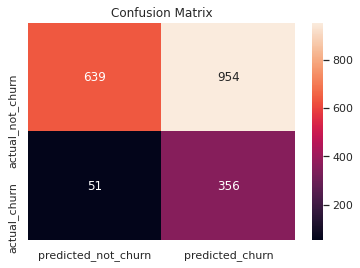

In [77]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

In [78]:
# performance of model trained on imbalanced data
# Model's performance on test set
xgb_imb, cm = performance_test('XGBoost imb',xgb_im_clf, x_test, y_test)
xgb_imb

precision    recall  f1_score  roc_auc_score       mcc
XGBoost imb   0.685897  0.525799  0.595271        0.73214  0.515135

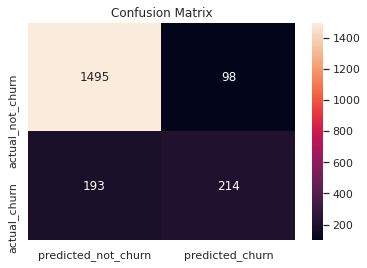

In [79]:
# confusion matrix
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix');

### 8.2.4. Performance Comparison

In [80]:
# concatenate the performance dataframes
perf_comp = pd.concat([random_forest_bal, random_forest_imb, 
                      random_forest_tuned_bal, random_forest_tuned_imb,
                      xgb_bal, xgb_imb])

perf_comp

precision    recall  f1_score  roc_auc_score  \
Random Forest bal         0.467905  0.680590  0.554555       0.741425   
Random Forest imb         0.709343  0.503686  0.589080       0.725477   
Random Forest tuned bal   0.458472  0.678133  0.547076       0.736744   
Random Forest tuned imb   0.733564  0.520885  0.609195       0.736274   
XGBoost bal               0.271756  0.874693  0.414677       0.637911   
XGBoost imb               0.685897  0.525799  0.595271       0.732140   

                              mcc  
Random Forest bal        0.425848  
Random Forest imb        0.516374  
Random Forest tuned bal  0.415587  
Random Forest tuned imb  0.541100  
XGBoost bal              0.233601  
XGBoost imb              0.515135

- The model with best performance, that is, with best F1-Score and best MCC is Random Forest tuned imb (Random Forest trained on original imbalanced data and fine-tuned).

# 9.0. Model and Business Performance

## 9.1. Model Performance

### 9.1.1. Precision and recall versus decision threshold

In [45]:
# calculate model predicted probabilities
y_probas = rf_imb_tuned.predict_proba(x_test)

# get positive class probabilities
y_scores = y_probas[:,1]
y_scores

array([0.06214461, 0.10876017, 0.03028623, ..., 0.83406478, 0.05066117,
       0.06524319])

In [24]:
# compute precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

In [50]:
# current recall from the model
recall_model = random_forest_tuned_imb['recall'][0]

# current precision from the model
precision_model = random_forest_tuned_imb['precision'][0]

In [89]:
# get current precision index
prec_index = np.where(precisions==precision_model)
prec_index

(array([1656]),)

In [91]:
# get current threshold of the model
threshold_model = thresholds[prec_index]
threshold_model

array([0.50047451])

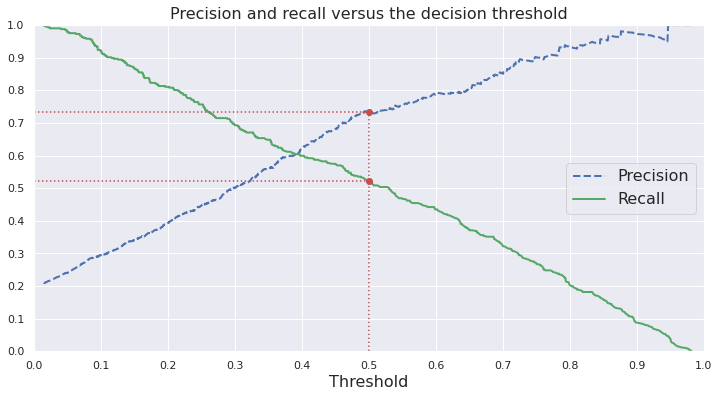

In [94]:
# Plot precision and recall versus threshold

# figure size
plt.figure(figsize=(12,6))

plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.legend(loc='center right', fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.grid(True)

# plot current precision and recall from the model
plt.plot([threshold_model, threshold_model], [0.0, precision_model], 'r:')
plt.plot([0.0, threshold_model], [precision_model, precision_model], 'r:')
plt.plot([0.0, threshold_model], [recall_model, recall_model], 'r:')
plt.plot([threshold_model], [precision_model], 'ro')
plt.plot([threshold_model], [recall_model], 'ro')
plt.axis([0, 1, 0, 1])
plt.title('Precision and recall versus the decision threshold', fontsize=16)
plt.show()

### 9.1.2. Precision versus Recall

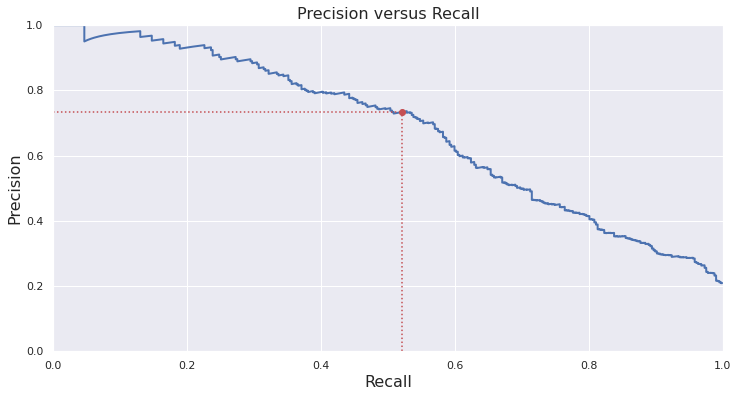

In [49]:
# plot precision versus recall

# figure size
plt.figure(figsize=(12,6))

plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.axis([0, 1, 0, 1])

# plot current precision and recall from the model
plt.plot([recall_model, recall_model], [0.0, precision_model], 'r:')
plt.plot([0.0, recall_model], [precision_model, precision_model], 'r:')
plt.plot([recall_model], [precision_model], 'ro')
plt.grid(True)
plt.title('Precision versus Recall', fontsize=16)
plt.show()

### 9.1.3. ROC Curve

In [96]:
# compute TPR and FPR
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

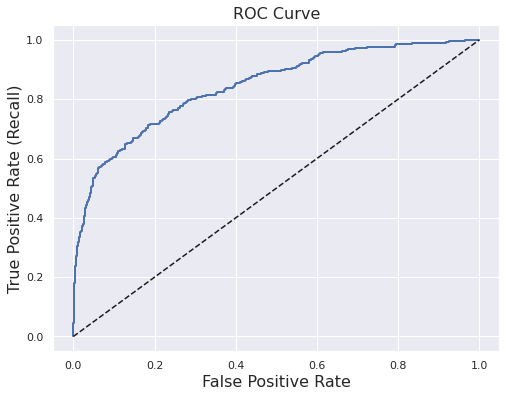

In [99]:
# plot ROC Curve

# figure size
plt.figure(figsize=(8,6))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.title('ROC Curve', fontsize=16)
plt.grid(True)
plt.show()

### 9.1.4. Lift Curve and Cumulative Gains Curve

**Lift Curve**
- The lift curve uses the returned probability of a classification model to assess how the model is performing, and how well it is identifying the positive or negative instances of the dataset.
- By ordering the data from the highest to the smallest probability, the highest probability appear on the left of the graph, usually along with the highest Lift scores.
- Provides a quick way to get an estimate of how the algorithm is performing.
- The lift chart provides an easy way to visualize how many times better applying the model is than random selection for any percentage of the ranked records.
- The greater the area between the lift curve and the baseline, the better the model.

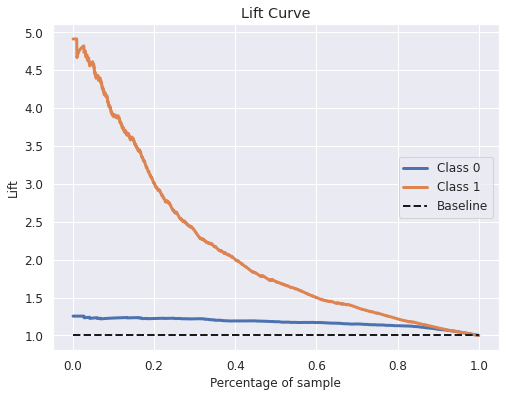

In [114]:
# plot Lift curve
skplt.metrics.plot_lift_curve(y_test, y_probas, figsize=(8,6))
plt.legend(loc='center right', fontsize=12)
plt.show()

- The Lift curve shows that if 20% of the customers are contacted, using the prediction of the model should reach 60% of customers in churn. The y-value of the lift curve at 20% is 60 / 20 = 3.

**Cumulative Gains Curve**

- The left hand side of the x-axis start with the observations that have the highest probability of belonging to the class of interest.
- The x axis tell us what percentage of the observations are being considered. In this case, it is a percentage of the 2,000 clients from the test set.

- The y axis (Gain) indicates the percentage of positive responses. In this case, it is the percentage of the 407 positive responses from the test set.

- Question to ask and answer with this plot: when the model is applied to the data, and the most likely X percent of the records are selected, what percentage of the actual records you’re interested can you expect to find?

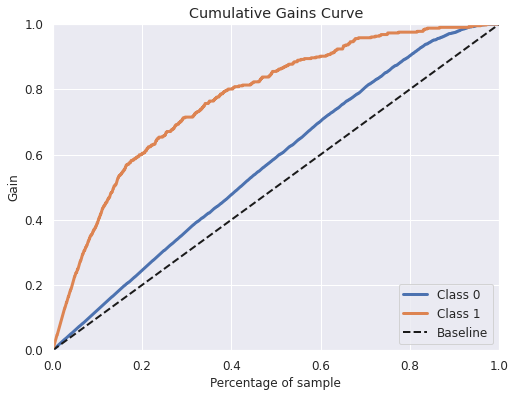

In [111]:
# plot cumulative gains curve
skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(8,6))
plt.show()

- Check Lift and Cumulative Gains values

In [44]:
# copy test_set
lift_df = test_set.copy()

# add predictions and predicted probabilities according the model
lift_df['predictions'] = y_pred
lift_df['probabilities'] = y_scores

# sort lift_df according predicted probabilities
lift_df = lift_df.sort_values('probabilities', ascending=False)

In [48]:
# set percentage of the sample (percentage of clients to contact in order to avoid churn)
sample_pc = 0.2

# calculate the size of the percentage of the sample
top_sample_pc = np.ceil((len(lift_df['exited'])*sample_pc)).astype(int)

# select top rated clients (top predicted probabilities)
clients_top = lift_df.iloc[:top_sample_pc]

# calculate cumulative gain
cumulative_gain = clients_top['exited'].sum() / test_set['exited'].sum()

# calculate lift
lift = cumulative_gain / sample_pc

# print results
print('sample percentage: {}%'.format(sample_pc*100))
print('Cumulative gain: {:,.2f}'.format(cumulative_gain))
print('Lift: {:,.2f}'.format(lift))

sample percentage: 20.0%
Cumulative gain: 0.60
Lift: 3.01


Lift and Cumulative Gains References:

http://www2.cs.uregina.ca/~dbd/cs831/notes/lift_chart/lift_chart.html

https://www.kdnuggets.com/2016/03/lift-analysis-data-scientist-secret-weapon.html

https://towardsdatascience.com/the-lift-curve-unveiled-998851147871

https://towardsdatascience.com/evaluate-model-performance-with-cumulative-gains-and-lift-curves-1f3f8f79da01

## 9.2. Business Performance

### 9.2.1. Current Churn Rate

- Current churn rate

In [237]:
# calculate current churn rate
churn_rate = test_set['exited'].value_counts(normalize=True)*100
print('The current churn Rate is {:,.2f}%'.format(churn_rate[1]))

The current churn Rate is 20.35%


- How the churn rate varies per month?

It is not possible to calculate how the churn rate varies per month, as there's no month information in the available dataset.
What can be calculated is the churn variation per tenure (number of years that the customer was active).

In [152]:
churn_rate_ten = (test_set[test_set['tenure']==2]['exited'].sum() / len(test_set[test_set['tenure']==2]))*100
churn_rate_ten

21.890547263681594

In [39]:
# get tenure values
ten_values = test_set['tenure'].value_counts()
ten_values = np.array(ten_values.index)
churn_list = []

# calculate churn rate per tenure
for ten in ten_values:
    churn_rate_ten = (test_set[test_set['tenure']==ten]['exited'].sum() / len(test_set[test_set['tenure']==ten]))*100
    churn_list.append(churn_rate_ten)

In [41]:
# create churn rate per tenure dataframe
churn_ten_df = pd.DataFrame({'churn_rate': churn_list, 'tenure': ten_values})
churn_ten_df = churn_ten_df.sort_values('tenure')
churn_ten_df.round(2)

churn_rate  tenure
10       23.08       0
0        23.01       1
5        21.89       2
7        22.95       3
6        23.32       4
2        22.64       5
1        19.55       6
3        15.31       7
4        17.41       8
8        20.00       9
9        12.75      10

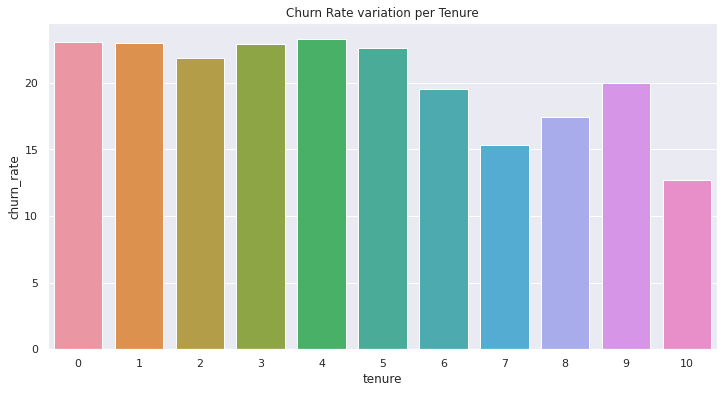

In [196]:
# plot churn rate variation per tenure
plt.figure(figsize=(12,6))
sns.barplot(x='tenure', y='churn_rate', data=churn_ten_df).set_title('Churn Rate variation per Tenure');

- What's the model's performance to label the clients as churns?


- The model has a precision of 73.4% to label the clients as churns. The model can detect 52.1% of clients in churn.

### 9.2.3. Bank Revenue

#### 9.2.3.1. General Business Results

- What's the company's revenue, if the company avoids the customers to get into churn through the developed model?

- Bank account return per client:
    - 15% for clients with estimated income lower than the average;
    - 20% for clients with estimated income greater than the average.

In [46]:
# calculate bank account return per client

# create auxiliary dataset
business_df = test_set.copy()

business_df['return_client'] = business_df.\
apply(lambda x: x['estimated_salary']*0.15 if x['estimated_salary'] < business_df['estimated_salary'].mean() else x['estimated_salary']*0.2, axis=1)

- Calculate current total return of all clients

In [47]:
# calculate current total return of all clients
return_total = business_df['return_client'].sum()
print('Total current return of all clients: {:,.2f}'.format(return_total))

Total current return of all clients: 38,079,850.98


- Calculate revenue loss if all clients in churn leave the bank

In [99]:
# number of clients in churn
clients_churn = business_df['exited'].value_counts()[1]

# calculate total revenue loss
total_loss = business_df[business_df['exited']==1]['return_client'].sum()
print('Total revenue loss if all {} clients in churn leave the bank: {:,.2f}.'.format(clients_churn, total_loss))
print('The total revenue loss represents {:,.2f}% of total current return.'.format((total_loss/return_total)*100))

Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97.
The total revenue loss represents 19.67% of total current return.


In [49]:
# model predictions
y_pred = rf_imb_tuned.predict(x_test)

# dataframe with predictions and predicted probabilities
business_df['predictions'] = y_pred
business_df['probabilities'] = y_scores

- Calculate company's revenue , if the company avoids the customers to get into churn through the developed model

In [100]:
# filter clients in churn according model and dataset
aux = business_df[(business_df['exited']==1) & (business_df['predictions']==1)]

# number of clients to recover
clients_recover = len(aux)
# clients ratio w.r.t. total clients in churn
clients_ratio = (clients_recover / clients_churn)*100

# revenue if clients don't get in churn
revenue = aux['return_client'].sum()
# revenue ratio w.r.t. revenue loss
revenue_ratio = (revenue / total_loss)*100

print("Company's recovered revenue if {} clients don't get into churn through the model: {:,.2f}".\
      format(clients_recover, revenue))
print('That represents {:,.2f}% of clients labeled as in churn and {:,.2f}% of the total revenue loss'.\
      format(clients_ratio, revenue_ratio))

Company's recovered revenue if 212 clients don't get into churn through the model: 4,064,569.35
That represents 52.09% of clients labeled as in churn and 54.25% of the total revenue loss


- Sort Customers according model's churn probability predictions.

In [51]:
# sort business_df according predicted probabilities
business_df = business_df.sort_values('probabilities', ascending=False)

#### 9.2.3.2. Customer Incentive to Maximize ROI - Alternative 1
**Top 100 clients with highest churn probability.**

- Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00

Top 100 clients with highest churn probability

- Incentive per client: $100.
- If churn (exited) is True, then returns recovered revenue per client.
- If churn (exited) is False, then returns zero.
- The profit is the difference between recovered revenue and the incentive per client.

In [103]:
# select top 100 clients with highest churn probability
clients_top_100 = business_df.iloc[:100]

# set incentive per client
clients_top_100['incentive'] = 100

# calculate recovered revenue per client
clients_top_100['rec_revenue'] = clients_top_100.\
apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
clients_top_100['profit'] = clients_top_100['rec_revenue'] - clients_top_100['incentive']

# calculate total recovered revenue
revenue = clients_top_100['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = clients_top_100['incentive'].sum()

# calculate the profit
profit = clients_top_100['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = clients_top_100[(clients_top_100['exited']==1) & (clients_top_100['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 1,672,172.96
% Recovered from Total Revenue loss: 22.32%
Investment: 10,000.00
Profit: 1,662,172.96
ROI: 16,621.73%
Potential clients recovered acc. model: 93
Potential churn reduction: 22.85%


#### 9.2.3.3. Customer Incentive to Maximize ROI - Alternative 2
**Top 200 clients with highest churn probability.**

- Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00

Top 200 clients with highest churn probability.

- Incentive per client: $50.
- If churn (exited) is True, then returns recovered revenue per client.
- If churn (exited) is False, then returns zero.
- The profit is the difference between recovered revenue and the incentive per client.

In [104]:
# select top 200 clients with highest churn probability
clients_top_200 = business_df.iloc[:200]

# set incentive per client
clients_top_200['incentive'] = 50

# calculate recovered revenue per client
clients_top_200['rec_revenue'] = clients_top_200.\
apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
clients_top_200['profit'] = clients_top_200['rec_revenue'] - clients_top_200['incentive']

# calculate total recovered revenue
revenue = clients_top_200['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = clients_top_200['incentive'].sum()

# calculate the profit
profit = clients_top_200['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = clients_top_200[(clients_top_200['exited']==1) & (clients_top_200['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 3,089,126.96
% Recovered from Total Revenue loss: 41.23%
Investment: 10,000.00
Profit: 3,079,126.96
ROI: 30,791.27%
Potential clients recovered acc. model: 159
Potential churn reduction: 39.07%


#### 9.2.3.4. Customer Incentive to Maximize ROI - Alternative 3
**Maximum returned value with "0-1 Knapsack-Problem" approach**

- Goal: select the optimal combination of clients that maximize the total returned value , without exceeding the total weight constraint.
- In this case, each client has a "weight": the financial incentive that will be given in order to avoid the churn.
- The total weight constraint is the total amount available to give the incentives: $ 10,000.00.
- The incentive can either be offered or not: 0-1 (0-1 Knapsack).

- Please see 0.2. Helper Functions section for knapsack function details.

Knapsack Problem References:

https://en.wikipedia.org/wiki/Knapsack_problem

https://www.youtube.com/watch?v=QOaxir6Qek4

https://www.geeksforgeeks.org/python-program-for-dynamic-programming-set-10-0-1-knapsack-problem/

- Set incentive per client and filter clients in churn according model and dataset

In [105]:
# set financial incentive $ 100 per client
business_df['incentive'] = 100

# filter clients in churn according model
aux = business_df[business_df['predictions']==1]

- Apply knapsack function and calculate business results.

In [106]:
# set parameters for the knapsack function
val = aux['return_client'].astype(int).values # return per client
wt = aux['incentive'].values # incentive value per client
investment = 10000 # total amount of incentive according the problem

# calculate revenue with knapsack function. For more details, please see 0.2. Helper Functions section.
max_val, keep = knapsack(investment, wt, val)

# dataframe with selected clients that maximizes output value
aux = aux[keep]

# calculate recovered revenue per client
aux['rec_revenue'] = aux.\
apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
aux['profit'] = aux['rec_revenue'] - aux['incentive']

# calculate total recovered revenue
revenue = aux['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = aux['incentive'].sum()

# calculate the profit
profit = aux['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = aux[(aux['exited']==1) & (aux['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 2,655,711.90
% Recovered from Total Revenue loss: 35.45%
Investment: 10,000.00
Profit: 2,645,711.90
ROI: 26,457.12%
Potential clients recovered acc. model: 78
Potential churn reduction: 19.16%


#### 9.2.3.5. Customer Incentive to Maximize ROI - Alternative 4
**The Realistic approach and Maximum returned value with "0-1 Knapsack-Problem" approach**

- Some customers will leave no matter what: p(churn) > 0.99

- Some might stay but only with a $200 incentive: 0.95 < p(churn) < 0.99

- Some will stay with a $100 incentive: 0.90 < p(churn) < 0.95

- Others will stay with a $50 incentive: p(churn) < 0.90

In [108]:
# list of available incentives as stated above
# the incentive of 20000 is for clients with p(churn) > 0.99, it will be discarded in the knapsack function
incentives_list = [20000, 200, 100, 50]
incentives = []
n = len(business_df)

# set incentive value according churn predicted probability
for i in range(n):
    entry = business_df.iloc[i]
    if entry['probabilities'] >= 0.99:
        incentives.append(incentives_list[0])
    elif entry['probabilities'] >= 0.95 and entry['probabilities'] < 0.99:
        incentives.append(incentives_list[1])
    elif entry['probabilities'] >= 0.90 and entry['probabilities'] < 0.95:
        incentives.append(incentives_list[2])
    else:
        incentives.append(incentives_list[3])
business_df['incentive'] = incentives

In [109]:
# filter clients in churn according model
aux = business_df[business_df['predictions']==1]

# set parameters for the knapsack function
val = aux['return_client'].astype(int).values # return per client
wt = aux['incentive'].values # incentive value per client
investment = 10000 # total amount of incentive according the problem

# calculate revenue with knapsack function
max_val, keep = knapsack(investment, wt, val)

# dataframe with selected clients that maximizes output value
aux = aux[keep]

# calculate recovered revenue per client
aux['rec_revenue'] = aux.\
apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
aux['profit'] = aux['rec_revenue'] - aux['incentive']

# calculate total recovered revenue
revenue = aux['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = aux['incentive'].sum()

# calculate the profit
profit = aux['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = aux[(aux['exited']==1) & (aux['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 3,381,860.54
% Recovered from Total Revenue loss: 45.14%
Investment: 10,000.00
Profit: 3,371,860.54
ROI: 33,718.61%
Potential clients recovered acc. model: 131
Potential churn reduction: 32.19%


### 9.2.4. Business Performance Summary

- Model's performance and results report:
    - What's the company's current churn rate?
    - How the churn rate varies per month?
    - What's the model's performance to label the clients as churns?
    - What's the company's revenue, if the company avoids the customers to get into churn through the developed model?
    
    
- Possible measure: discount coupon or other financial incentive.
    - Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00

- The company's **current churn rate is 20%.**
- It is not possible to determine the churn variation per month, as the available data does not have information per month. What can be calculated is the churn variation per tenure (number of years that the customer was active). Note: this churn variation considers only the proportion of churn in the tenure itself.

In [42]:
churn_ten_df.round(2)

churn_rate  tenure
10       23.08       0
0        23.01       1
5        21.89       2
7        22.95       3
6        23.32       4
2        22.64       5
1        19.55       6
3        15.31       7
4        17.41       8
8        20.00       9
9        12.75      10

- The model has a precision of 73.4% to label the clients as churns. The model can detect 52.1% of clients in churn.


- Total current revenue considering all clients: **38,079,850.98.**

- Total revenue loss if all 407 clients in churn leave the bank: **7,491,850.97 (19.67% of current total revenue).**

**Ideal Scenario according the model:**
- Company's revenue if 212 clients don't get into churn through the model: **4,064,569.35.**
- That represents **52.09% of clients** labeled as in churn and **54.25% of the total revenue loss.**

**Discount coupon or other financial incentive - Optimal Solution**

**Realistic approach (Alternative 4)**

Incentive value per client according model's predicted churn probability-range and maximum returned value with "0-1 Knapsack-Problem" approach.

- Recovered Revenue: 3,381,860.54
- **% Recovered from Total Revenue loss: 45.14%**
- Investment: 10,000.00
- **Profit: 3,371,860.54**
- ROI: 33,718.61%
- Potential clients recovered acc. model: 131
- **Potential churn reduction: 32.19%**

### 9.2.5. Next Steps

- Better evaluate and experiment feature application in the current model in order to improve its results.
- Train another model in order to improve the overall performance: F1-Score, MCC, Precision and Recall.
- Data Balance experiment and evaluation.